In [2]:
%run 00_analysis_config.ipynb
import math

/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


Welcome to JupyROOT 6.24/06

RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



In [3]:
import visualization, util, event, cutflow, detector
importlib.reload(event)
importlib.reload(visualization)
importlib.reload(util)
importlib.reload(detector)
import visualization as vis
reload(vis)


import sys
sys.path.append("..")

from helper_basic import *
import helper_basic as hp
import helper_finetime as hpt

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import scipy.signal
%config InlineBackend.figure_format='retina'

In [5]:
def load_dataset(filename, which_channels = ["0_8","0_20"], noise_reject_rate = 0.01):
    """
    Load DT5550W DAQ dataset (processing mode = "FULL")
    
    Inputs
    -------
    filename: str
        Filename path
    which_channels: list or "auto"
        If which_channels is list, read the sepcified channels
        If which_channels is "auto", find active channels 
    noise_reject_rate: float in [0,1]
        The percentage of events needed to be identified as active channels, required only when which_channels is "auto"
        
    Returns
    -------
    df: Pandas dataframe
    """
    cols_list = pd.read_csv(filename, nrows=0).columns.tolist()[0].split(sep=";")
    #metadata_name = cols_list[:10]+cols_list[int(len(cols_list)/2+2):int(len(cols_list)/2+8)]
    metadata_name = cols_list[:10]
    dtype_list = ["HIT_","CHARGE_", "COARSE_", "FINE_","RELATIVETIME_"]
    #dtype_list = ["HIT_","CHARGE_", "COARSE_", "FINE_",]
    if which_channels == "auto": #Auto find active channels
        ch_hit =[]
        for i in range(32):
            ch_hit.append("HIT_0_{0}".format(i))
            ch_hit.append("HIT_1_{0}".format(i))
        hit_df = pd.read_csv(filename, sep=';', error_bad_lines = False,warn_bad_lines=True, usecols=ch_hit).fillna(0).to_numpy()
        ch_list = np.argwhere(np.sum(hit_df, axis = 0) > noise_reject_rate*len(hit_df))
        which_channels = []
        for index in ch_list:
            if index >= 32:
                which_channels.append("1_{0}".format(index[0]-32))
            else:
                which_channels.append("0_{0}".format(index[0]))
    data_ch = []
    for channels in which_channels:
        for ch_name in dtype_list:
            data_ch.append(ch_name+channels)
    return pd.read_csv(filename, sep=';', error_bad_lines = False,warn_bad_lines=True, usecols=metadata_name+data_ch)


def find_alpha(df, channels = ['FINE_0_8', 'FINE_0_26']):
    """
    FInd the calibration parameters for channels
    
    Inputs
    -------
    df: Dict
        A dictionary from Pandas dataframe for DT5550W DAQ dataset

    channels: list
        Channels to calibrate
    
    Returns
    -------
    alpha: list
        calibration constent for channels
    """
    
    alpha = np.zeros(len(channels))
    for i,ch in enumerate(channels):
        mask = (np.array(df[ch]) > 5)& (np.array(df[ch]) < 1000) #remove fine time = 4, 1020 events
        print(np.min(np.array(df[ch])[mask]))
        print(np.max(np.array(df[ch])[mask]))
        alpha[i] = 25/(np.max(np.array(df[ch])[mask])-np.min(np.array(df[ch])[mask]))
    return alpha


def finetime_calib(times, low=None, high=None):
    if low is None:
        times = np.array(times)
        mask = (times > 4)& (times < 1000)
        low = np.min(times[mask])
        high=np.max(times[mask])
        
    total_uncalib = high-low
    finetime_calib = (times-low)/total_uncalib*25
    
    return finetime_calib

def load_finetime(filename, ch ="0", ftime_min=None, ftime_max=None, finetime_roll=0):
    data  = pd.read_csv(filename, sep=';', on_bad_lines  = "skip", usecols=["CHARGE_"+ch, "FINE_"+ch,"RUN_EventTimecode_ns"])
    data[f"FINE_calib_{ch}"] = finetime_calib(data[f"FINE_{ch}"], low=ftime_min, high=ftime_max)
    
    if finetime_roll!=0:
        data[f"FINE_calib_{ch}"]= (data[f"FINE_calib_{ch}"]+finetime_roll)%25    
    return data


def process_inl(finetimes):
    # One bin per ADU
    nbins = 1+len(np.unique(finetimes))
    n,ibins = np.histogram(finetimes, bins=np.linspace(0,25,nbins));
    # Normalize              
    n=n/np.sum(n)

    binedge_right = ibins[1:]
    cdf = np.cumsum(n)
    truth_time = cdf*25

    truth_to_measured = scipy.interpolate.interp1d(truth_time, binedge_right)
    truth_grid = np.linspace(np.min(truth_time), np.max(truth_time), 1000)
    measured = truth_to_measured(truth_grid)
    residual = measured-truth_grid
    return residual

def plot_charge_time(filename, charge_cut_threshold=0, title_text=None, finetime_roll=0):

    data  = pd.read_csv(filename, sep=';', on_bad_lines  = "skip", usecols=["CHARGE_0", "FINE_0","RUN_EventTimecode_ns"])
    ch = "0"
    data[f"FINE_calib_{ch}"] = finetime_calib(data[f"FINE_{ch}"], low=ftime_min, high=ftime_max)
    
    if finetime_roll!=0:
        data[f"FINE_calib_{ch}"]= (data[f"FINE_calib_{ch}"]+finetime_roll)%25
    # data[f"FINE_calib_{ch}"] = data[f"FINE_{ch}"]/1024*25

    threshold=charge_cut_threshold

    hist(data[f"CHARGE_{ch}"],bins=1023,range=(0,1023),histtype="step");
    hist(data[f"CHARGE_{ch}"][data["CHARGE_0"]>threshold],bins=1023,range=(0,1023),histtype="step");
    # yscale("log")
    xlabel("Charge [ADU]")
    yscale("log")
    if title is not None:
        title(title_text)
    show()

    ft_plot = data[f"FINE_calib_{ch}"][data["CHARGE_0"]>threshold]
    ft_mean = np.mean(ft_plot)
    ft_std = np.std(ft_plot)
    ft_std = max([0.1,ft_std])
    range_low = np.max([0, ft_mean-15*ft_std])
    range_high = np.min([25, ft_mean+15*ft_std])
    bins=np.linspace(range_low,range_high,50)
    bins_fit=np.linspace(range_low,range_high,300)
    # bins=np.linspace(5,14,60)

    n,ibins,_ = hist(ft_plot, bins=bins,label="", density=0, histtype="step", color="C1");
    # n1,ibins,_ = hist(data[f"FINE_calib_{ch}"][data["CHARGE_0"]<threshold], bins=bins,label="Dark current", density=0, histtype="step");
    bincenters=0.5*(ibins[1:]+ibins[:-1])
    yerr=np.sqrt(n);yerr[yerr==0]=1

    popt1,pcov = rt.fit_tg(bincenters,n,yerr=yerr,function="gaus",fit_range=(ft_mean-5*ft_std,ft_mean+5*ft_std))
    perr1 = np.sqrt(np.diag(pcov))
    print(popt1[2],'[ns]')
    plot(bins_fit, util.Utils.Gauss(bins_fit,*popt1),color="C1",linestyle=":",label=f"$\sigma$={popt1[2]:.3f} ns" )
    # plot(bincenters, util.Utils.Gauss(bincenters,*popt1),color="C0",label=f"$\sigma$={popt1[2]:.1f}$\pm${perr1[2]:.1f} \n "+r"$\bar{x}$"+f"={popt1[1]:.1f}$\pm${perr1[1]:.1f} "  )

    xlabel("Fine time [ns]")
    ylabel("Normalized counts")
    legend(fontsize=11)
    if title is not None:
        title(title_text)
    show()
    # yscale("log")
    
def fit_finetime(finetimes, charge_cut_threshold=0, title_text=None, finetime_roll=0, color="C0", bins=None):
    ft_plot = finetimes
    ft_mean = np.mean(ft_plot)
    ft_std = np.std(ft_plot)
    ft_std = max([0.1,ft_std])
    range_low = np.max([0, ft_mean-15*ft_std])
    range_high = np.min([25, ft_mean+15*ft_std])
    
    # print(ft_std,ft_mean,range_low,range_high)
    bins=np.linspace(range_low,range_high,50) if bins is None else bins
    bins_fit=np.linspace(range_low,range_high,300)
    # bins=np.linspace(5,14,60)

    n,ibins,_ = hist(ft_plot, bins=bins,label="", density=0, histtype="step", color=color);
    # n1,ibins,_ = hist(data[f"FINE_calib_{ch}"][data["CHARGE_0"]<threshold], bins=bins,label="Dark current", density=0, histtype="step");
    bincenters=0.5*(ibins[1:]+ibins[:-1])
    yerr=np.sqrt(n);yerr[yerr==0]=1

    popt1,pcov = rt.fit_tg(bincenters,n,yerr=yerr,function="gaus",fit_range=(ft_mean-5*ft_std,ft_mean+5*ft_std))
    perr1 = np.sqrt(np.diag(pcov))
    print(popt1[2],'[ns]')
    plot(bins_fit, util.Utils.Gauss(bins_fit,*popt1),color=color,linestyle=":",label=f"$\sigma$={popt1[2]:.3f} ns" )
    # plot(bincenters, util.Utils.Gauss(bincenters,*popt1),color="C0",label=f"$\sigma$={popt1[2]:.1f}$\pm${perr1[2]:.1f} \n "+r"$\bar{x}$"+f"={popt1[1]:.1f}$\pm${perr1[1]:.1f} "  )

    xlabel("Fine time [ns]")
    ylabel("Normalized counts")
    legend(fontsize=11)
    if title is not None:
        title(title_text)
        
        
    
    # yscale("log")    
    
    return popt1, pcov

In [6]:
DATA_DIR = "/project/rrg-mdiamond/tomren/mudata/MP0100/DT5550W/"

In [7]:
# filename = "{DATA_DIR}/preamp_out.csv"
# data = np.loadtxt(filename, delimiter = ",",skiprows=1)
# # data = load_dataset(filename, which_channels = ["0_21"])
# # data  = pd.read_csv(filename, sep=',', on_bad_lines  = "skip")

### Get finetime calibration with a different dataset:


In [8]:
filename = f"{DATA_DIR}/15.data"
data  = pd.read_csv(filename, sep=';', on_bad_lines  = "skip", usecols=["CHARGE_0", "FINE_0","RUN_EventTimecode_ns"])
ch="0"
ftime_min=np.min(data[f"FINE_{ch}"])
ftime_max=np.max(data[f"FINE_{ch}"])

# Inspect one file

In [11]:
filename = f"{DATA_DIR}/42.data"
data  = pd.read_csv(filename, sep=';', on_bad_lines  = "skip", usecols=["CHARGE_0", "FINE_0","RUN_EventTimecode_ns"])
ch = "0"
# data[f"FINE_calib_{ch}"] = finetime_calib(data[f"FINE_{ch}"])
data[f"FINE_calib_{ch}"] = finetime_calib(data[f"FINE_{ch}"], low=ftime_min, high=ftime_max)


findfont: Font family ['san-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['san-serif'] not found. Falling back to DejaVu Sans.


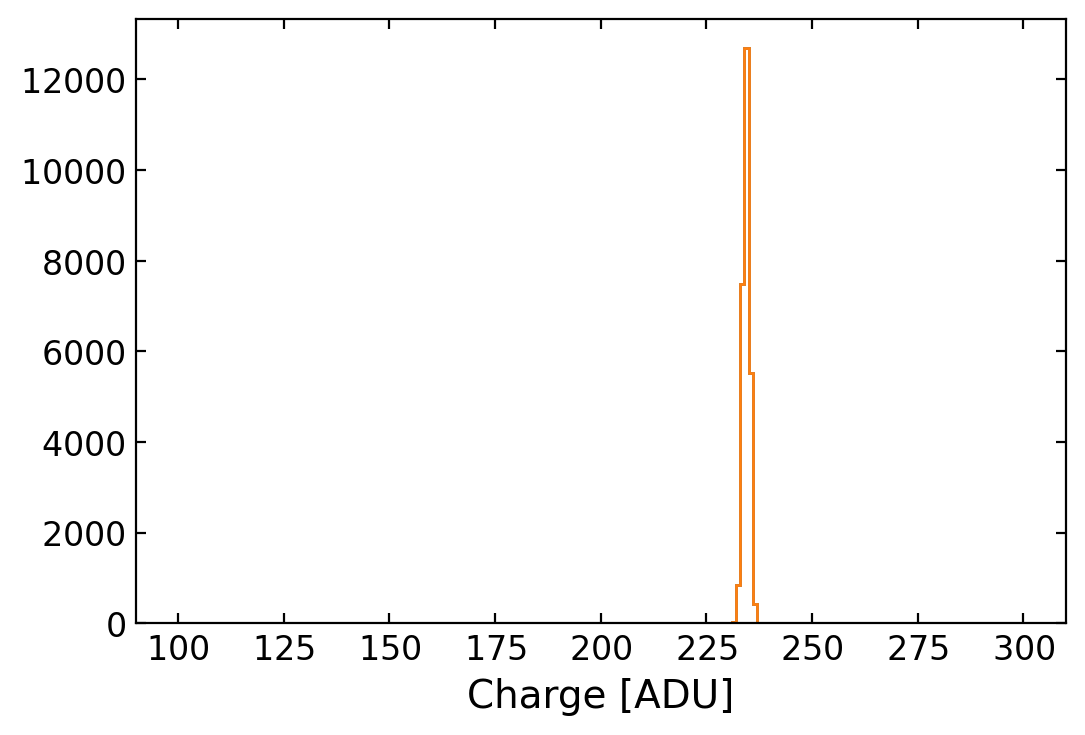

In [12]:
hist(data[f"CHARGE_{ch}"],bins=200,range=(100,300),histtype="step");
n,ibins,p = hist(data[f"CHARGE_{ch}"][data["CHARGE_0"]>150],bins=200,range=(100,300),histtype="step");
# yscale("log")
xlabel("Charge [ADU]")

bincenters=0.5*(ibins[1:] + ibins[:-1])

# peaks,info=scipy.signal.find_peaks(n,prominence=1000)
# for peak in peaks:
#     axvline(bincenters[peak])
    
# gap = bincenters[peaks[1]]-bincenters[peaks[0]]
# print(gap)

# stddev_in_npeaks = np.sqrt(np.mean(np.square(data[f"CHARGE_{ch}"][data[f"CHARGE_{ch}"]>175]-175)))/gap
# print("N std dev ", stddev_in_npeaks)

show()

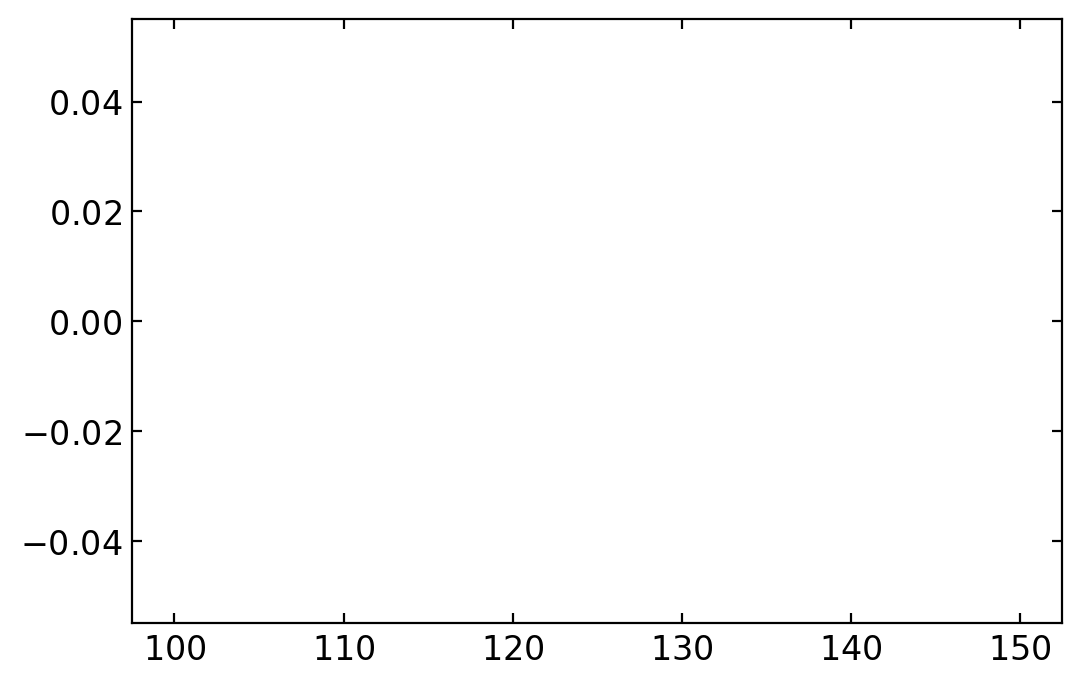

In [13]:
hist(data[f"CHARGE_{ch}"],range=(100,150));

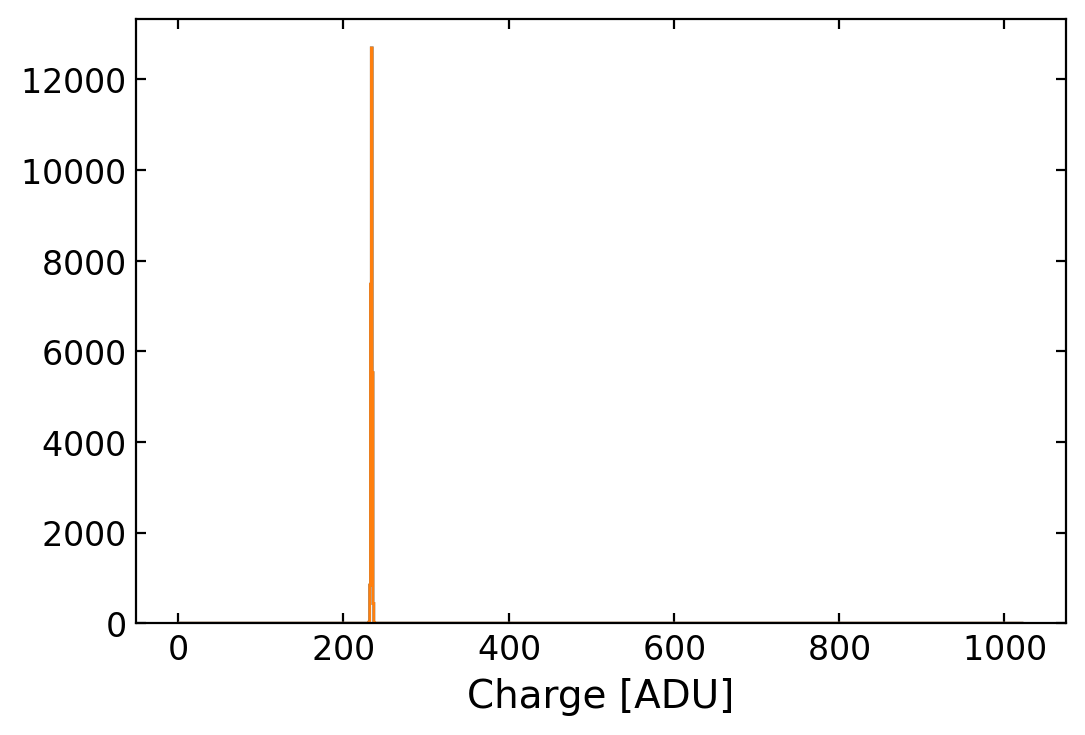

findfont: Font family ['san-serif'] not found. Falling back to DejaVu Sans.


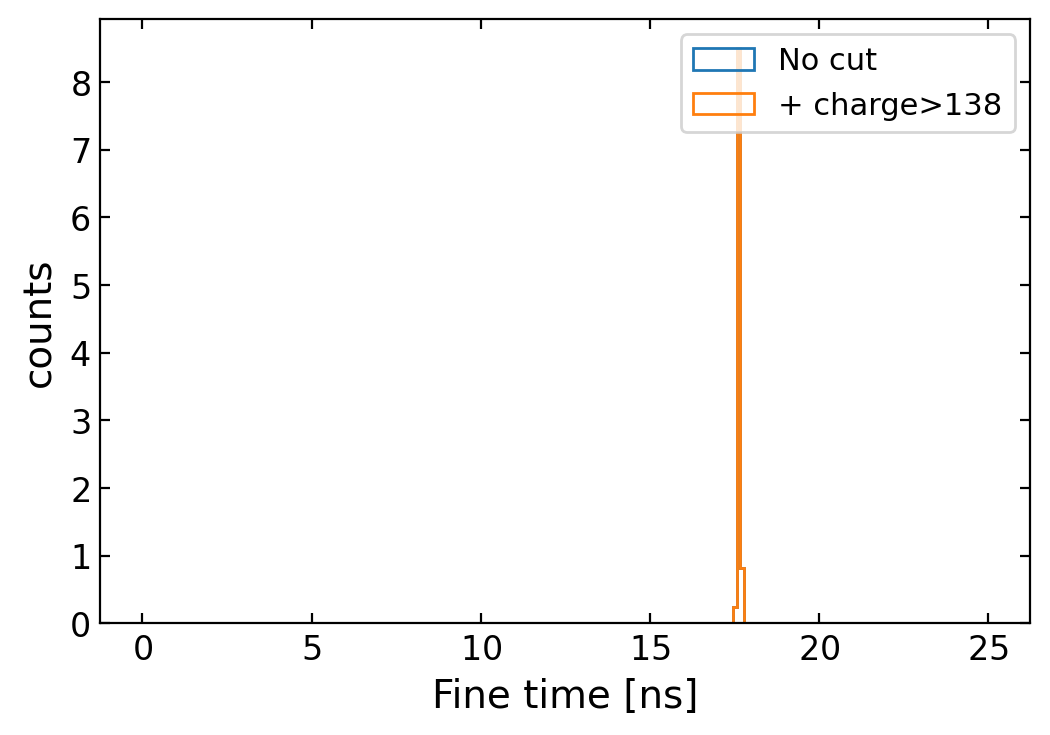

In [14]:
threshold=138
normed=True

hist(data[f"CHARGE_{ch}"],bins=1023,range=(0,1023),histtype="step");
hist(data[f"CHARGE_{ch}"][data["CHARGE_0"]>threshold],bins=1023,range=(0,1023),histtype="step");
# yscale("log")
xlabel("Charge [ADU]")
show()

bins=np.linspace(0,25,240)
# bins=np.linspace(4,14,60)

n,ibins,_ = hist(data[f"FINE_calib_{ch}"], bins=bins,label="No cut", density=normed, histtype="step", color="C0");
n,ibins,_ = hist(data[f"FINE_calib_{ch}"][data["CHARGE_0"]>threshold], bins=bins,label=f"+ charge>{threshold}", density=normed, histtype="step", color="C1");
# n1,ibins,_ = hist(data[f"FINE_calib_{ch}"][data["CHARGE_0"]<180], bins=bins,label="Dark current", density=1, histtype="step");
bincenters=0.5*(ibins[1:]+ibins[:-1])
yerr=np.sqrt(n);yerr[yerr==0]=1

# popt1,pcov = rt.fit_tg(bincenters,n,yerr=yerr,function="gaus",fit_range=(5,13))
# perr1 = np.sqrt(np.diag(pcov))
# print(popt1[2],'[cm]')
# plot(bincenters, util.Utils.Gauss(bincenters,*popt1),color="C1",linestyle=":",label=f"$\sigma$={popt1[2]:.2f} ns" )
# # plot(bincenters, util.Utils.Gauss(bincenters,*popt1),color="C0",label=f"$\sigma$={popt1[2]:.1f}$\pm${perr1[2]:.1f} \n "+r"$\bar{x}$"+f"={popt1[1]:.1f}$\pm${perr1[1]:.1f} "  )

xlabel("Fine time [ns]")
ylabel("counts")
legend(fontsize=11)
# yscale("log")

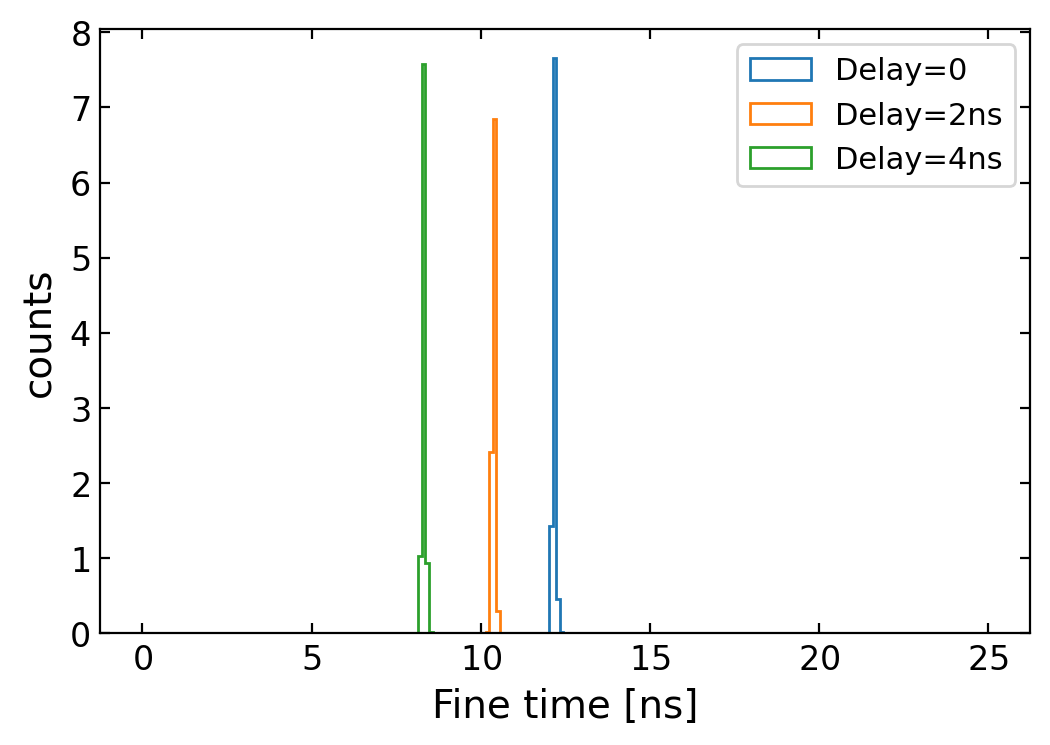

In [15]:
filename = f"{DATA_DIR}/52.data"
data  = pd.read_csv(filename, sep=';', on_bad_lines  = "skip", usecols=["CHARGE_0", "FINE_0","RUN_EventTimecode_ns"])
ch = "0"
# data[f"FINE_calib_{ch}"] = finetime_calib(data[f"FINE_{ch}"])
data[f"FINE_calib_{ch}"] = finetime_calib(data[f"FINE_{ch}"], low=ftime_min, high=ftime_max)
bins=np.linspace(0,25,240)
n,ibins,_ = hist(data[f"FINE_calib_{ch}"], bins=bins,label="Delay=0", density=normed, histtype="step", color="C0");

filename = f"{DATA_DIR}/53.data"
data  = pd.read_csv(filename, sep=';', on_bad_lines  = "skip", usecols=["CHARGE_0", "FINE_0","RUN_EventTimecode_ns"])
ch = "0"
# data[f"FINE_calib_{ch}"] = finetime_calib(data[f"FINE_{ch}"])
data[f"FINE_calib_{ch}"] = finetime_calib(data[f"FINE_{ch}"], low=ftime_min, high=ftime_max)
bins=np.linspace(0,25,240)
n,ibins,_ = hist(data[f"FINE_calib_{ch}"], bins=bins,label="Delay=2ns", density=normed, histtype="step", color="C1");

filename = f"{DATA_DIR}/54.data"
data  = pd.read_csv(filename, sep=';', on_bad_lines  = "skip", usecols=["CHARGE_0", "FINE_0","RUN_EventTimecode_ns"])
ch = "0"
# data[f"FINE_calib_{ch}"] = finetime_calib(data[f"FINE_{ch}"])
data[f"FINE_calib_{ch}"] = finetime_calib(data[f"FINE_{ch}"], low=ftime_min, high=ftime_max)
bins=np.linspace(0,25,240)
n,ibins,_ = hist(data[f"FINE_calib_{ch}"], bins=bins,label="Delay=4ns", density=normed, histtype="step", color="C2");





xlabel("Fine time [ns]")
ylabel("counts")
legend(fontsize=11)


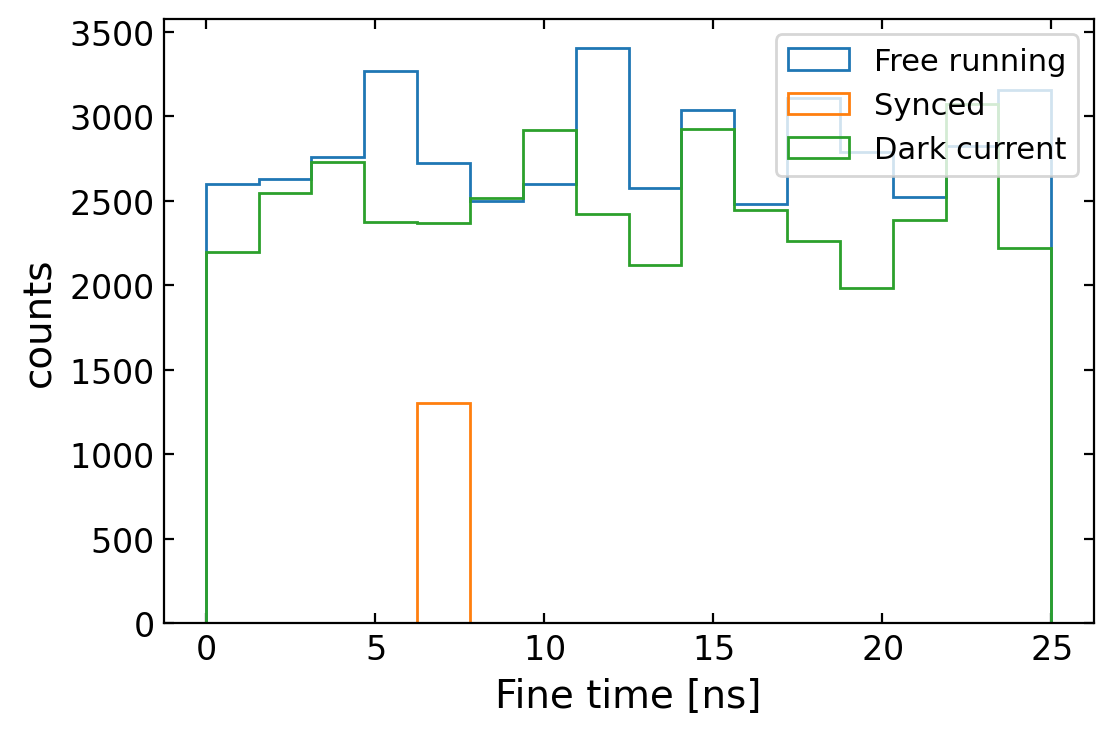

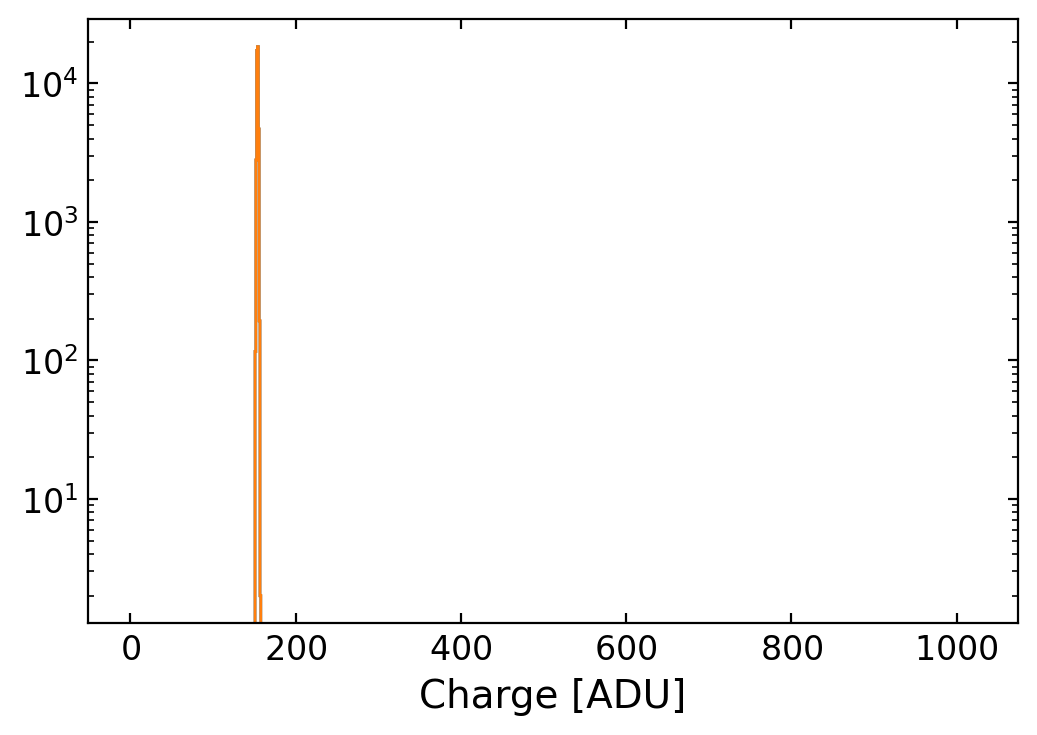

0.0630386656184844 [ns]


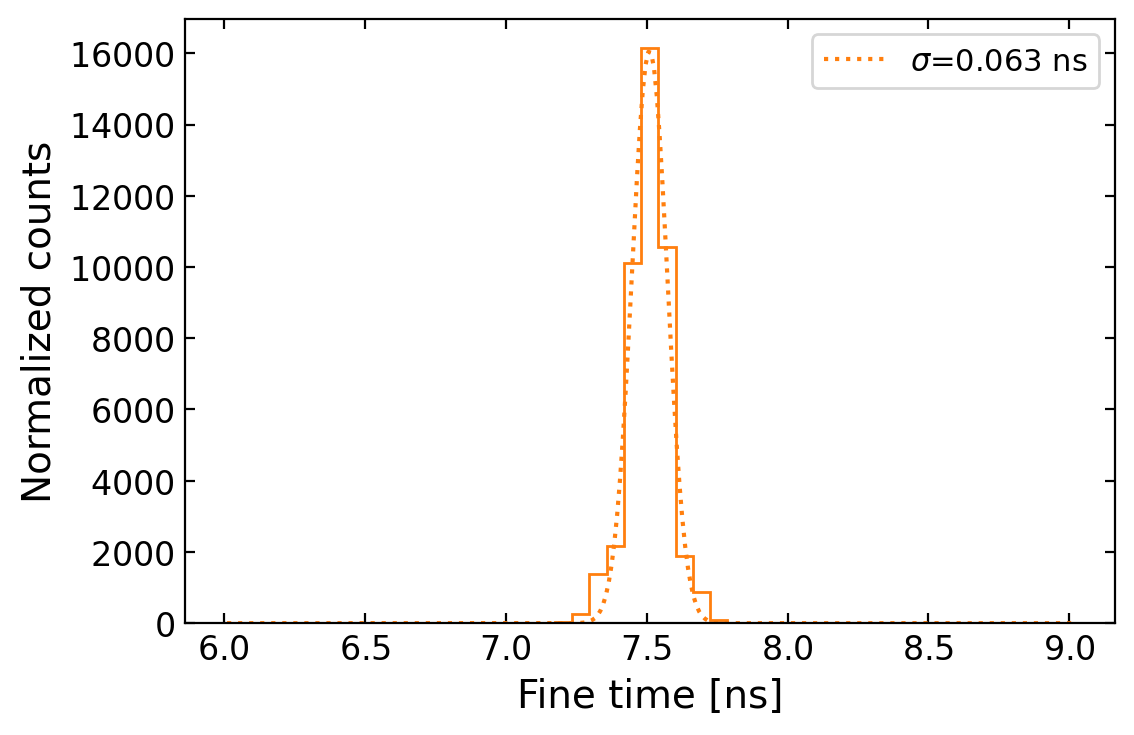

In [16]:
nbins = 1+len(np.unique(data[f"FINE_calib_{ch}"]))
bins=np.linspace(0,25,nbins)
ch="0"
normed=False

data  = load_finetime(f"{DATA_DIR}/55.data", ch =ch, ftime_min=ftime_min, ftime_max=ftime_max)
n1,ibins,_ = hist(data[f"FINE_calib_{ch}"], bins=bins,label="Free running", density=normed, histtype="step", color="C0");

data  = load_finetime(f"{DATA_DIR}/56.data", ch =ch, ftime_min=ftime_min, ftime_max=ftime_max)
n,ibins,_ = hist(data[f"FINE_calib_{ch}"], bins=bins,label="Synced", weights=np.ones_like(data[f"FINE_calib_{ch}"])*0.03, histtype="step", color="C1");


data  = load_finetime(f"{DATA_DIR}/48.data", ch =ch, ftime_min=ftime_min, ftime_max=ftime_max)
n,ibins,_ = hist(data[f"FINE_calib_{ch}"], bins=bins,label="Dark current", weights=np.ones_like(data[f"FINE_calib_{ch}"])*1.2, histtype="step", color="C2");



xlabel("Fine time [ns]")
ylabel("counts")
legend(fontsize=11)
show()

plot_charge_time(f"{DATA_DIR}/56.data", charge_cut_threshold=100, title_text="", finetime_roll=0)


# Resolution at different delay

FuncGen input, 200mV-20dB, 1ns+5ns+20ns

In [9]:
labels = np.arange(0,27)
data_inds = np.arange(74,101)
bins=np.linspace(0,25,240)
ch="0"
normed=False

# Load all data
Data = []
for i, idata in enumerate(data_inds):
    data  = load_finetime(f"{DATA_DIR}/{idata}.data", ch =ch, ftime_min=ftime_min, ftime_max=ftime_max)
    Data.append(data)
    

0.058989200684158 [ns]
0.05236102482160101 [ns]
0.0367158466228369 [ns]
0.04025549916223352 [ns]
0.04626130880049202 [ns]
0.05625040509782885 [ns]
0.05066073415729099 [ns]
0.035404197233858535 [ns]
0.05500727190690788 [ns]
0.05506184583641788 [ns]
0.037441531869373136 [ns]
0.050939981352394303 [ns]
0.05293183597201165 [ns]
0.04591910313527276 [ns]
0.04133864161742037 [ns]
0.04184582567345293 [ns]
0.03998919319864686 [ns]
0.04624083249463557 [ns]
0.058183309922697726 [ns]
0.040626208275163174 [ns]
0.051972092208161534 [ns]
0.05146538999402028 [ns]
0.04626036064125268 [ns]
0.03748345860686063 [ns]
0.04873821167122693 [ns]


findfont: Font family ['san-serif'] not found. Falling back to DejaVu Sans.


0.052681452774748096 [ns]
0.05110763190620407 [ns]


findfont: Font family ['san-serif'] not found. Falling back to DejaVu Sans.


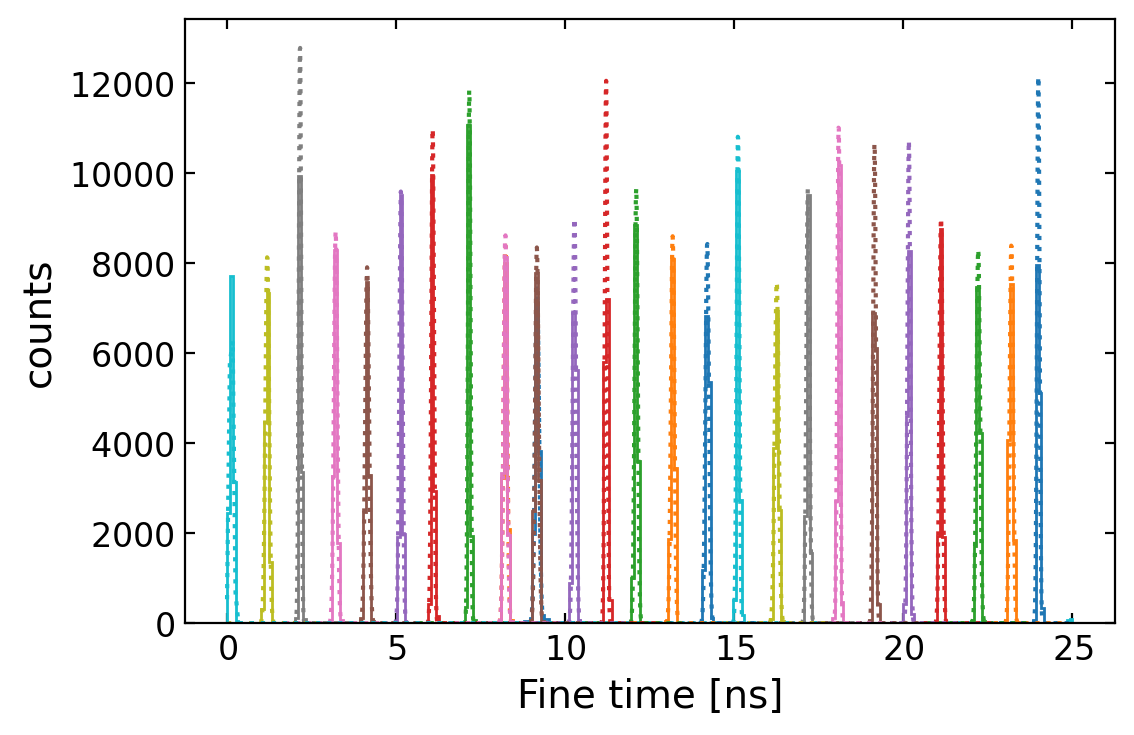

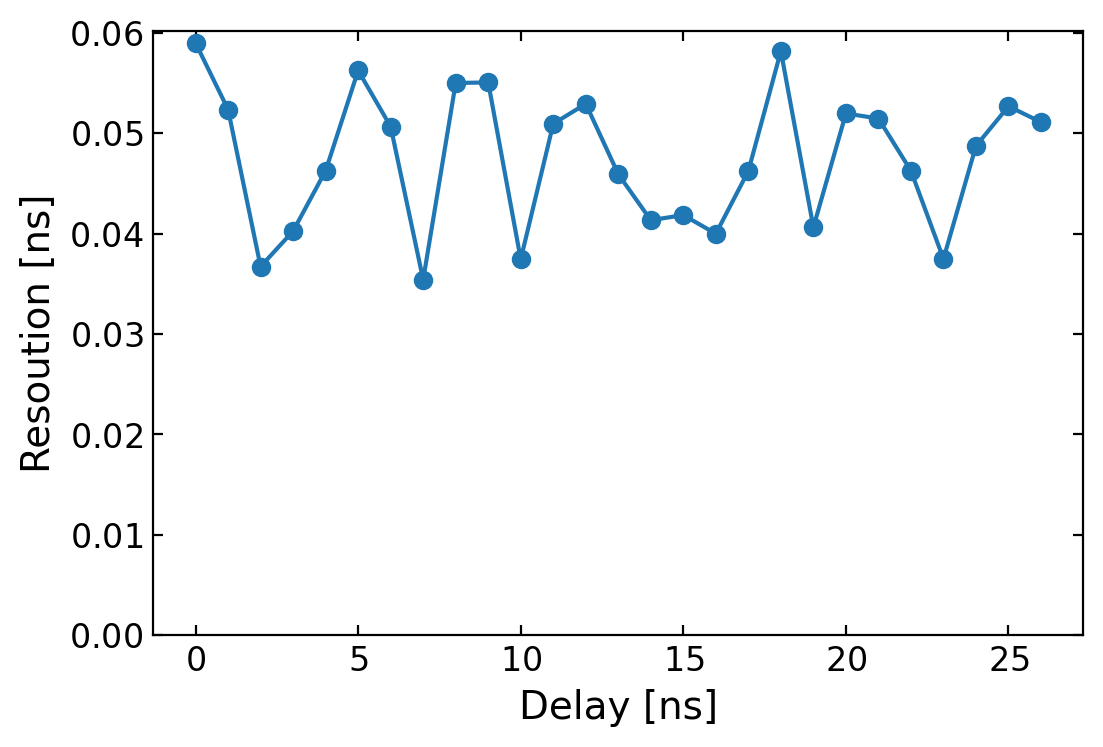

Text(0, 0.5, 'Measured delay - nominal delay [ns]')

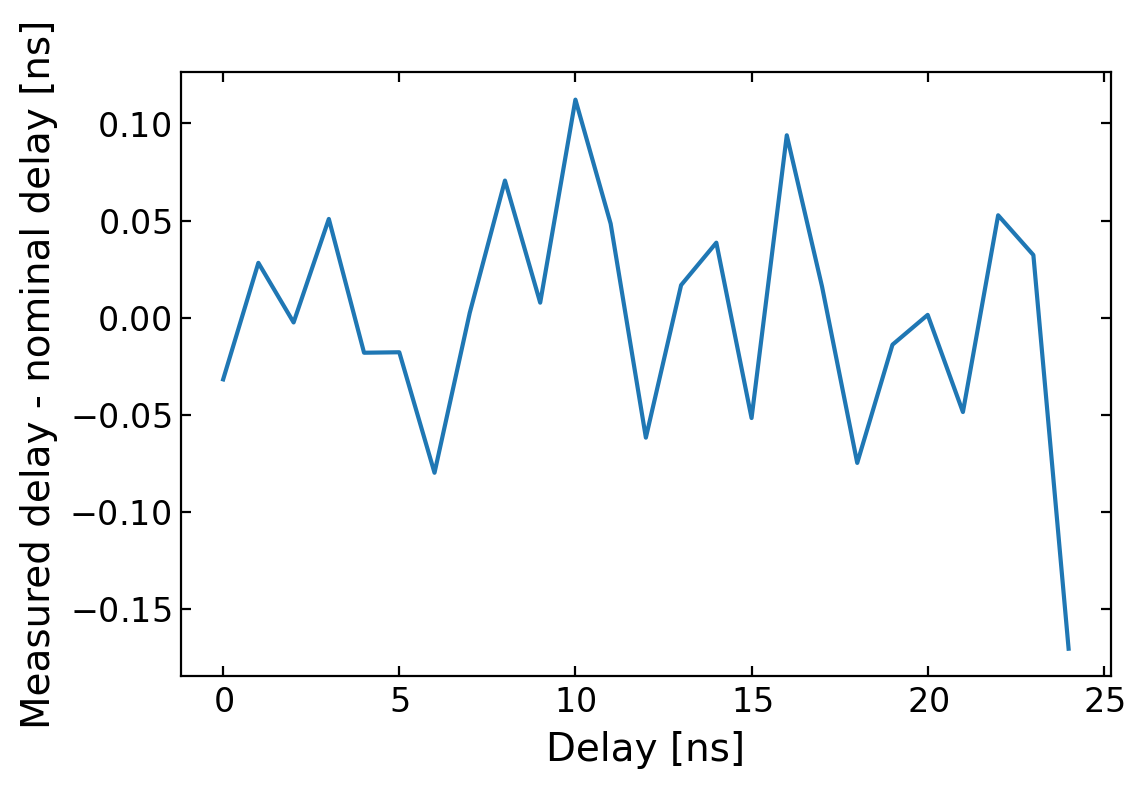

In [10]:
resolutions_funcgen_scan = []
peak_centers_funcgen_scan=[]
for i, idata in enumerate(data_inds[:]):
    data  = Data[i]
    mask = (data[f"CHARGE_{ch}"]>120)#&(data[f"CHARGE_{ch}"]<125)
    popt, pcov = fit_finetime(data[f"FINE_calib_{ch}"][mask], color=f"C{i}", bins=np.linspace(0,25,300));
    resolutions_funcgen_scan.append(popt[2])
    peak_centers_funcgen_scan.append(popt[1])


xlabel("Fine time [ns]")
ylabel("counts")
# legend(fontsize=11,loc=[1.01,0])
# legend()
gca().get_legend().remove()
ylim(0,)
show()
    
plot(labels, resolutions_funcgen_scan,marker="o")
xlabel("Delay [ns]")
ylabel("Resoution [ns]")
ylim(bottom=0)
show()

normimal_delays = np.round(peak_centers_funcgen_scan)[:-2]
measured_delays = np.array(peak_centers_funcgen_scan[:-2])
inds = np.argsort(normimal_delays)
normimal_delays = normimal_delays[inds]
measured_delays = measured_delays[inds]
residual = measured_delays-normimal_delays
residual-= np.mean(residual)
plot(normimal_delays, residual)
xlabel("Delay [ns]")
ylabel("Measured delay - nominal delay [ns]")


In [ ]:
h=hist(resolutions_funcgen_scan, range=(0,0.1),bins=30);
# popt, pcov, info, f = hp.fit_hist("gauss", h, label="Average ={popt[1]:.2f} ns", color=f"C{i}", linestyle="--");


xlim(0,)
xlabel("Time resolution [ns]")
ylabel("Counts")
# legend()
show()

# INL

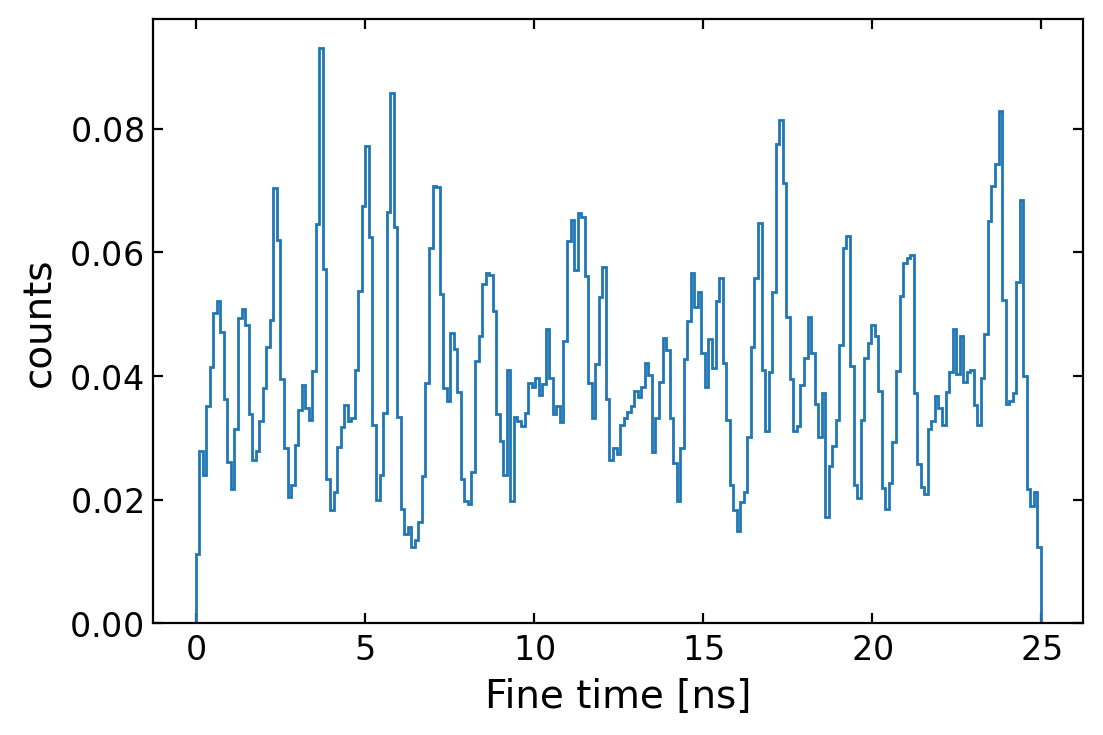

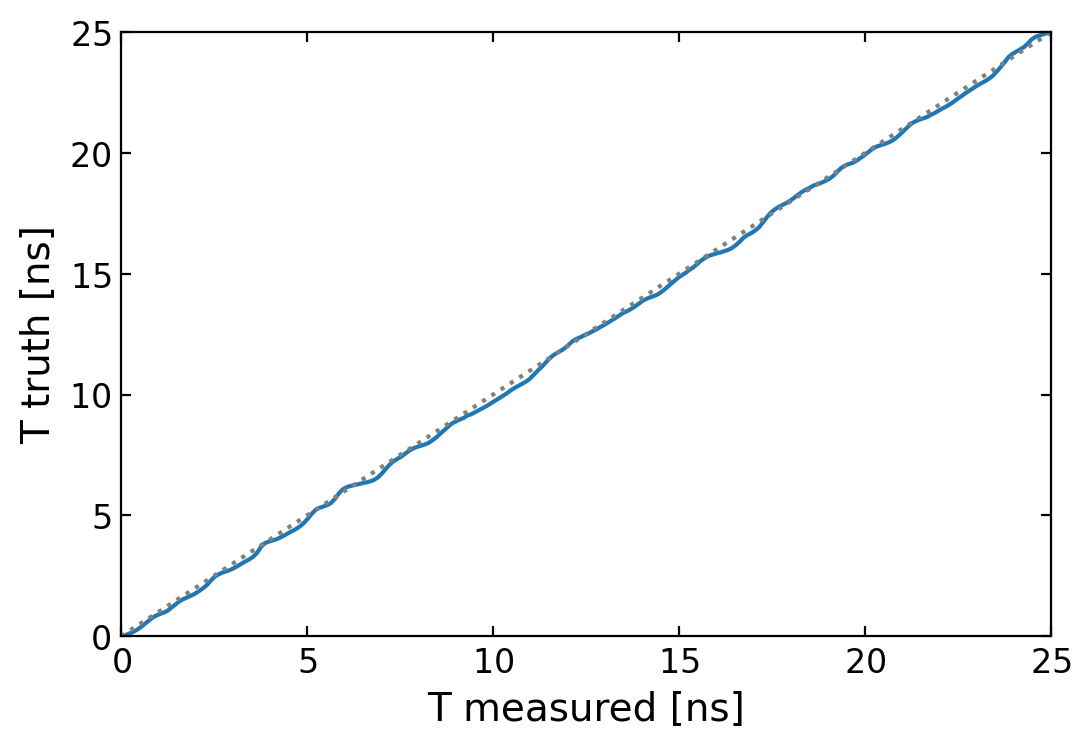

0.12041957249007391 [ns]


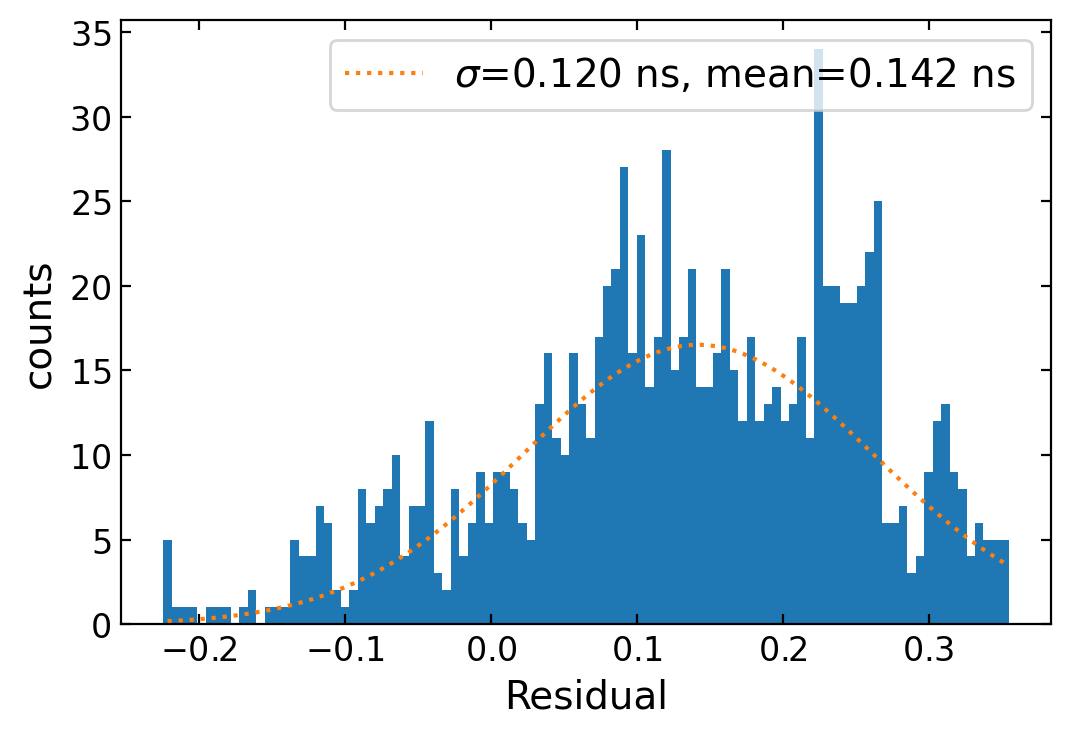

In [19]:
data  = load_finetime(f"{DATA_DIR}/55.data", ch =ch, ftime_min=ftime_min, ftime_max=ftime_max)
n1,ibins,_ = hist(data[f"FINE_calib_{ch}"], bins=bins,label="Free running", density=1, histtype="step", color="C0");
xlabel("Fine time [ns]")
ylabel("counts")
show()


binsize = bins[1]-bins[0]
binedge_right = ibins[1:]
cdf = np.cumsum(n1)
truth_time = cdf*binsize*25

plot(binedge_right, truth_time)
plot([0,25],[0,25],color="grey", linestyle=":")
xlabel("T measured [ns]")
ylabel("T truth [ns]")
xlim(0,25)
ylim(0,25)
show()



truth_to_measured = scipy.interpolate.interp1d(truth_time, binedge_right)
truth_grid = np.linspace(np.min(truth_time), np.max(truth_time), 1000)
measured = truth_to_measured(truth_grid)
residual = measured-truth_grid

n,ibins2,p = hist(residual);

bincenters2=0.5*(ibins2[1:]+ibins2[:-1])
yerr=np.sqrt(n);yerr[yerr==0]=1

popt1,pcov = rt.fit_tg(bincenters2,n,yerr=yerr,function="gaus",fit_range=(-0.3,0.3))
perr1 = np.sqrt(np.diag(pcov))
print(popt1[2],'[ns]')
plot(bincenters2, util.Utils.Gauss(bincenters2,*popt1),color="C1",linestyle=":",label=f"$\sigma$={popt1[2]:.3f} ns, mean={popt1[1]:.3f} ns")
xlabel("Residual")
ylabel("counts")
legend()

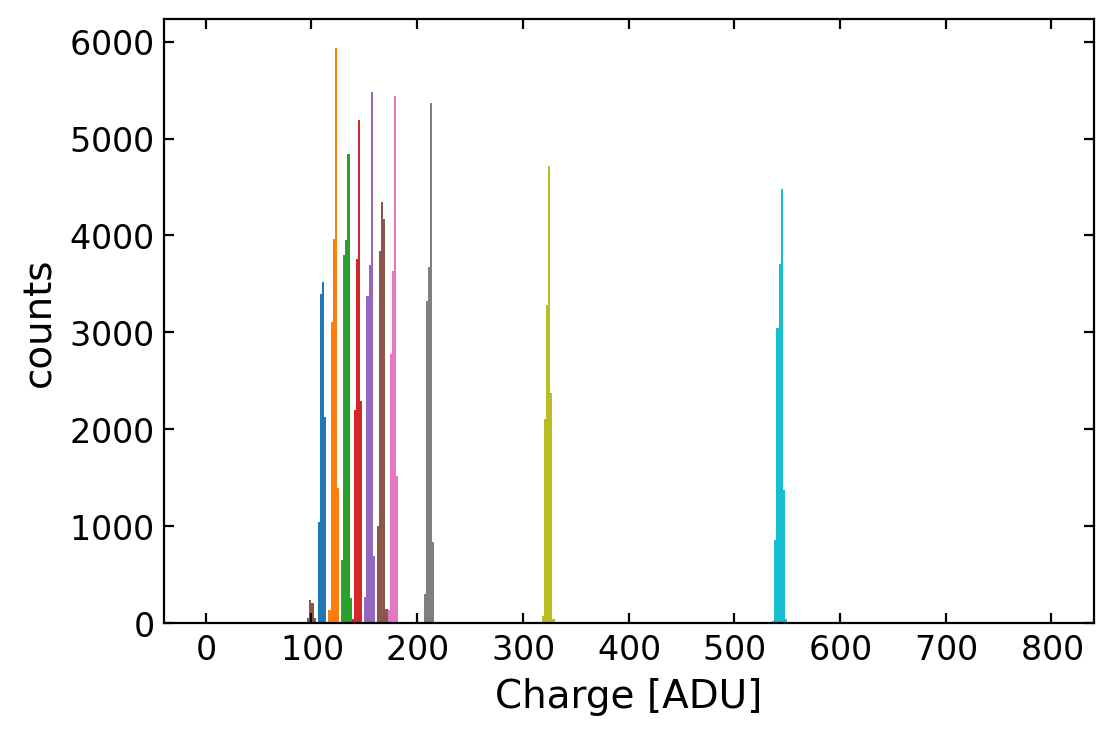

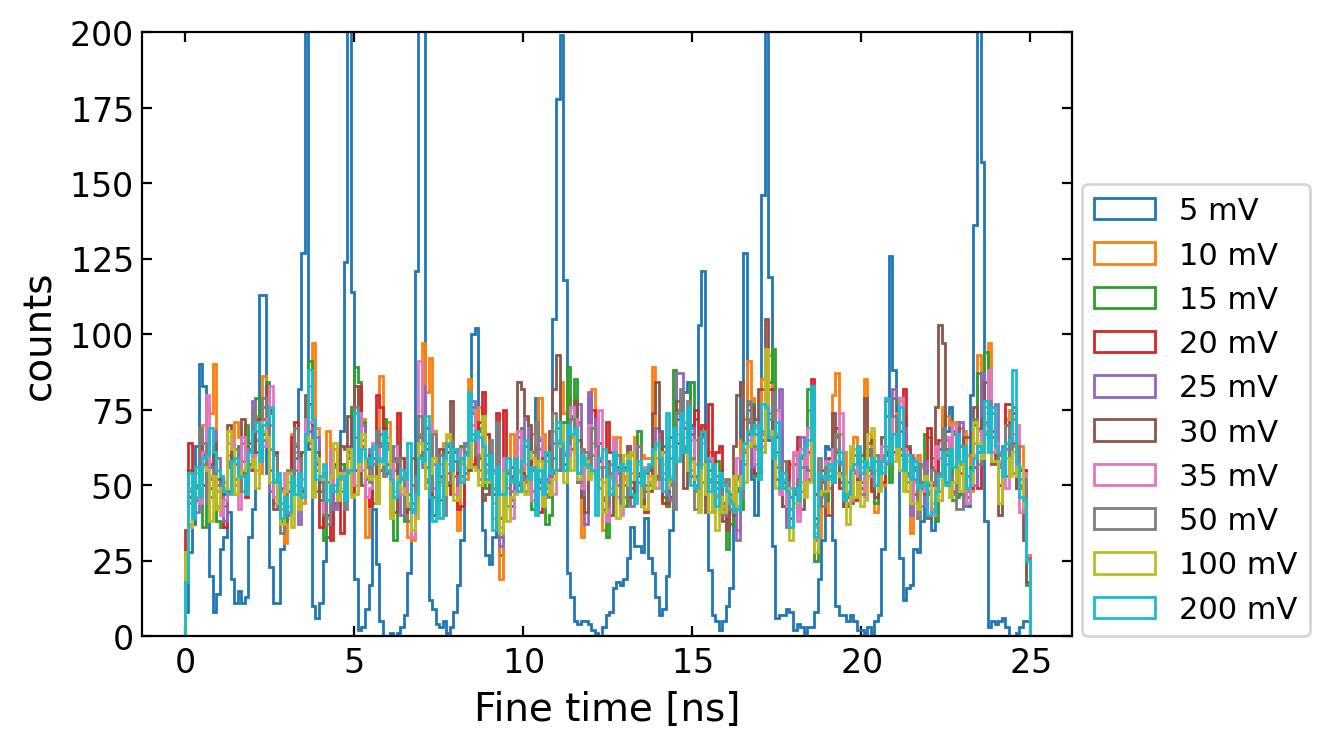

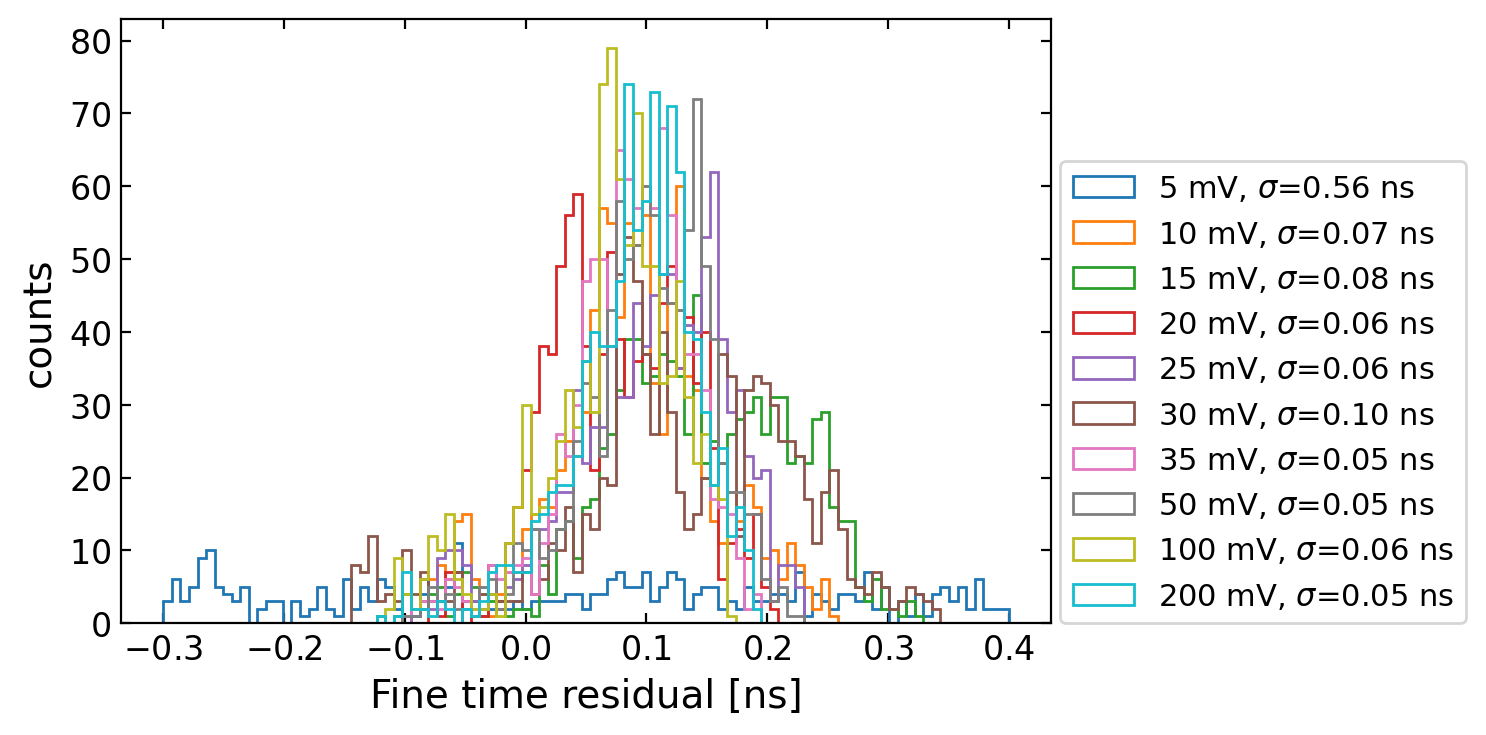

In [20]:
bins=np.linspace(0,25,240)
ch="0"
normed=False

labels = [5,10,15,20,25,30,35,50,100,200]

for i, idata in enumerate(range(57,67)):
    data  = load_finetime(f"{DATA_DIR}/{idata}.data", ch =ch, ftime_min=ftime_min, ftime_max=ftime_max)
    n,ibins,_ = hist(data[f"CHARGE_{ch}"], bins=np.linspace(0,800,401));

xlabel("Charge [ADU]")
ylabel("counts")
# legend(fontsize=11,loc=[1.01,0])
# ylim(0,200)
show()



for i, idata in enumerate(range(57,67)):
    data  = load_finetime(f"{DATA_DIR}/{idata}.data", ch =ch, ftime_min=ftime_min, ftime_max=ftime_max)
    n,ibins,_ = hist(data[f"FINE_calib_{ch}"], bins=bins,label=f"{labels[i]} mV", density=normed, histtype="step");


xlabel("Fine time [ns]")
ylabel("counts")
legend(fontsize=11,loc=[1.01,0])
ylim(0,200)
show()



for i, idata in enumerate(range(57,67)):
    data  = load_finetime(f"{DATA_DIR}/{idata}.data", ch =ch, ftime_min=ftime_min, ftime_max=ftime_max)
    residuals = process_inl(data[f"FINE_calib_{ch}"])
    residuals_std = np.std(residuals)
    hist(residuals, bins=np.linspace(-0.3,0.4,100), histtype="step",label=f"{labels[i]} mV, $\sigma$={residuals_std:.2f} ns");

xlabel("Fine time residual [ns]")
ylabel("counts")
legend(fontsize=11,loc=[1.01,0])
show()

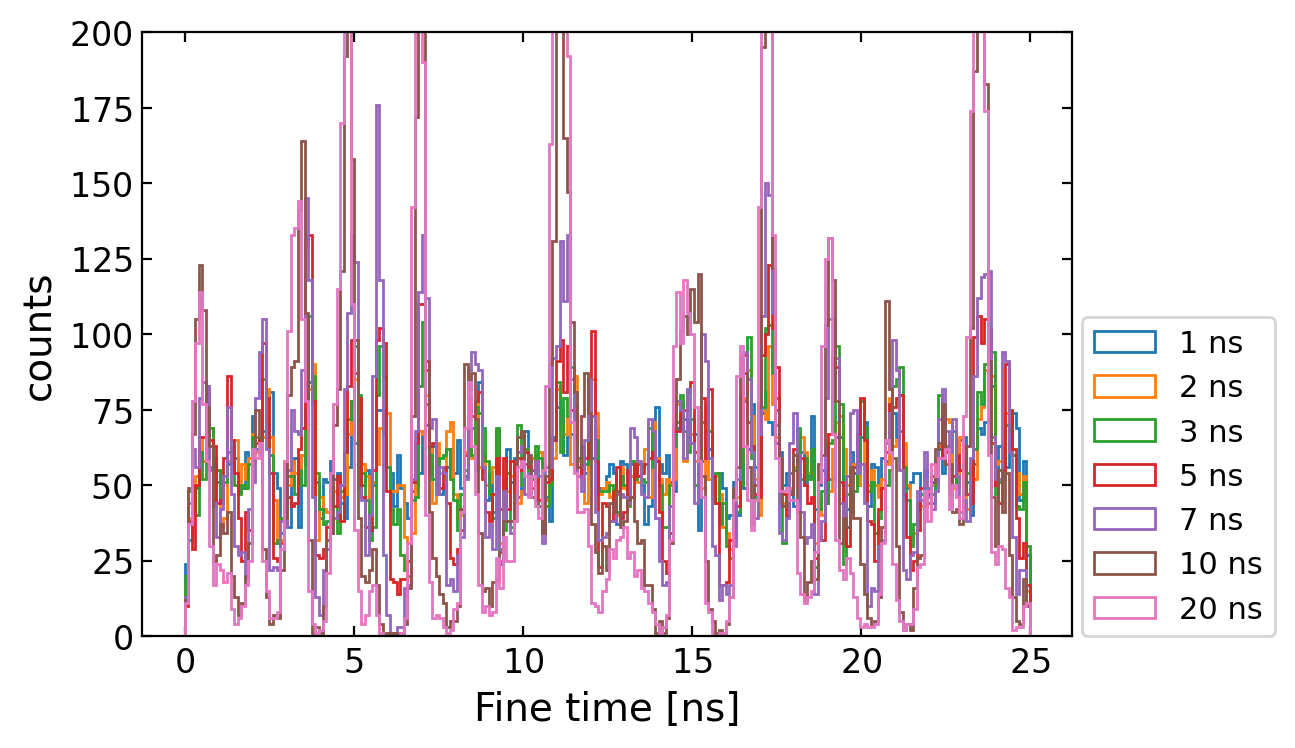

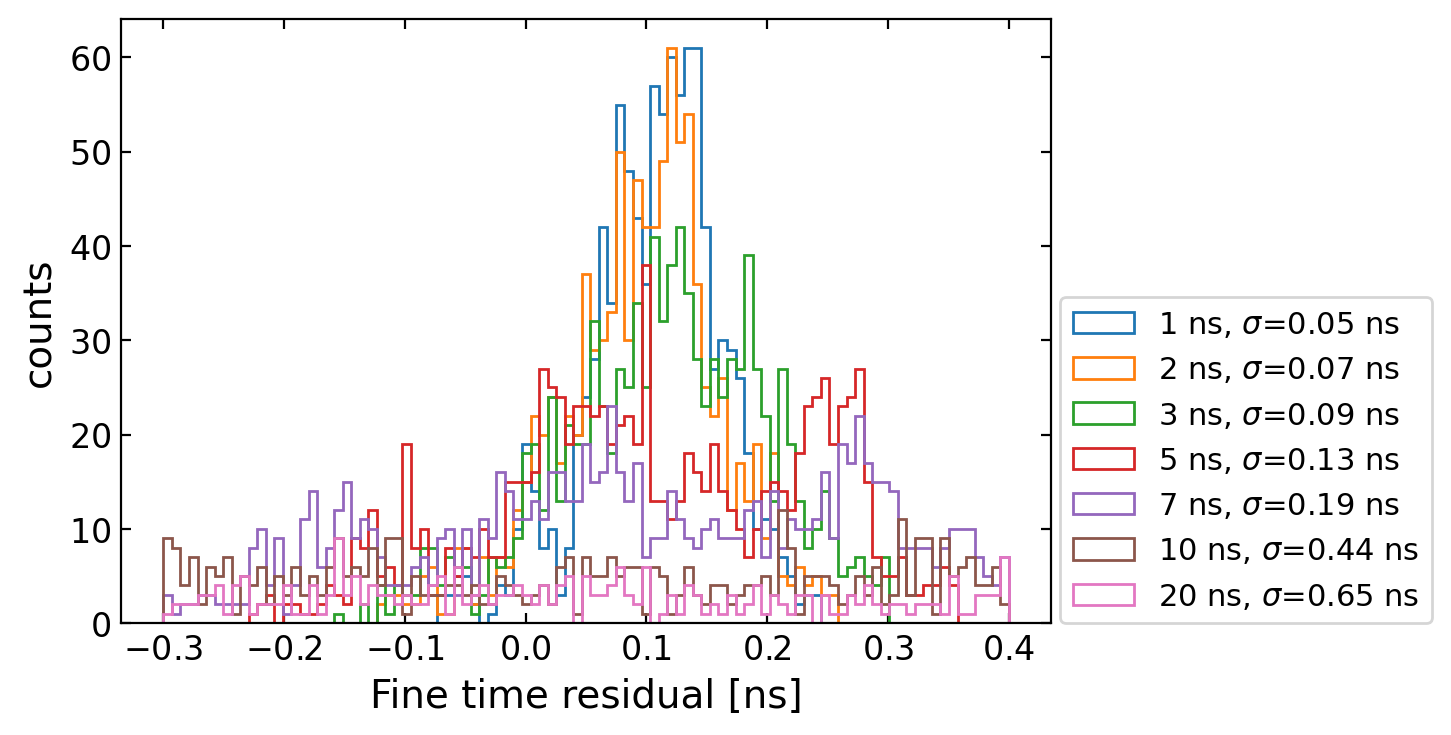

In [21]:
bins=np.linspace(0,25,240)
ch="0"
normed=False

labels = [1, 2, 3, 5, 7, 10, 20]

for i, idata in enumerate(range(67,74)):
    data  = load_finetime(f"{DATA_DIR}/{idata}.data", ch =ch, ftime_min=ftime_min, ftime_max=ftime_max)
    n,ibins,_ = hist(data[f"FINE_calib_{ch}"], bins=bins,label=f"{labels[i]} ns", density=normed, histtype="step");


xlabel("Fine time [ns]")
ylabel("counts")
legend(fontsize=11,loc=[1.01,0])
ylim(0,200)
show()



for i, idata in enumerate(range(67,74)):
    data  = load_finetime(f"{DATA_DIR}/{idata}.data", ch =ch, ftime_min=ftime_min, ftime_max=ftime_max)
    residuals = process_inl(data[f"FINE_calib_{ch}"])
    residuals_std = np.std(residuals)
    hist(residuals, bins=np.linspace(-0.3,0.4,100), histtype="step",label=f"{labels[i]} ns, $\sigma$={residuals_std:.2f} ns");

xlabel("Fine time residual [ns]")
ylabel("counts")
legend(fontsize=11,loc=[1.01,0])
show()

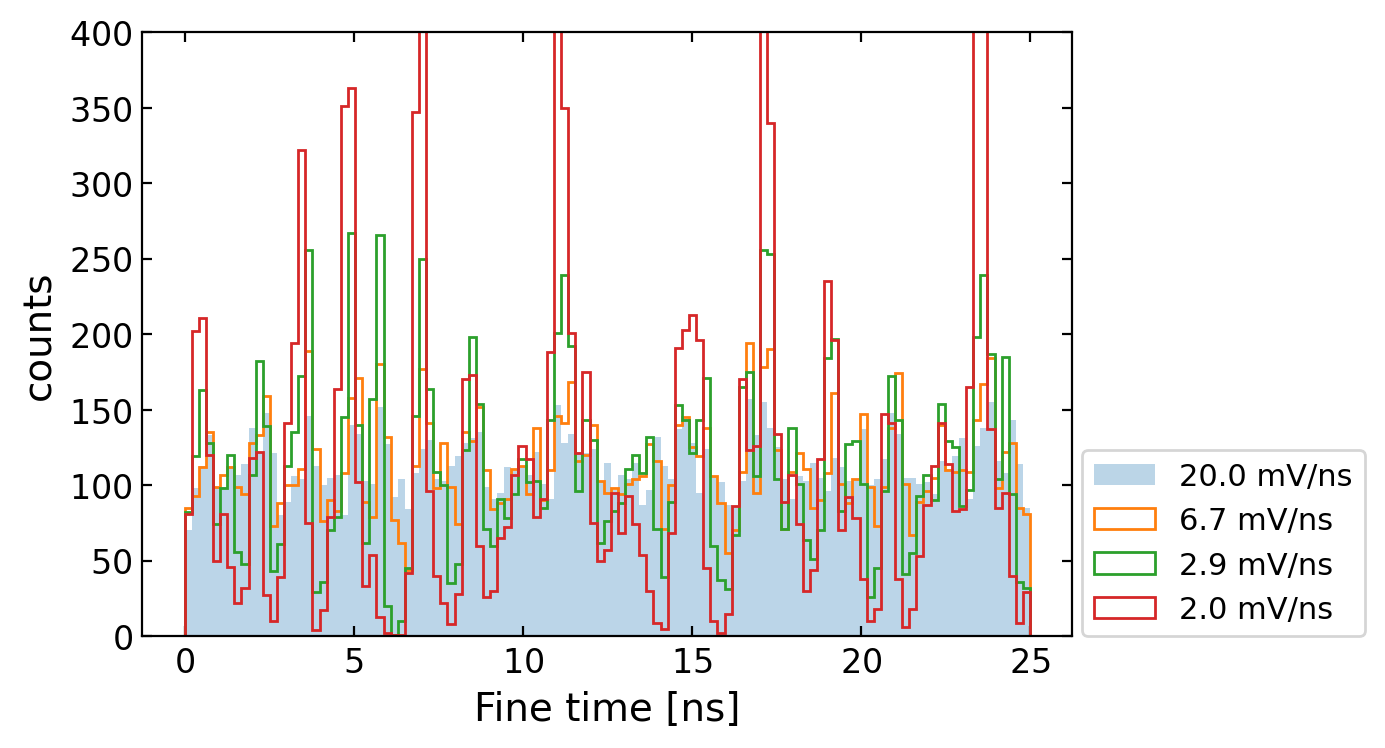

In [19]:
bins=np.linspace(0,25,120)
ch="0"
normed=False

labels = [1, 2, 3, 5, 7, 10, 20]
ikeep = [1,3,7,10]

for i, idata in enumerate(range(67,74)):
    if labels[i] not in ikeep:
        continue
    data  = load_finetime(f"{DATA_DIR}/{idata}.data", ch =ch, ftime_min=ftime_min, ftime_max=ftime_max)
    histtype = "bar" if i==0 else "step"
    alpha = 0.3 if i==0 else 1
    n,ibins,_ = hist(data[f"FINE_calib_{ch}"], bins=bins,label=f"{20/labels[i]:.1f} mV/ns", density=normed, histtype=histtype, alpha=alpha);


xlabel("Fine time [ns]")
ylabel("counts")
legend(fontsize=11,loc=[1.01,0])
ylim(0,400)
show()



# Time resolution scan, SiPM only

### Get the calibration of the 100 ADU dataset

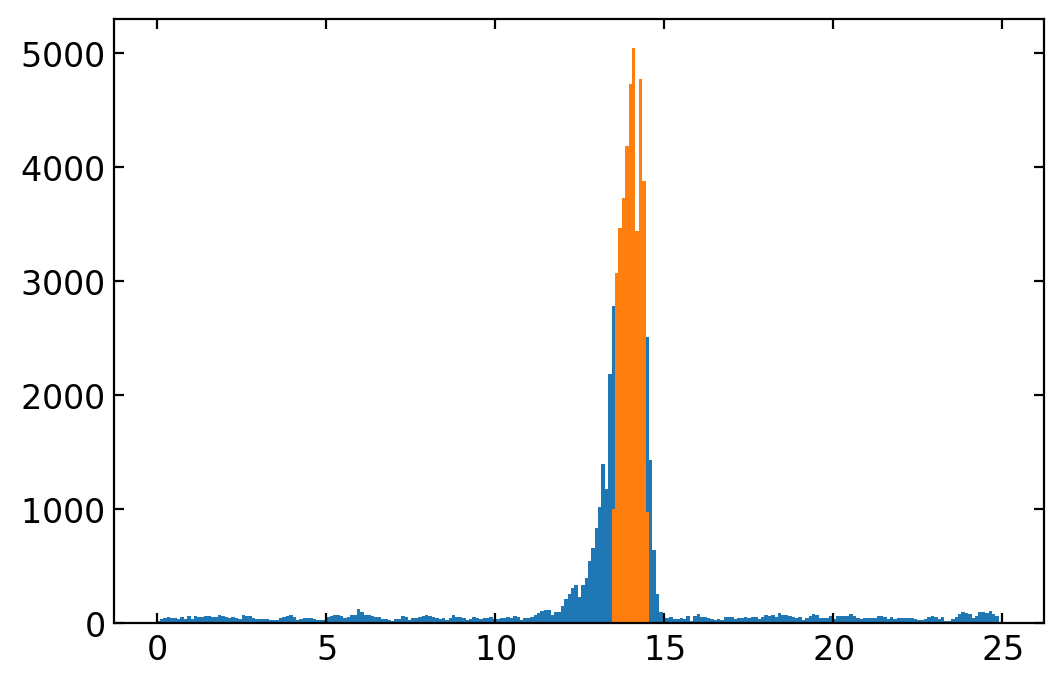

In [22]:
data  = load_finetime(f"{DATA_DIR}/102.data", ch =ch, ftime_min=ftime_min, ftime_max=ftime_max, finetime_roll=0)
data_baseline  = load_finetime(f"{DATA_DIR}/117.data", ch =ch, ftime_min=ftime_min, ftime_max=ftime_max, finetime_roll=0)


# use time cut to select laser events
mask_ft = (data[f"FINE_calib_{ch}"]>13.5)&(data[f"FINE_calib_{ch}"]<14.5)
hist(data[f"FINE_calib_{ch}"], bins=np.linspace(0,25,250));
hist(data[f"FINE_calib_{ch}"][mask_ft], bins=np.linspace(0,25,250));
show()

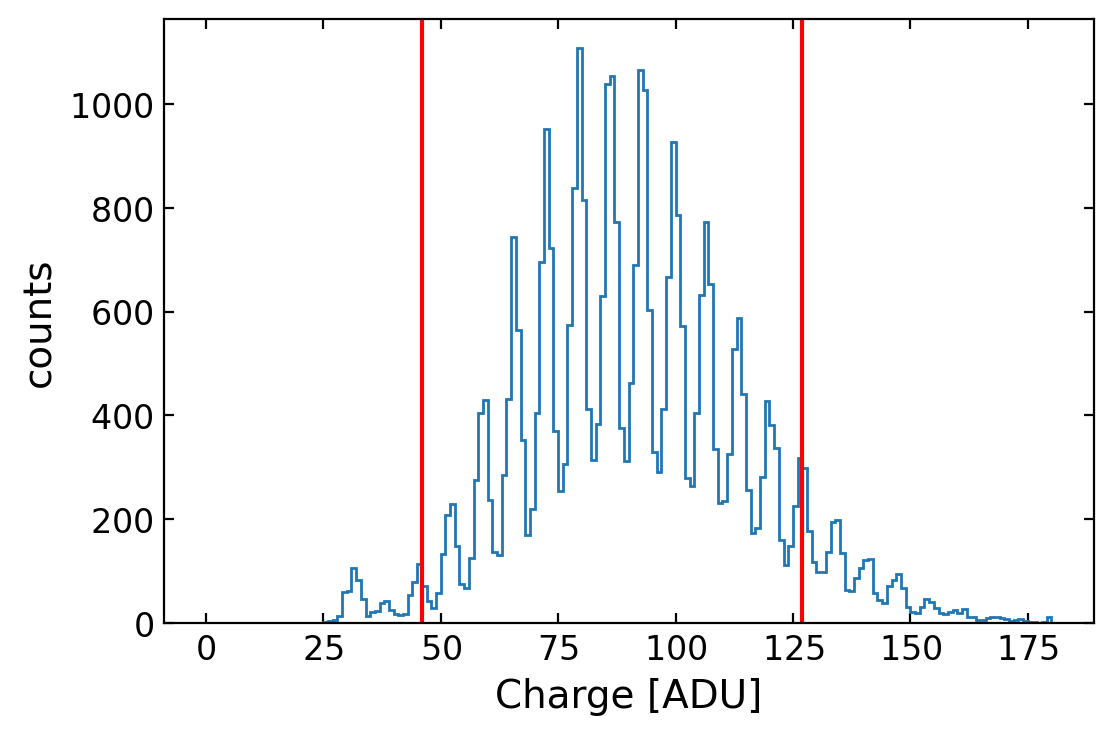

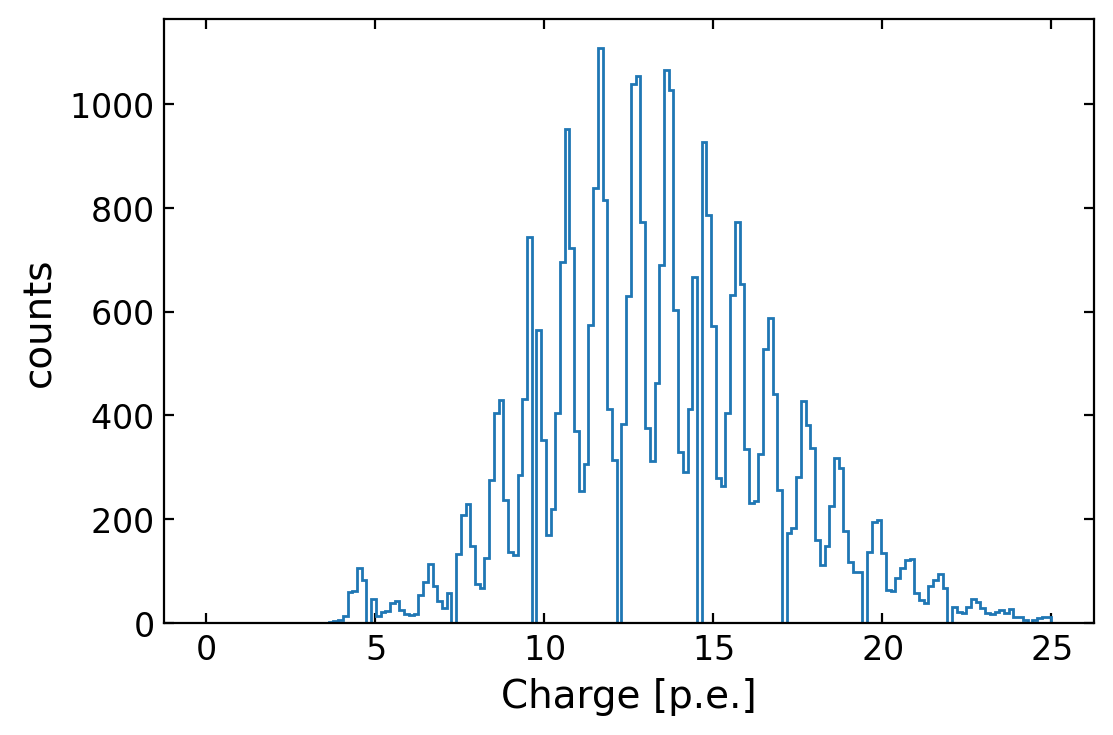

Average charge 13.520426706900135 [p.e.]


In [23]:
baseline = np.median(data_baseline[f"CHARGE_{ch}"][~np.isnan(data_baseline[f"CHARGE_{ch}"])])
n,ibins,_ = hist(data[f"CHARGE_{ch}"][mask_ft]-baseline, bins=np.linspace(0,180,181),histtype="step");
# hist(data_baseline[f"CHARGE_{ch}"]-baseline, bins=np.linspace(0,180,181),histtype="step");
xlabel("Charge [ADU]")
ylabel("counts")
axvline(46,color="r")
axvline(127,color="r")
show()


# peak_locs,peak_info = scipy.signal.find_peaks(n, threshold=20,prominence=20)
# print(np.diff(peak_locs))
# peak_gap = np.median(np.diff(peak_locs)) * (ibins[1]-ibins[0])
peak_gap = (127-46)/12
data[f"CHARGE_calib_{ch}"] = (data[f"CHARGE_{ch}"]-baseline)/peak_gap
mask_nan = ~np.isnan(data[f"CHARGE_calib_{ch}"])
hist(data[f"CHARGE_calib_{ch}"][mask_ft&mask_nan], bins=np.linspace(0,25,180),histtype="step");
xlabel("Charge [p.e.]")
ylabel("counts")
show()

print("Average charge",np.mean(data[f"CHARGE_calib_{ch}"][mask_ft&mask_nan]), "[p.e.]")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


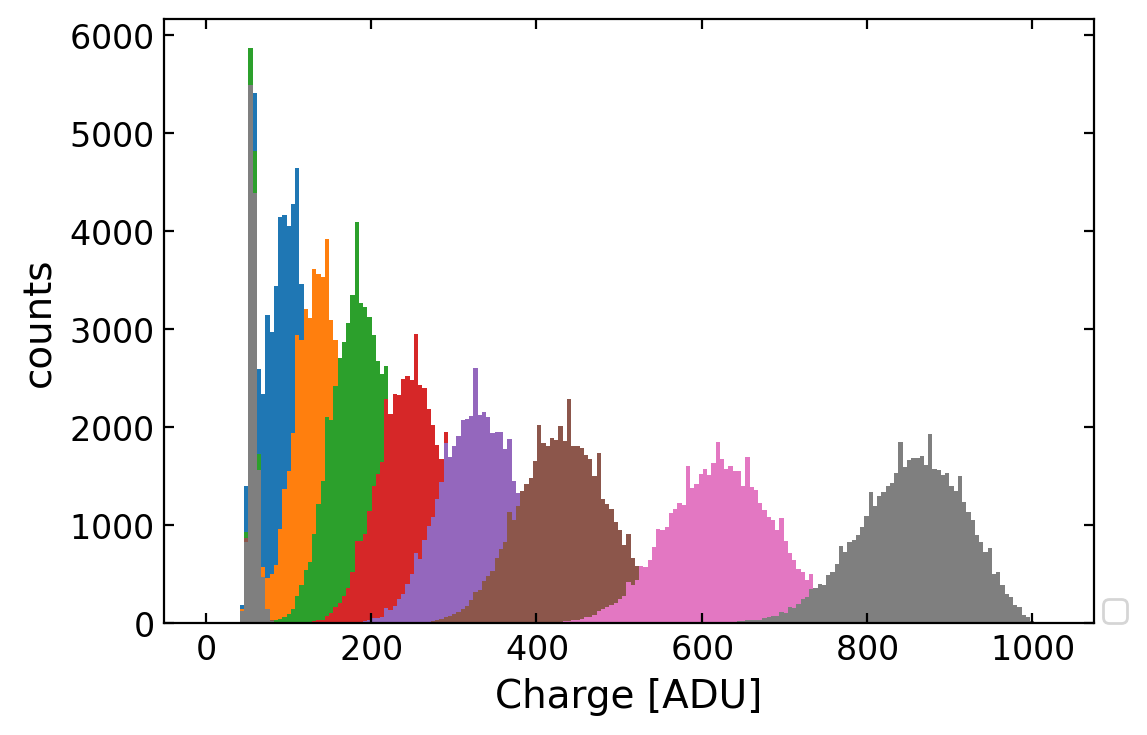

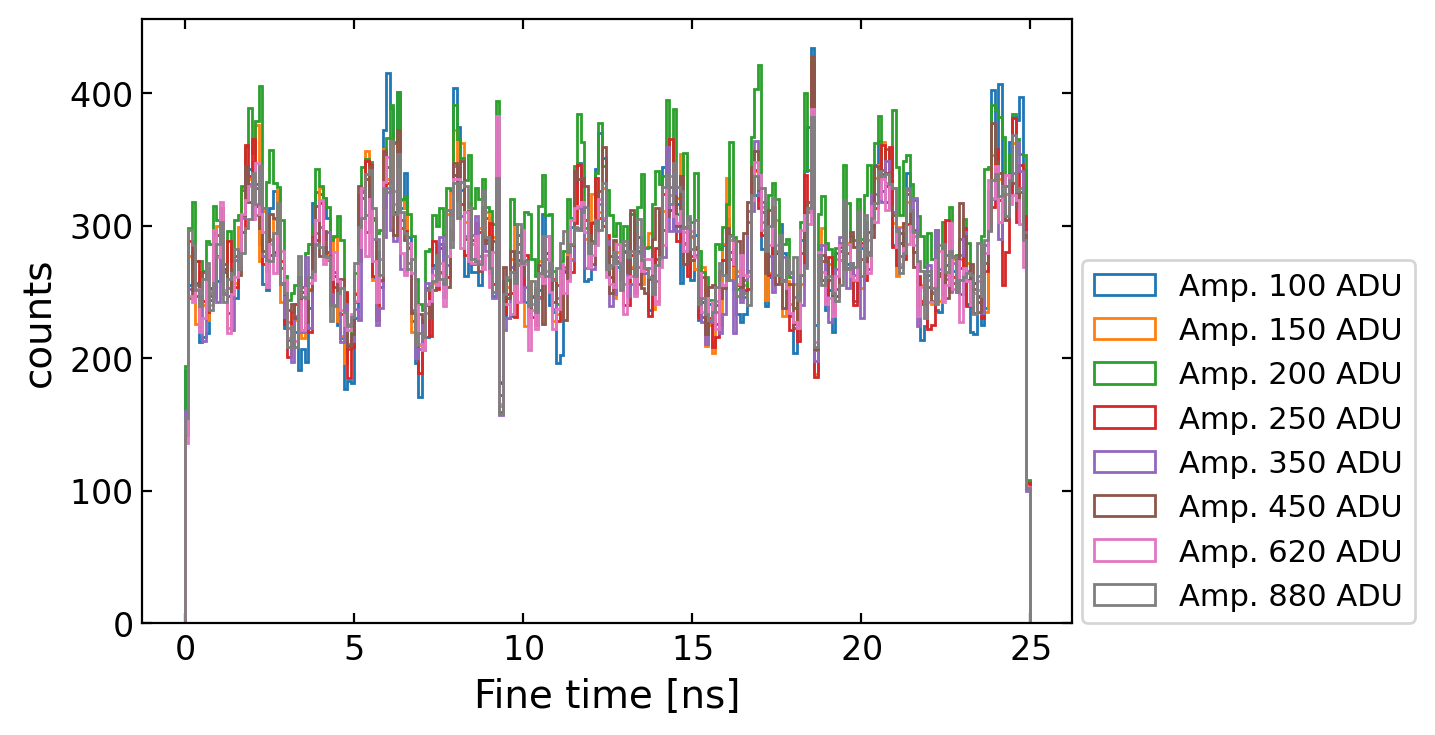

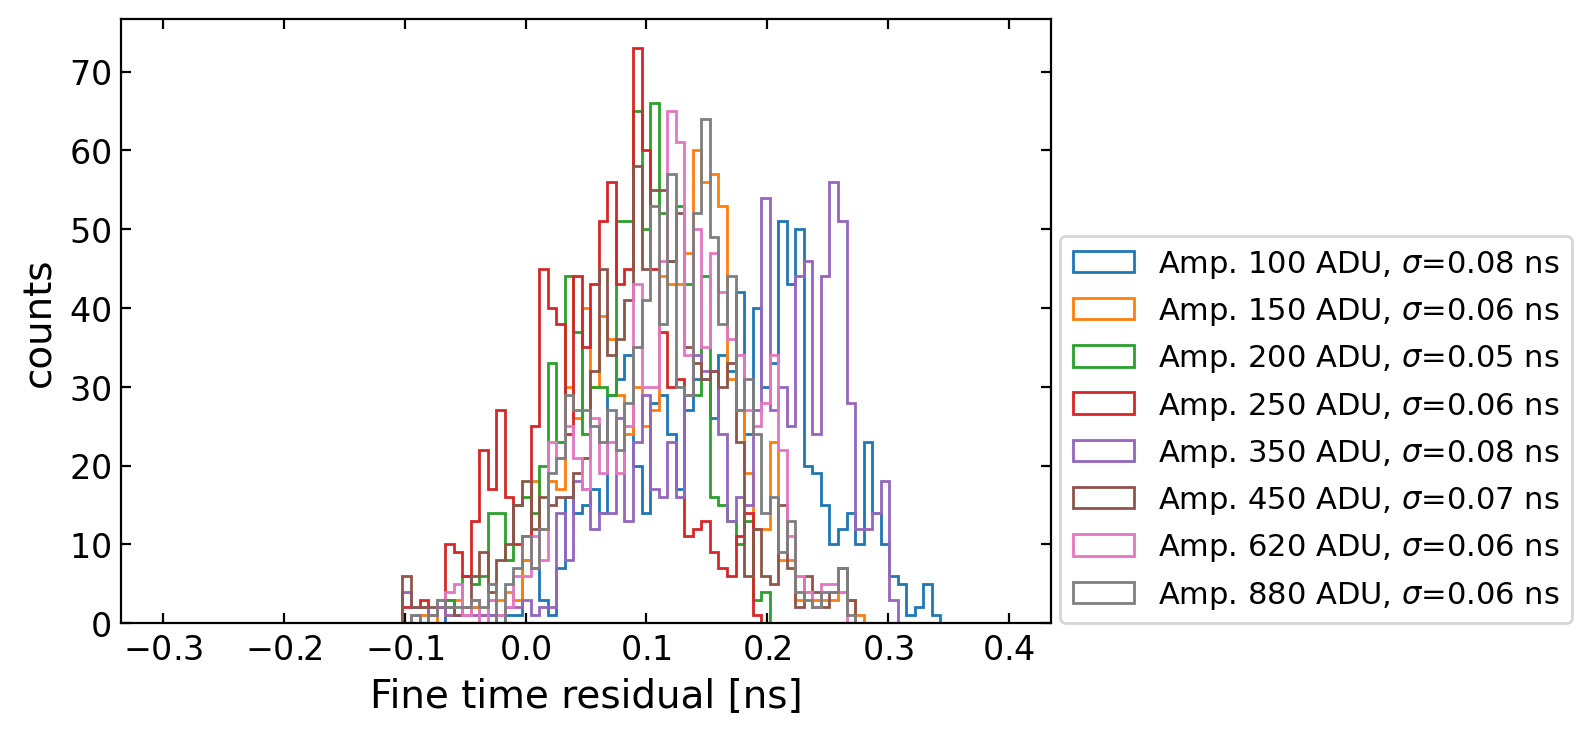

In [24]:
bins=np.linspace(0,25,240)
ch="0"
normed=False

labels = [100, 150, 200, 250, 350, 450, 620, 880]
data_inds = [101, 103, 105, 107, 109, 111, 113, 115]

# Load all data
Data = []
for i, idata in enumerate(data_inds):
    data  = load_finetime(f"{DATA_DIR}/{idata}.data", ch =ch, ftime_min=None, ftime_max=None)
    Data.append(data)
    
    
    
# Plot Charge    
for i, idata in enumerate(data_inds):
    data=Data[i]
    n,ibins,_ = hist(data[f"CHARGE_{ch}"], bins=np.linspace(0,1023,200));
xlabel("Charge [ADU]")
ylabel("counts")
legend(fontsize=11,loc=[1.01,0])
# ylim(0,200)
axvline(charge_threshold, color="red", linestyle=":")
show()


# Plot finetime    
for i, idata in enumerate(data_inds):
    data=Data[i]
    mask = data[f"CHARGE_{ch}"]>charge_threshold
    n,ibins,_ = hist(data[f"FINE_calib_{ch}"][mask], bins=bins,label=f"Amp. {labels[i]} ADU", density=normed, histtype="step");
xlabel("Fine time [ns]")
ylabel("counts")
legend(fontsize=11,loc=[1.01,0])
# ylim(0,200)
show()



for i, idata in enumerate(data_inds):
    data=Data[i]
    mask = data[f"CHARGE_{ch}"]>charge_threshold
    residuals = process_inl(data[f"FINE_calib_{ch}"][mask])
    residuals_std = np.std(residuals)
    hist(residuals, bins=np.linspace(-0.6,0.6,100), histtype="step",label=f"Amp. {labels[i]} ADU, $\sigma$={residuals_std:.2f} ns");

xlabel("Fine time residual [ns]")
ylabel("counts")
legend(fontsize=11,loc=[1.01,0])
show()

findfont: Font family ['san-serif'] not found. Falling back to DejaVu Sans.


0.3784942619612953 [ns]


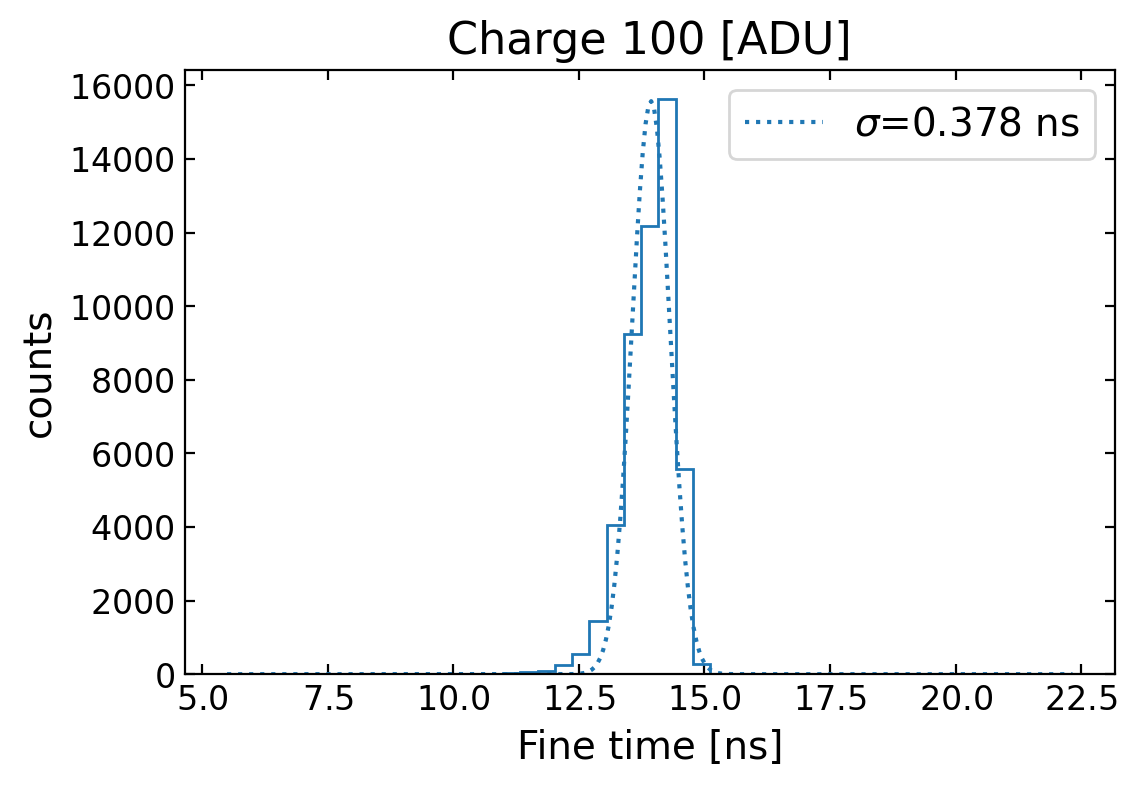

0.29567322816008057 [ns]


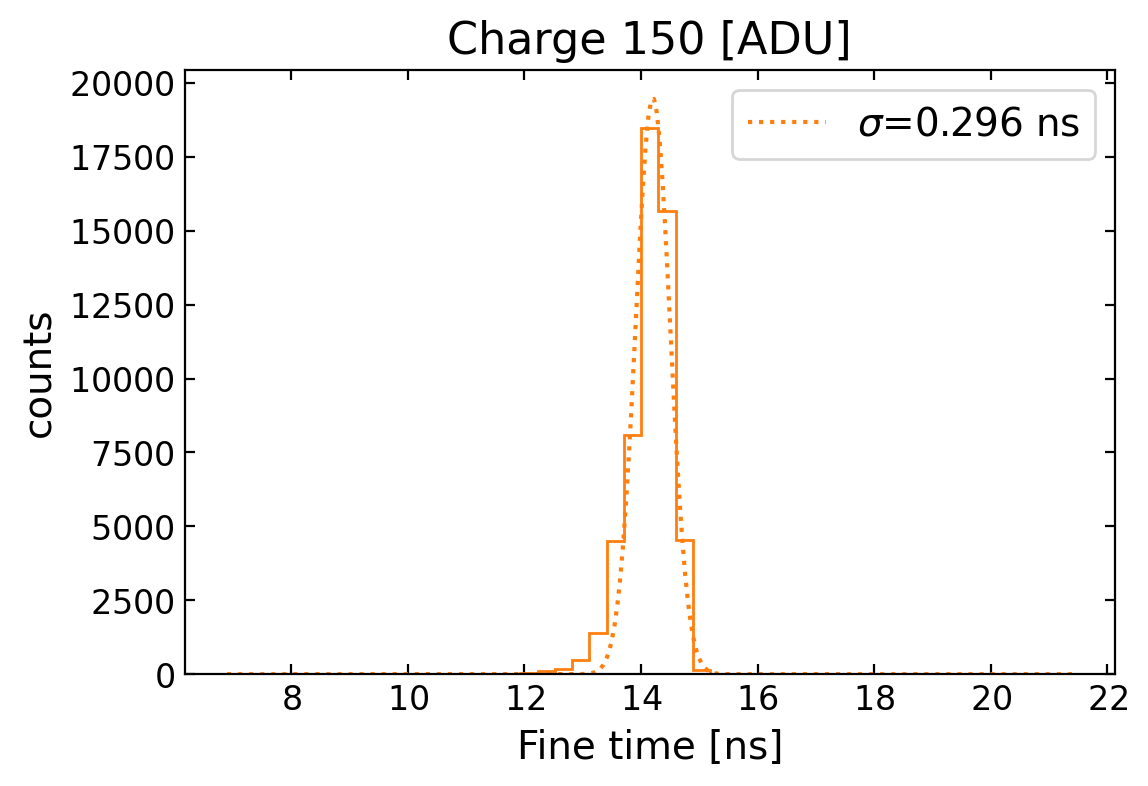

0.24982704555584045 [ns]


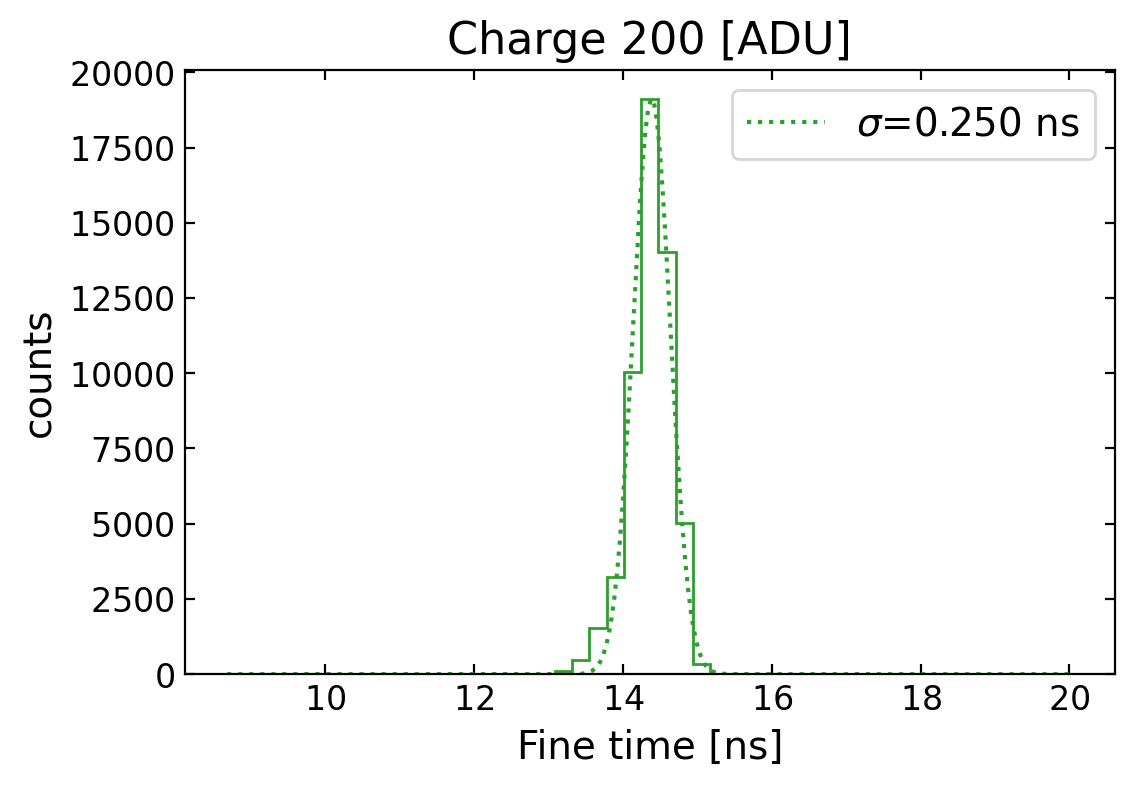

0.22889877409161652 [ns]


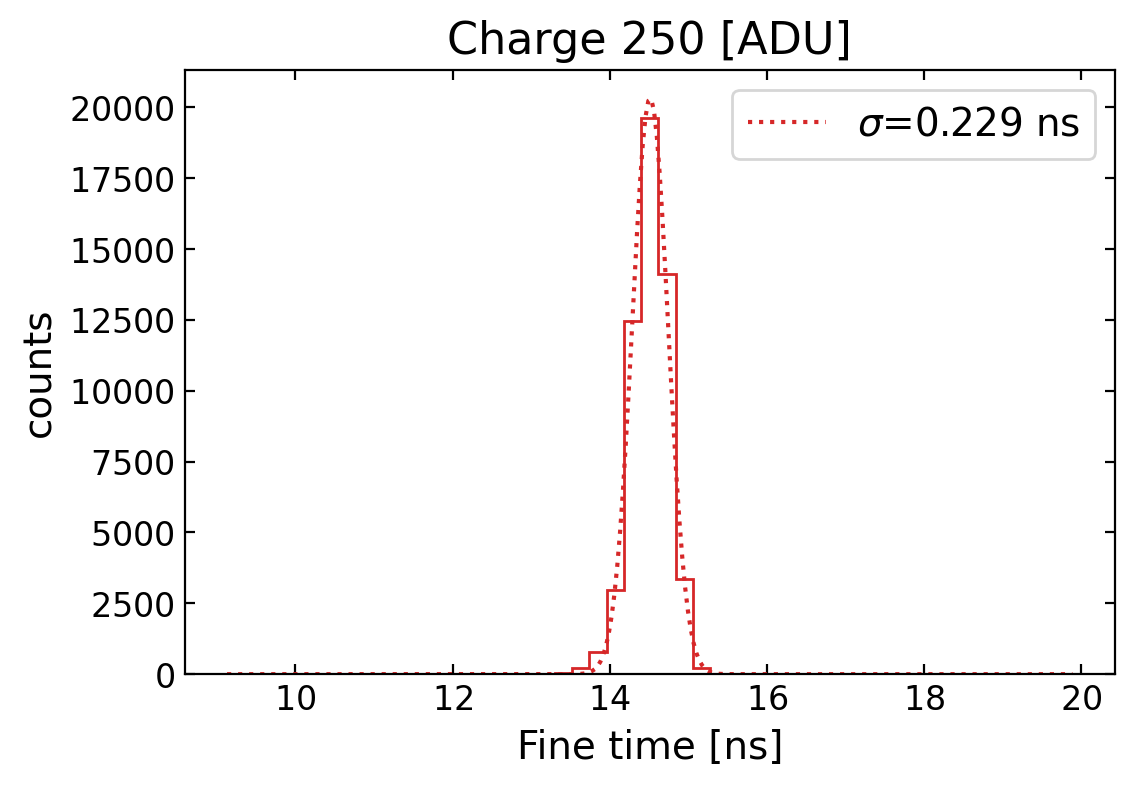

0.19359603000665984 [ns]


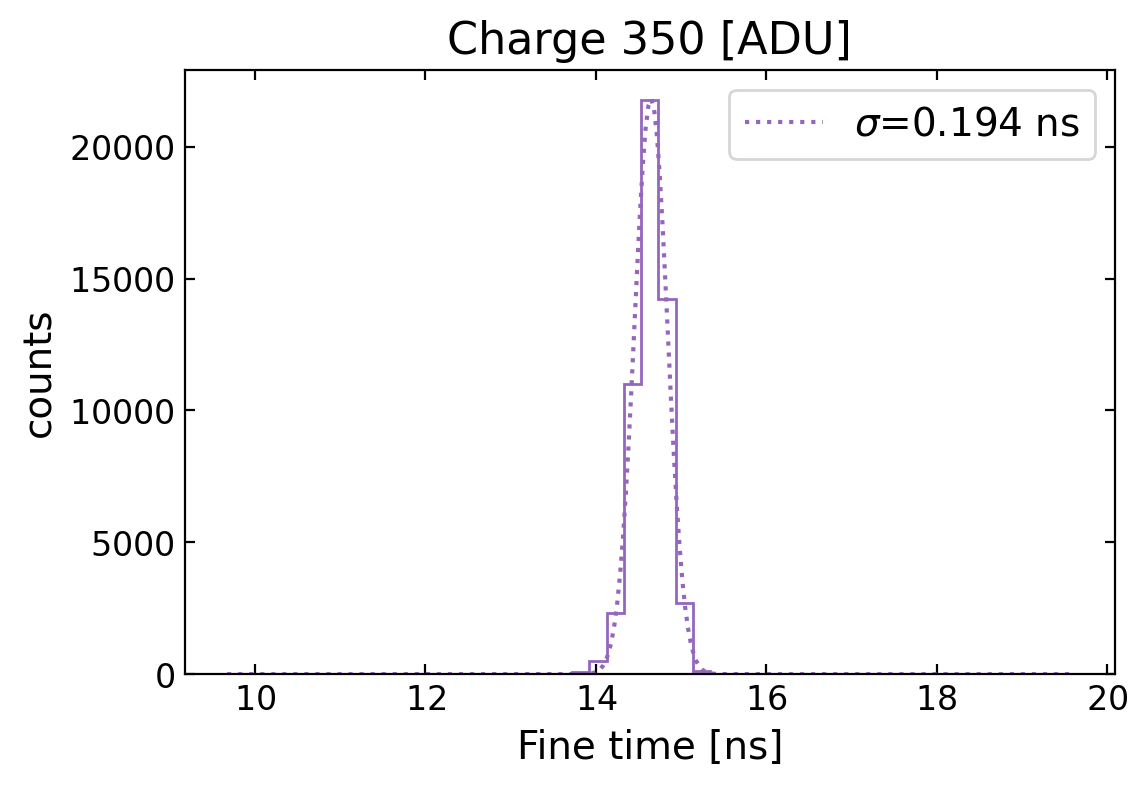

0.17809927902329362 [ns]


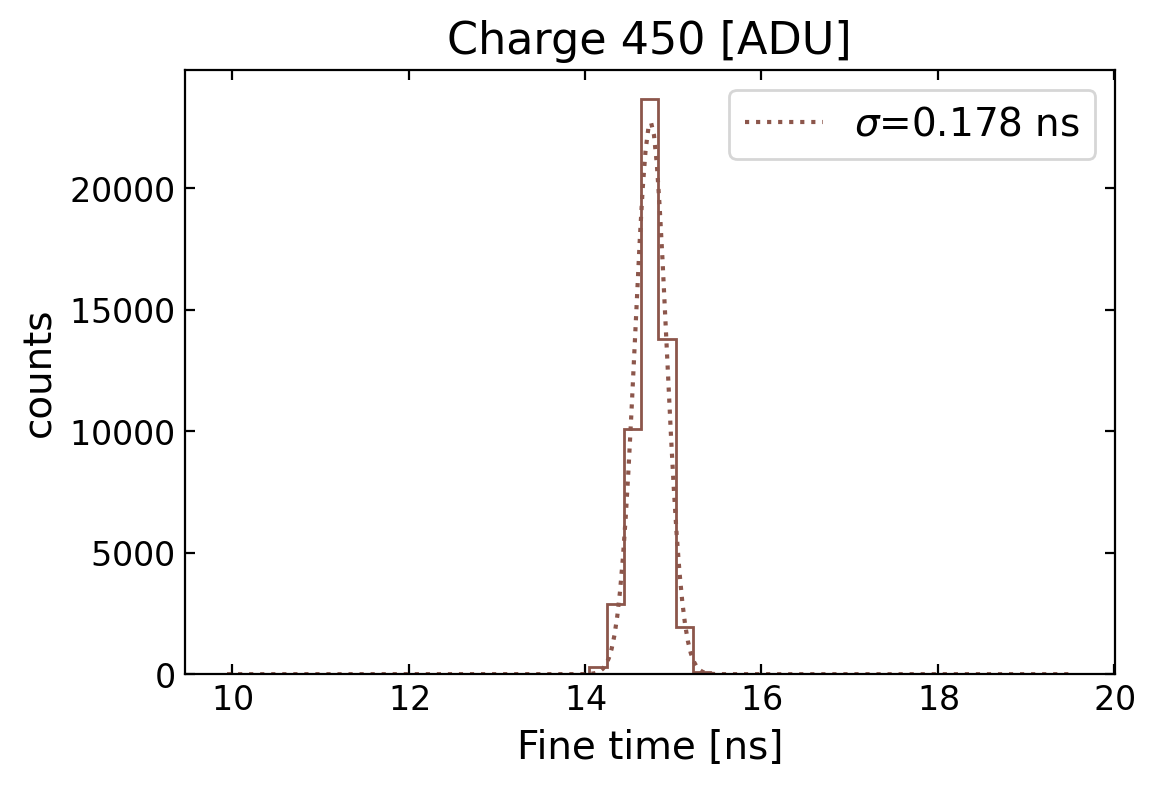

0.1702920091545566 [ns]


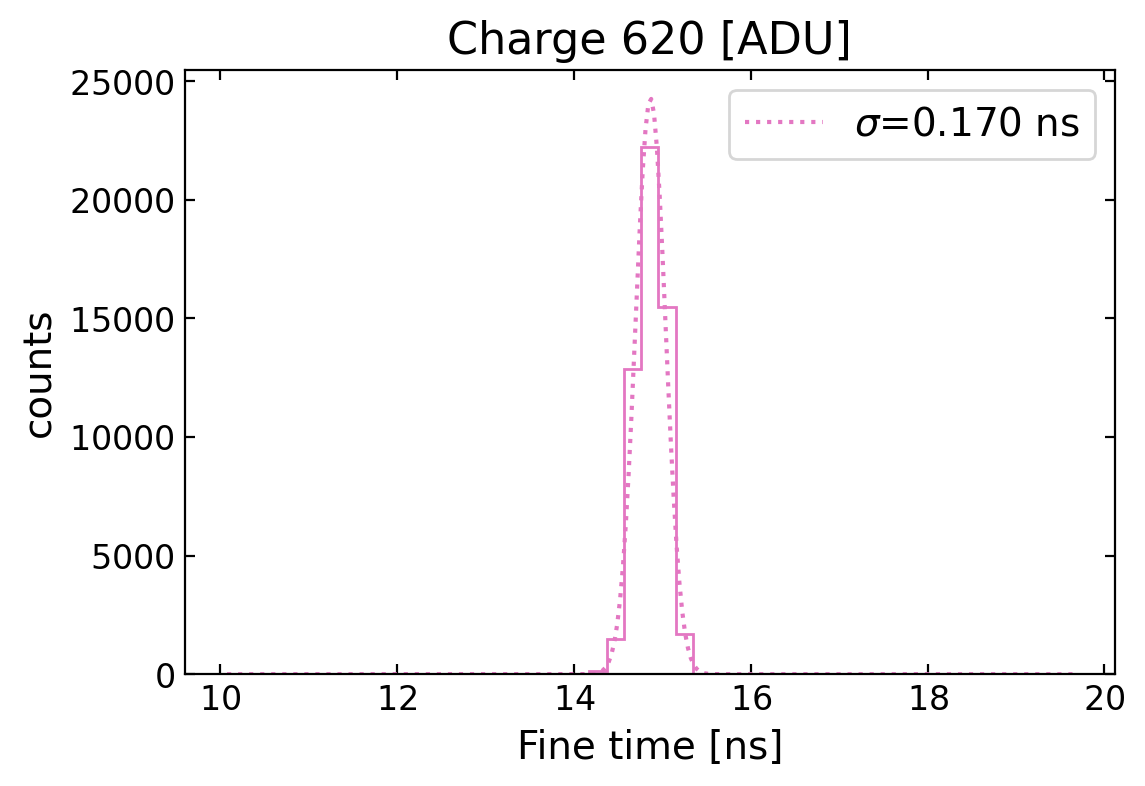

0.15500029731136858 [ns]


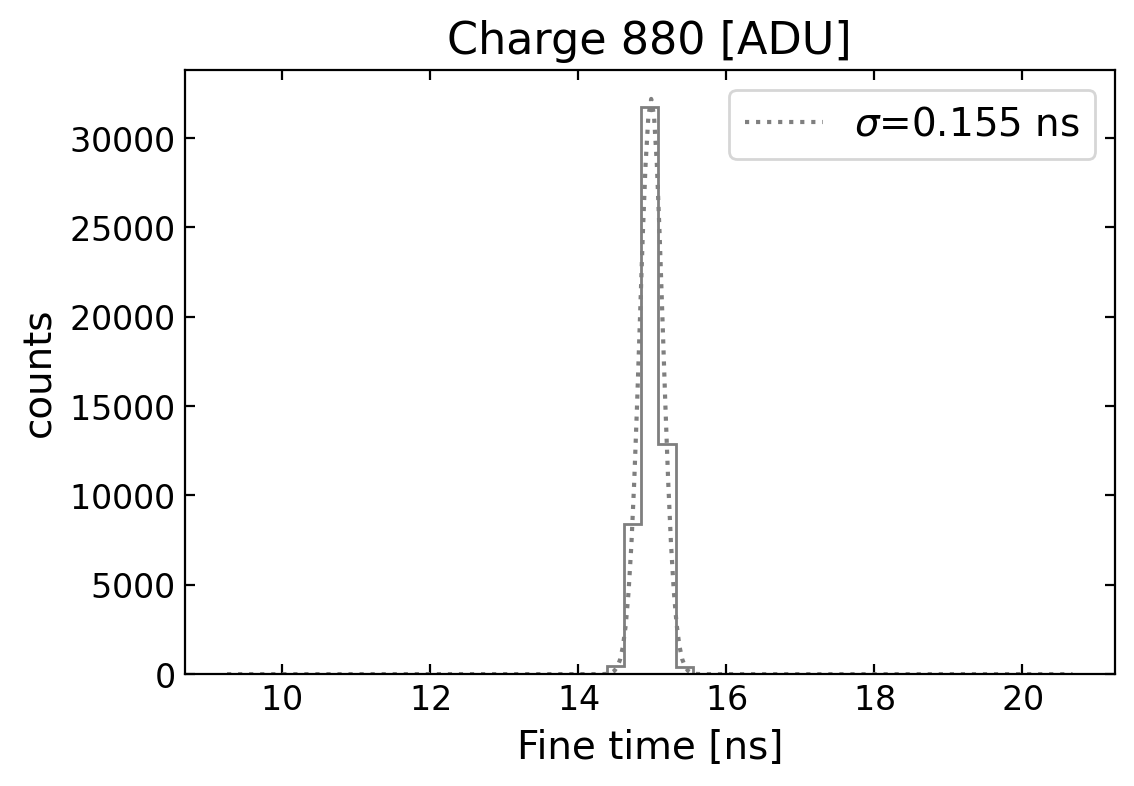

(0.0, 0.38966896019379166)

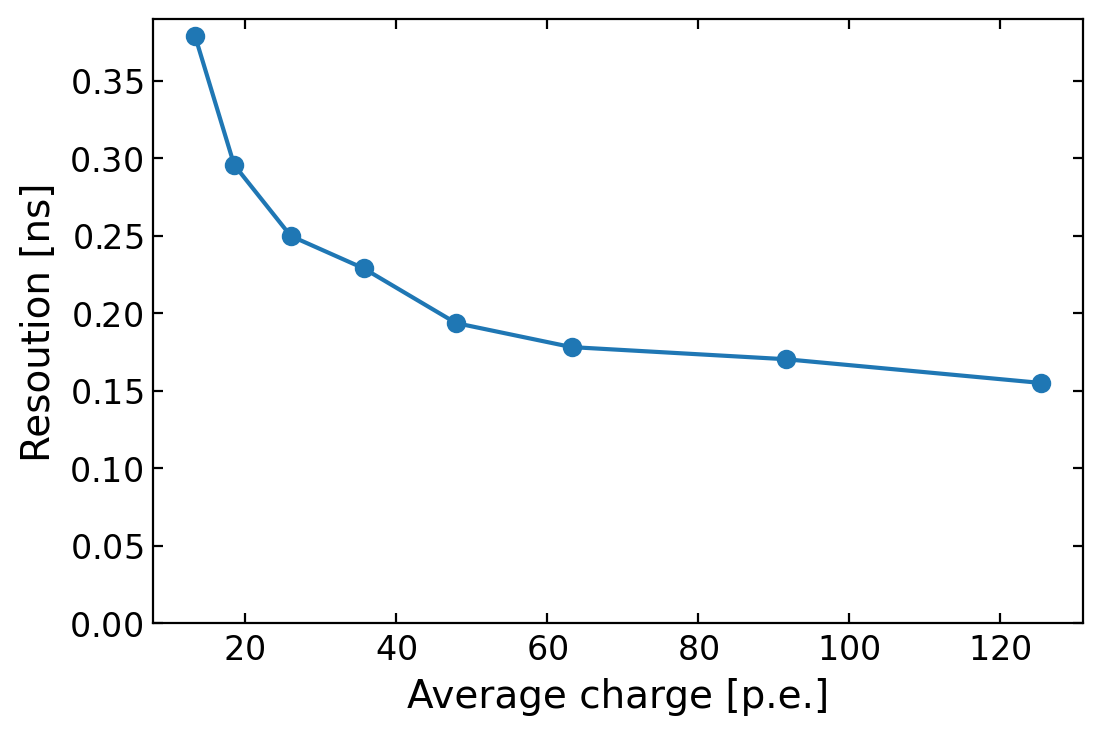

In [25]:
labels = [100, 150, 200, 250, 350, 450, 620, 880]
data_inds = np.array([101, 103, 105, 107, 109, 111, 113, 115])+1
bins=np.linspace(0,25,240)
ch="0"
normed=False

# Load all data
Data = []
for i, idata in enumerate(data_inds):
    data  = load_finetime(f"{DATA_DIR}/{idata}.data", ch =ch, ftime_min=ftime_min, ftime_max=ftime_max)
    Data.append(data)
    

resolutions_sipm = []
charges_sipm = []
for i, idata in enumerate(data_inds[:]):
    data  = Data[i]
    mask = (data[f"CHARGE_{ch}"]>75)#&(data[f"CHARGE_{ch}"]<125)
    popt, pcov = fit_finetime(data[f"FINE_calib_{ch}"][mask], color=f"C{i}");
    resolutions_sipm.append(popt[2])
    charges_sipm.append(np.mean(data[f"CHARGE_{ch}"][mask]-baseline)/peak_gap)


    xlabel("Fine time [ns]")
    ylabel("counts")
    # legend(fontsize=11,loc=[1.01,0])
    legend()
    # ylim(0,200)
    title(f"Charge {labels[i]} [ADU]")
    show()
    
plot(charges_sipm, resolutions_sipm,marker="o")
xlabel("Average charge [p.e.]")
ylabel("Resoution [ns]")
ylim(bottom=0)

In [26]:
# labels = np.array([100, 150, 200, 250, 350, 450, 620, 880])/peak_gap
# sigmas = [0.378, 0.296, 0.250, 0.229, 0.194, 0.178, 0.170, 0.155]
# plot(labels, sigmas, marker="o")
# xlabel("Average charge [p.e.]")
# ylabel("Resoution [ns]")
# ylim(bottom=0)

# Time resolution scan, SiPM+WLS

### Get finetime calibration with a different dataset:


In [27]:
filename = f"{DATA_DIR}/118.data"
data  = pd.read_csv(filename, sep=';', on_bad_lines  = "skip", usecols=["CHARGE_0", "FINE_0","RUN_EventTimecode_ns"])
ch="0"
ftime_min=np.min(data[f"FINE_{ch}"])
ftime_max=np.max(data[f"FINE_{ch}"])

0.6191497936834927 [ns]


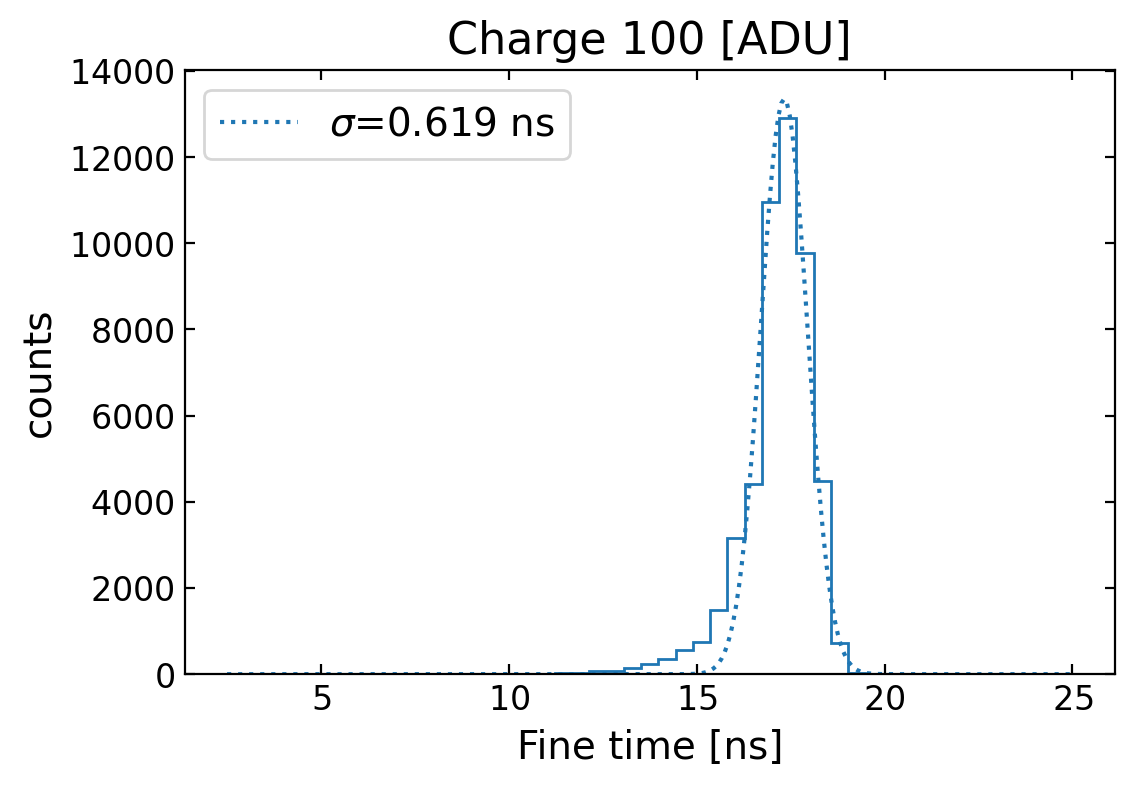

0.5191694864889069 [ns]


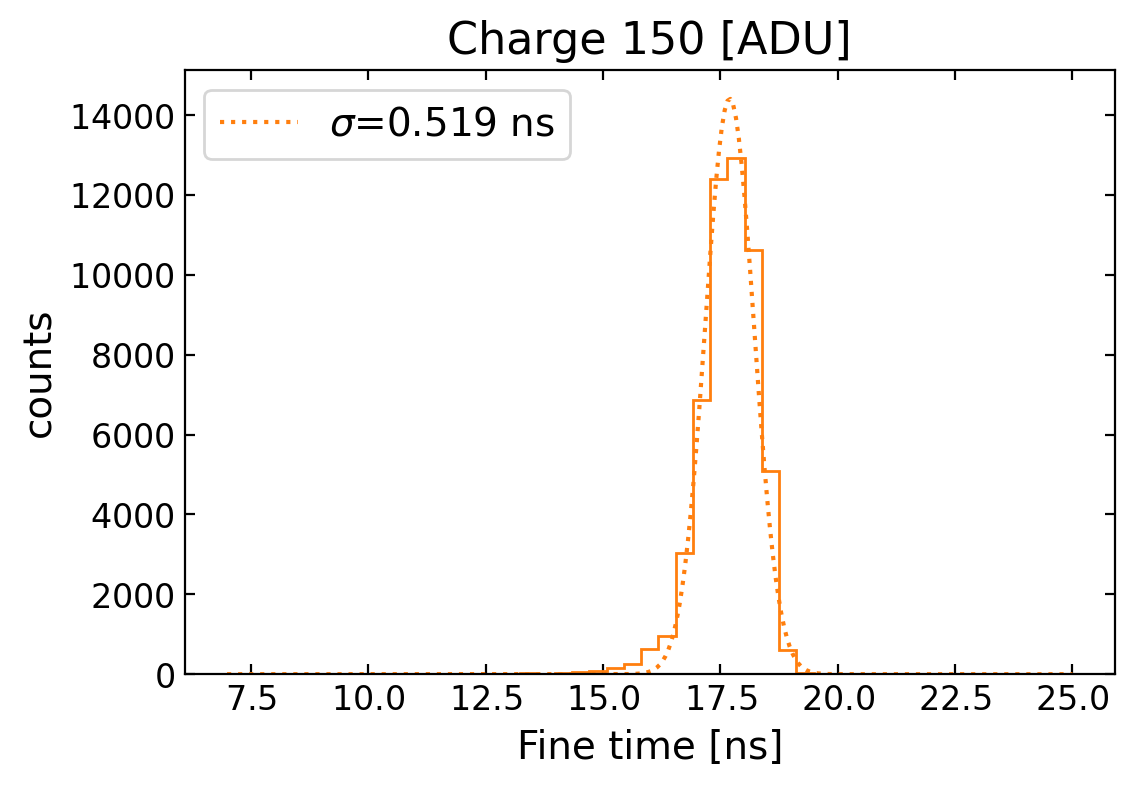

0.4507018940990152 [ns]


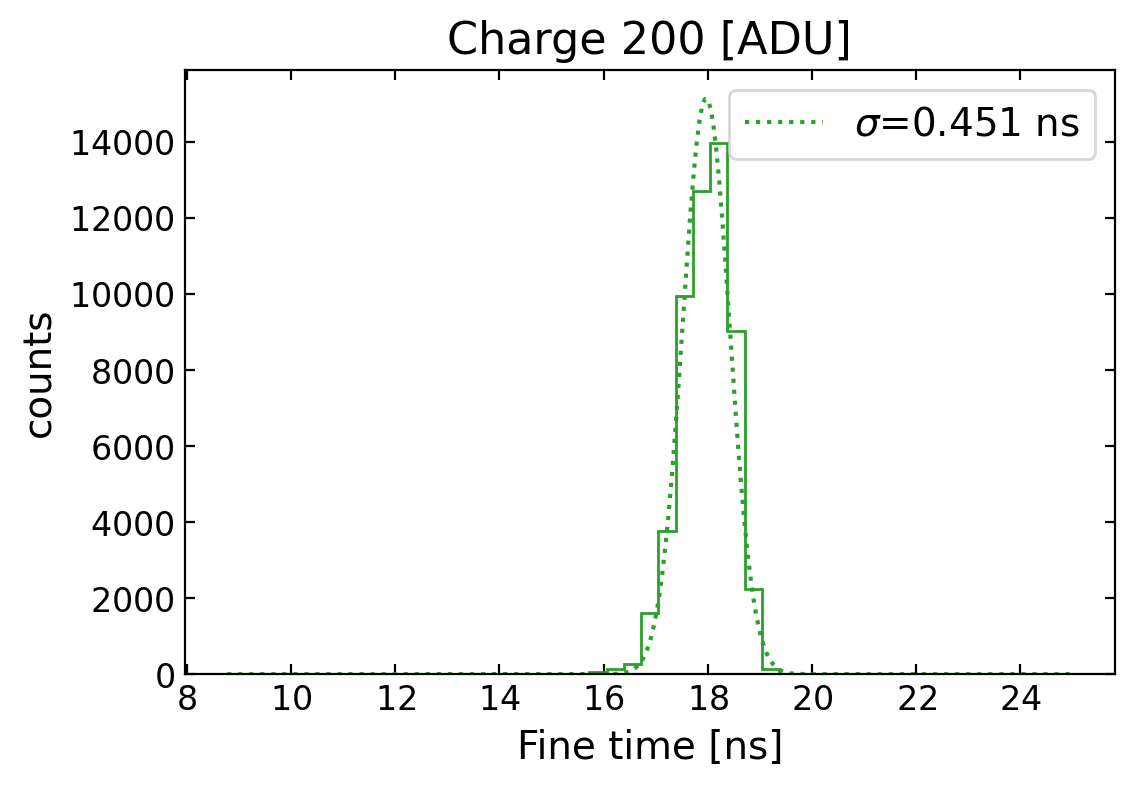

0.4086689974419056 [ns]


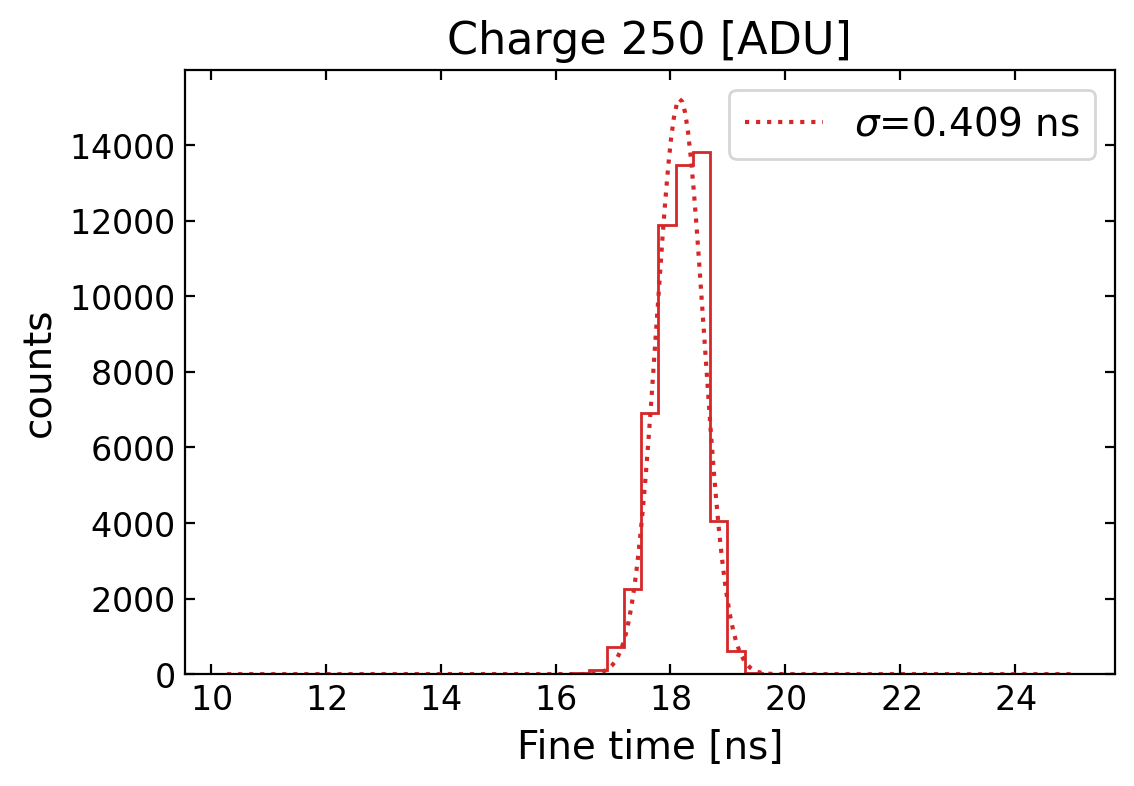

0.3722298961031482 [ns]


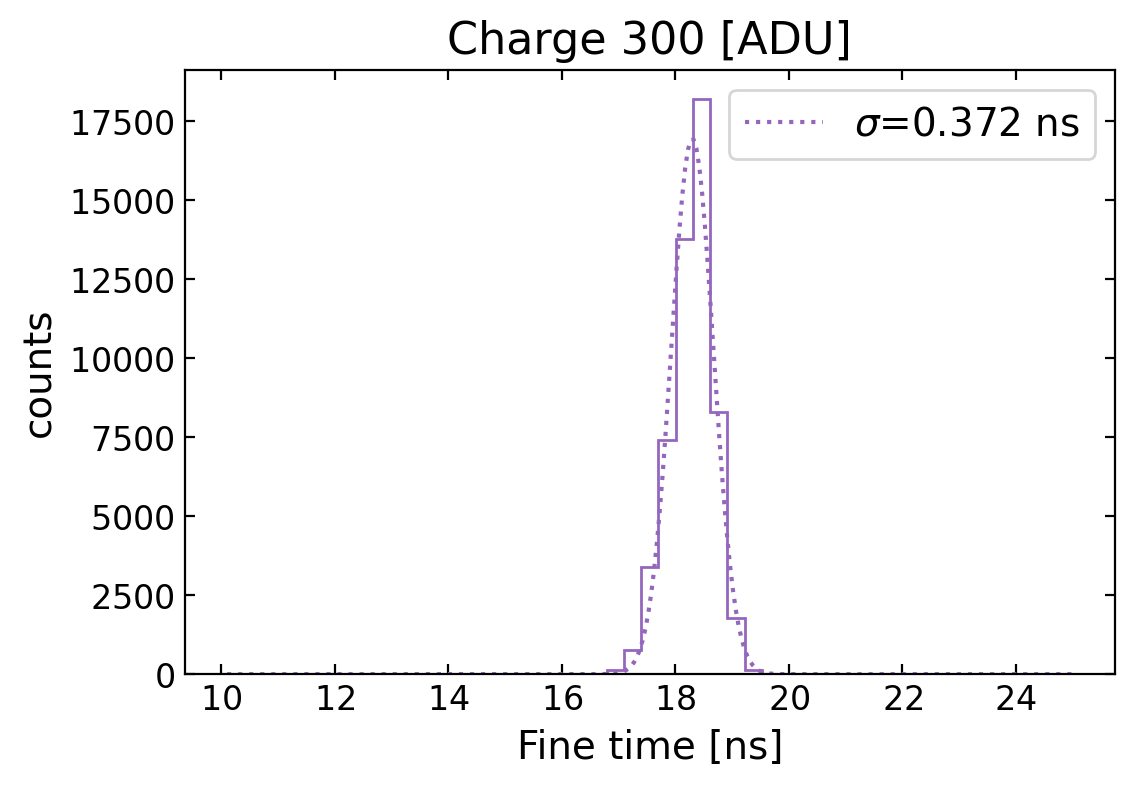

0.34172820789783365 [ns]


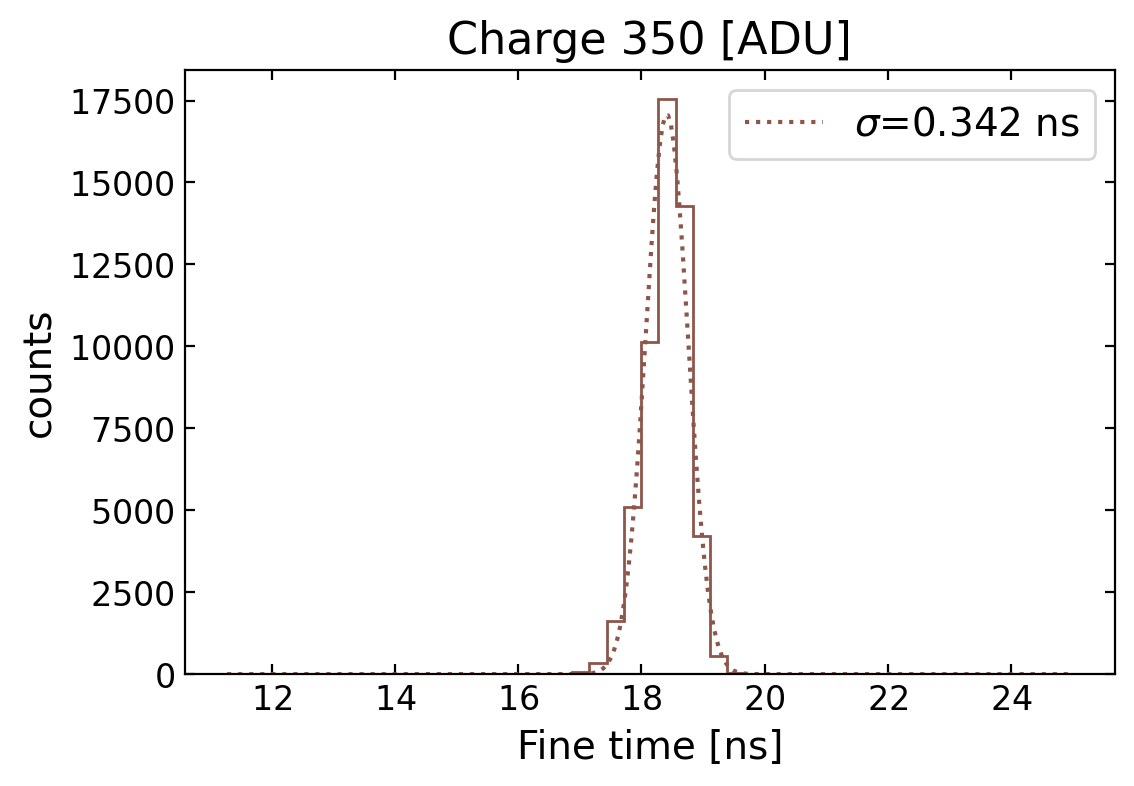

0.30519762896297126 [ns]


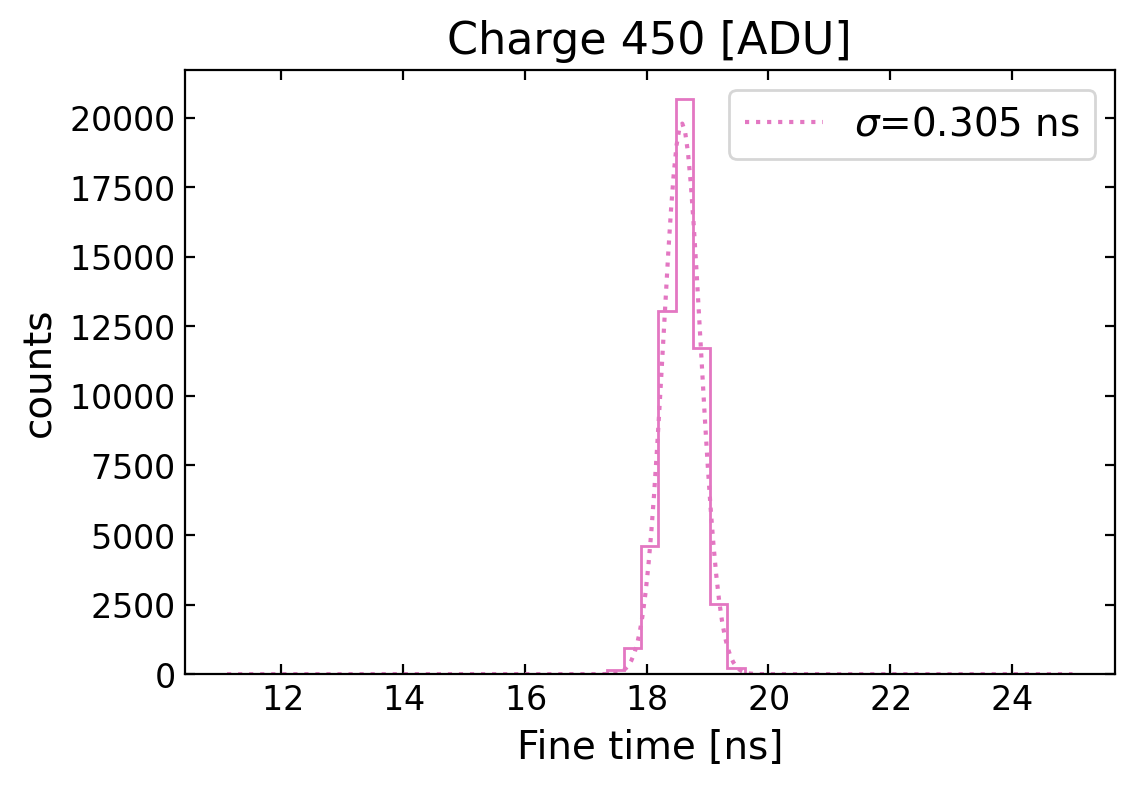

0.27165520080635247 [ns]


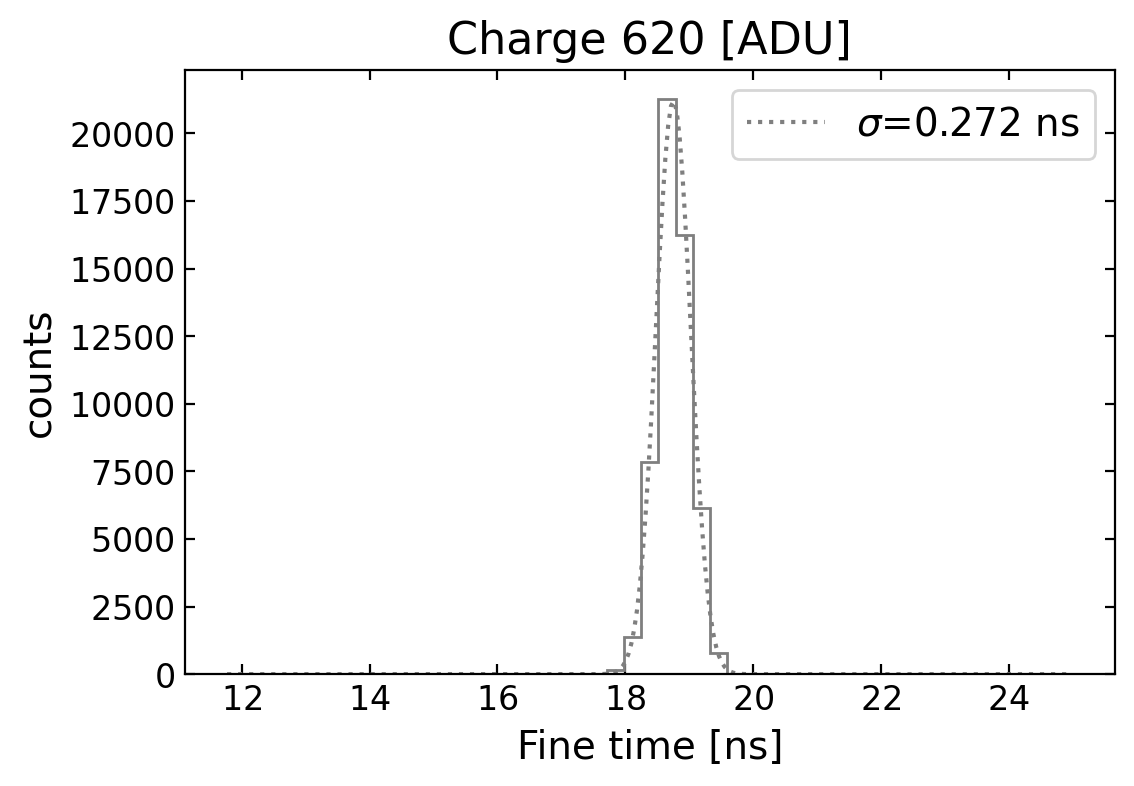

0.23869524834694414 [ns]


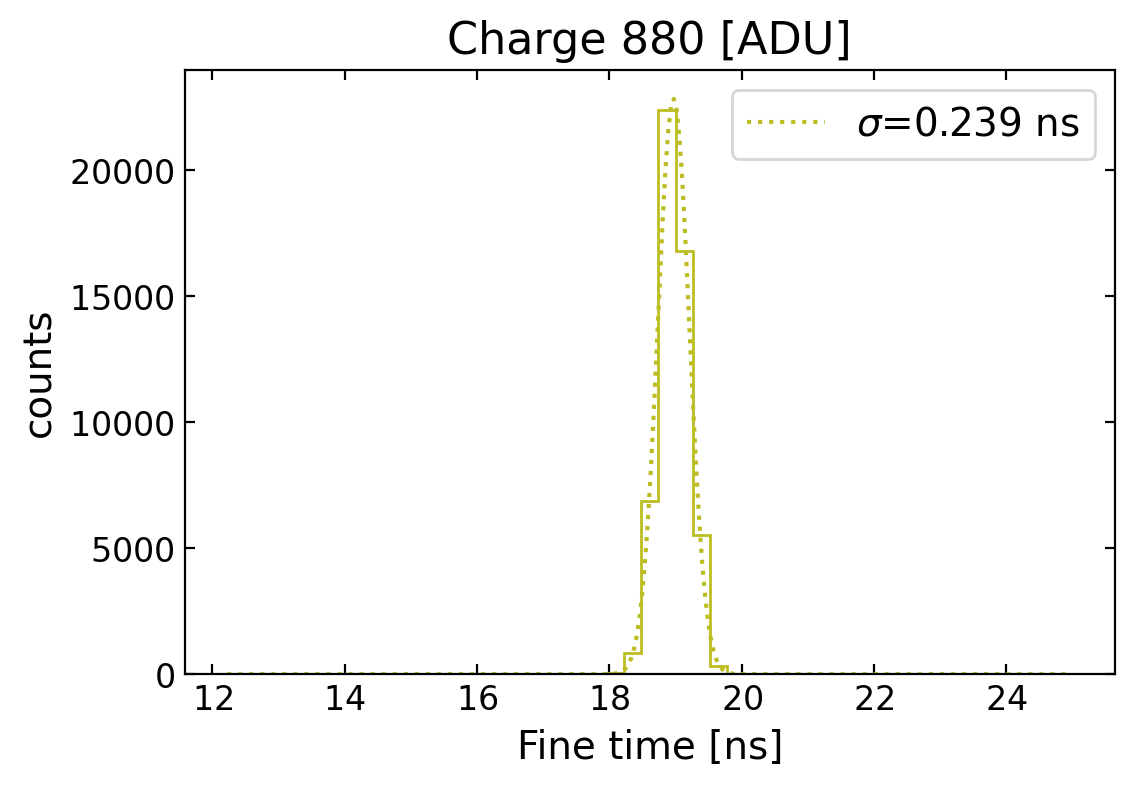

In [37]:
bins=np.linspace(0,25,240)
ch="0"
normed=False
charge_threshold=75

labels = [100, 150, 200, 250, 300, 350, 450, 620, 880]
data_inds = [122, 123,124, 125, 126, 127, 128, 129, 130]

# Load all data
Data = []
for i, idata in enumerate(data_inds):
    data  = load_finetime(f"{DATA_DIR}/{idata}.data", ch =ch, ftime_min=ftime_min, ftime_max=ftime_max)
    Data.append(data)
    

resolutions = []
charges = []
for i, idata in enumerate(data_inds[:]):
    data  = Data[i]
    mask = (data[f"CHARGE_{ch}"]>75)#&(data[f"CHARGE_{ch}"]<125)
    popt, pcov = fit_finetime(data[f"FINE_calib_{ch}"][mask], color=f"C{i}");
    resolutions.append(popt[2])
    charges.append(np.mean(data[f"CHARGE_{ch}"][mask]-baseline)/peak_gap)


    xlabel("Fine time [ns]")
    ylabel("counts")
    # legend(fontsize=11,loc=[1.01,0])
    legend()
    # ylim(0,200)
    title(f"Charge {labels[i]} [ADU]")
    show()
    

(0.0, 0.6423572685020988)

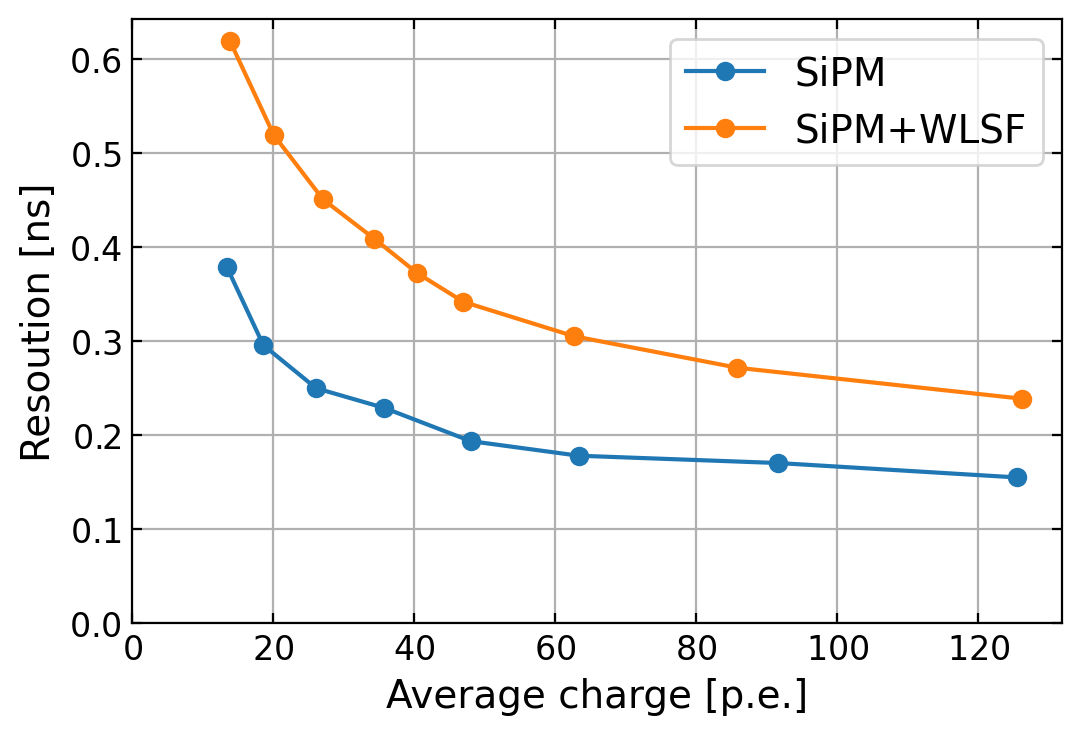

In [38]:
plot(charges_sipm, resolutions_sipm,marker="o",label="SiPM")
plot(charges, resolutions,marker="o",label="SiPM+WLSF")
xlabel("Average charge [p.e.]")
ylabel("Resoution [ns]")
legend()
grid()
xlim(0,)
ylim(0,)

# SiPM on adapter board

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


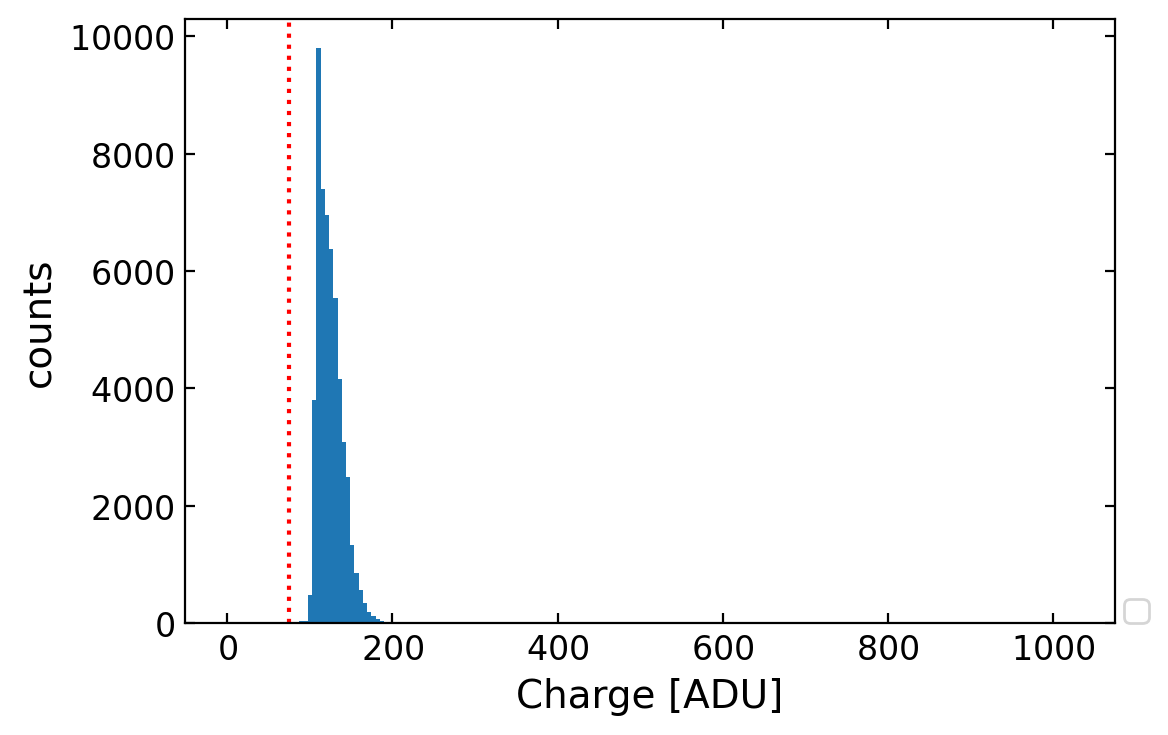

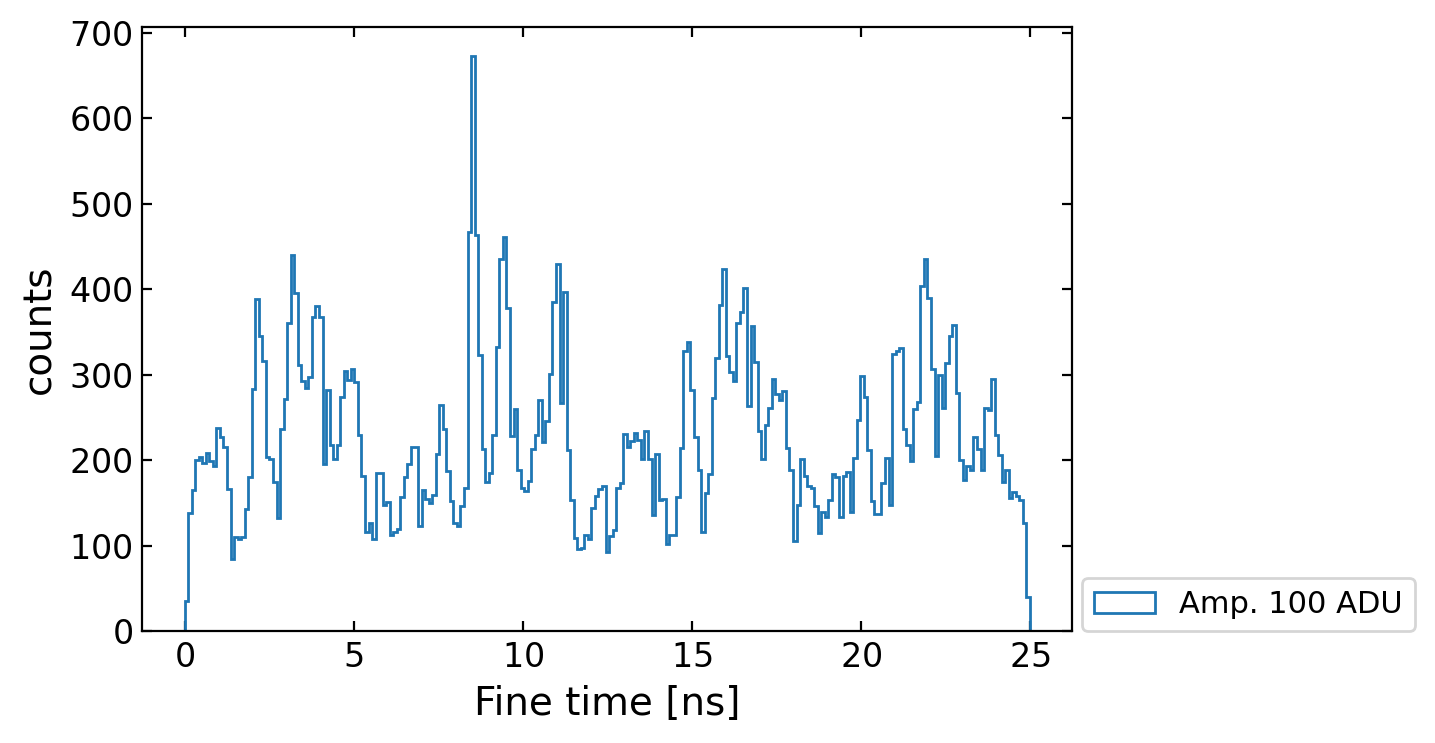

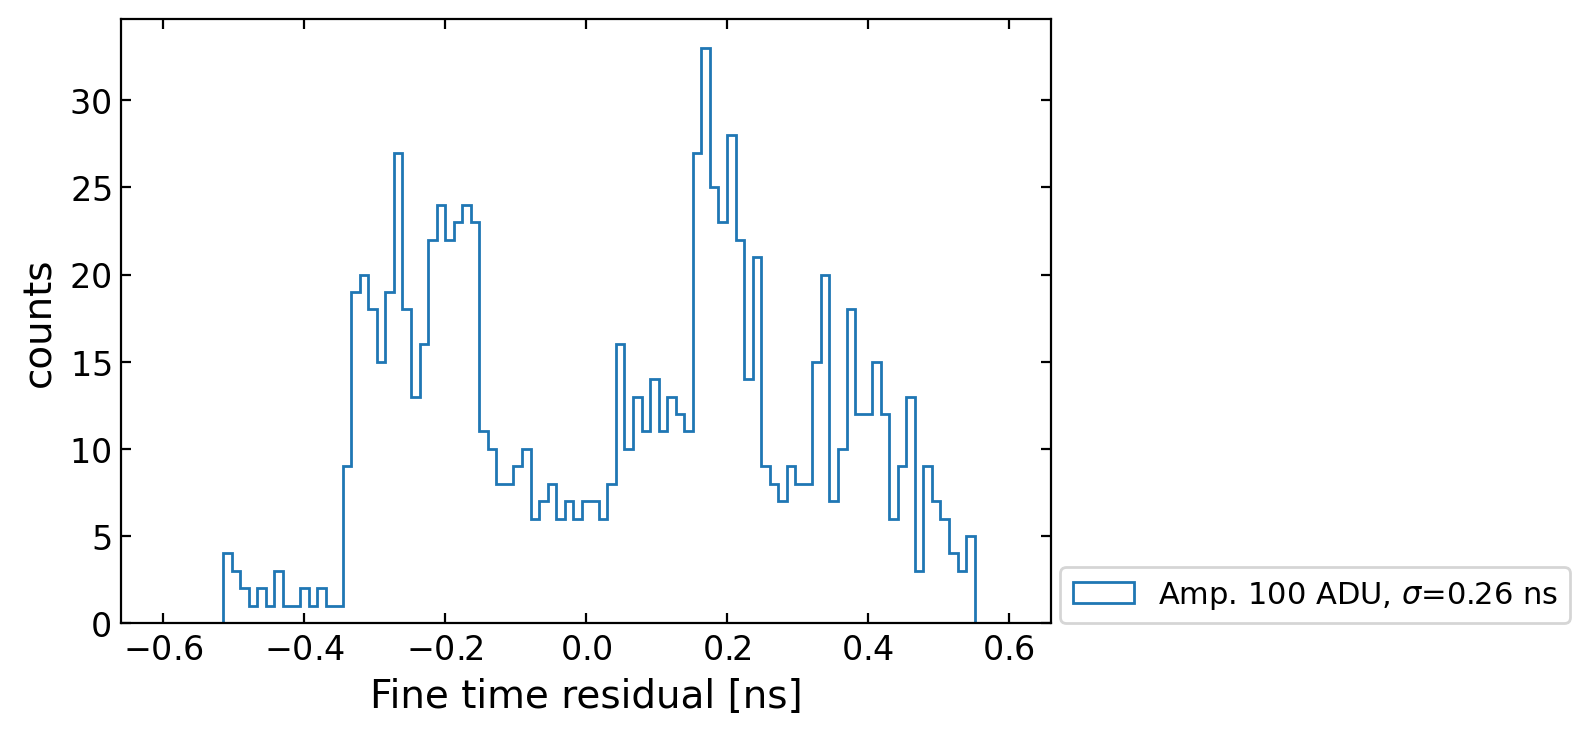

In [30]:
bins=np.linspace(0,25,240)
ch="20"
normed=False
charge_threshold=75

labels = [100, 150, 200, 250, 300, 350, 450, 620, 880]
data_inds = [132]


# Load all data
Data = []
for i, idata in enumerate(data_inds):
    data  = load_finetime(f"{DATA_DIR}/{idata}.data", ch =ch, ftime_min=None, ftime_max=None)
    Data.append(data)
    
    
    
# Plot Charge    
for i, idata in enumerate(data_inds):
    data=Data[i]
    n,ibins,_ = hist(data[f"CHARGE_{ch}"], bins=np.linspace(0,1023,200));
xlabel("Charge [ADU]")
ylabel("counts")
legend(fontsize=11,loc=[1.01,0])
# ylim(0,200)
axvline(charge_threshold, color="red", linestyle=":")
show()


# Plot finetime    
for i, idata in enumerate(data_inds):
    data=Data[i]
    mask = data[f"CHARGE_{ch}"]>charge_threshold
    n,ibins,_ = hist(data[f"FINE_calib_{ch}"][mask], bins=bins,label=f"Amp. {labels[i]} ADU", density=normed, histtype="step");
xlabel("Fine time [ns]")
ylabel("counts")
legend(fontsize=11,loc=[1.01,0])
# ylim(0,200)
show()



for i, idata in enumerate(data_inds):
    data=Data[i]
    mask = data[f"CHARGE_{ch}"]>charge_threshold
    residuals = process_inl(data[f"FINE_calib_{ch}"][mask])
    residuals_std = np.std(residuals)
    hist(residuals, bins=np.linspace(-0.6,0.6,100), histtype="step",label=f"Amp. {labels[i]} ADU, $\sigma$={residuals_std:.2f} ns");

xlabel("Fine time residual [ns]")
ylabel("counts")
legend(fontsize=11,loc=[1.01,0])
show()

0.2570778013681254 [ns]


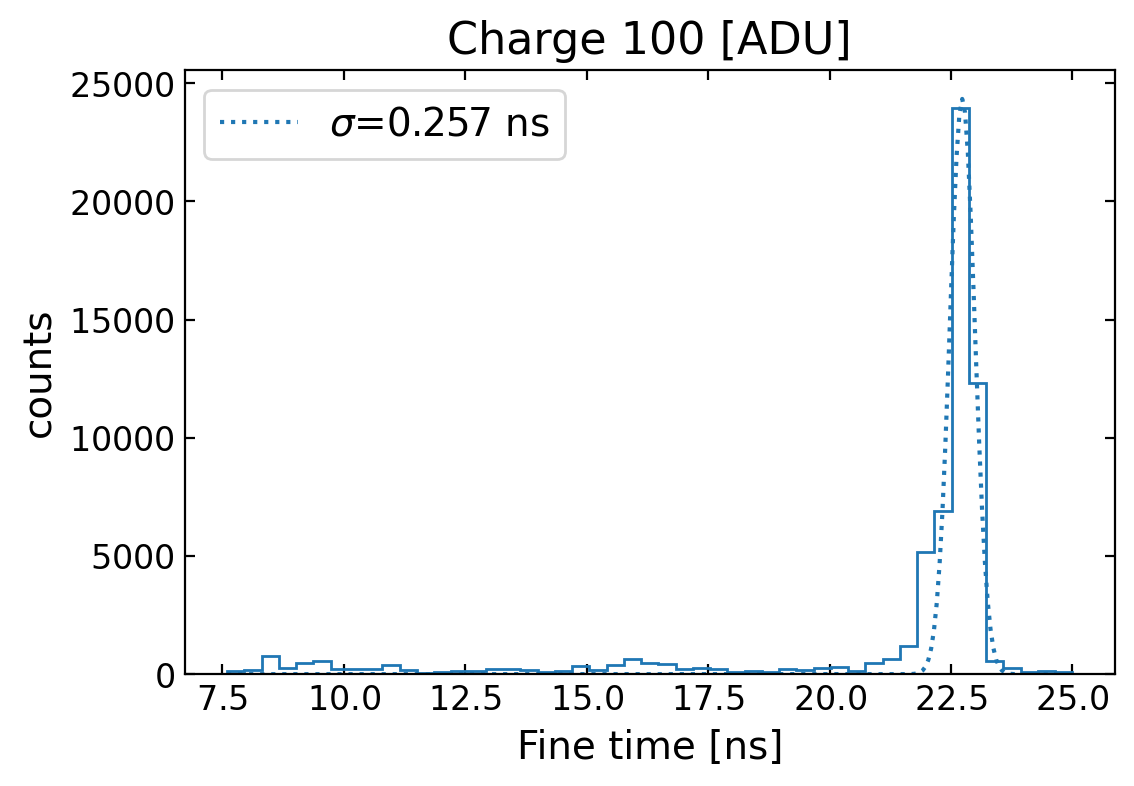

Average charge, 136.59367143867888


In [31]:
labels = [100, 150, 200, 250, 300, 350, 450, 620, 880]
data_inds = [133]

# Load all data
Data = []
for i, idata in enumerate(data_inds):
    data  = load_finetime(f"{DATA_DIR}/{idata}.data", ch =ch, ftime_min=None, ftime_max=None)
    Data.append(data)
    

for i, idata in enumerate(data_inds[:]):
    data  = Data[i]
    mask = (data[f"CHARGE_{ch}"]>75)#&(data[f"CHARGE_{ch}"]<125)
    # popt, pcov = fit_finetime(data[f"FINE_calib_{ch}"][mask], color=f"C{i}");
    
    
    ft_plot = data[f"FINE_calib_{ch}"][mask]
    color="C0"
    ft_mean = np.median(ft_plot)
    # ft_std = np.std(ft_plot)
    # ft_std = max([0.1,ft_std])
    ft_std = 1
    range_low = np.max([0, ft_mean-15*ft_std])
    range_high = np.min([25, ft_mean+15*ft_std])
    bins=np.linspace(range_low,range_high,50)
    bins_fit=np.linspace(range_low,range_high,300)
    # bins=np.linspace(5,14,60)

    n,ibins,_ = hist(ft_plot, bins=bins,label="", density=0, histtype="step", color=color);
    # n1,ibins,_ = hist(data[f"FINE_calib_{ch}"][data["CHARGE_0"]<threshold], bins=bins,label="Dark current", density=0, histtype="step");
    bincenters=0.5*(ibins[1:]+ibins[:-1])
    yerr=np.sqrt(n);yerr[yerr==0]=1

    popt1,pcov = rt.fit_tg(bincenters,n,yerr=yerr,function="gaus",fit_range=(ft_mean-5*ft_std,ft_mean+5*ft_std))
    perr1 = np.sqrt(np.diag(pcov))
    print(popt1[2],'[ns]')
    plot(bins_fit, util.Utils.Gauss(bins_fit,*popt1),color=color,linestyle=":",label=f"$\sigma$={popt1[2]:.3f} ns" )
    # plot(bincenters, util.Utils.Gauss(bincenters,*popt1),color="C0",label=f"$\sigma$={popt1[2]:.1f}$\pm${perr1[2]:.1f} \n "+r"$\bar{x}$"+f"={popt1[1]:.1f}$\pm${perr1[1]:.1f} "  )

    xlabel("Fine time [ns]")
    ylabel("Normalized counts")
    legend(fontsize=11)


    xlabel("Fine time [ns]")
    ylabel("counts")
    # legend(fontsize=11,loc=[1.01,0])
    legend()
    # ylim(0,200)
    title(f"Charge {labels[i]} [ADU]")
    show()
    
    
    print("Average charge,",np.mean(data[f"CHARGE_{ch}"]))

# Mini coax cable

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


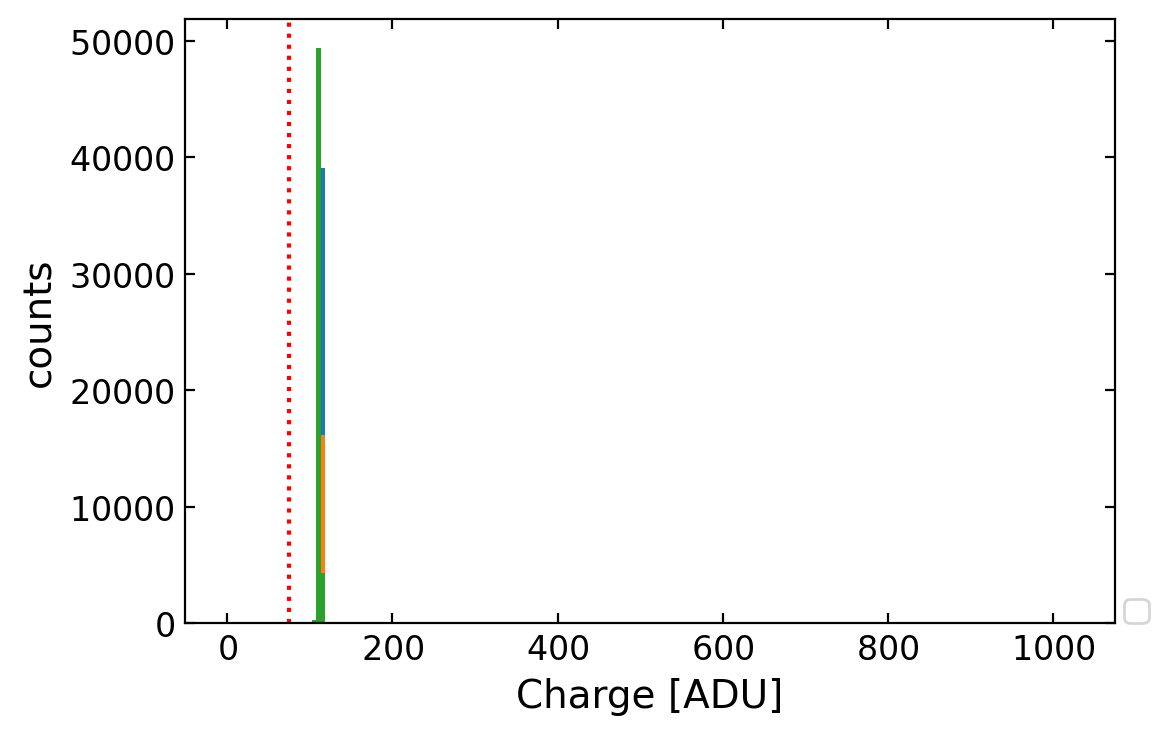

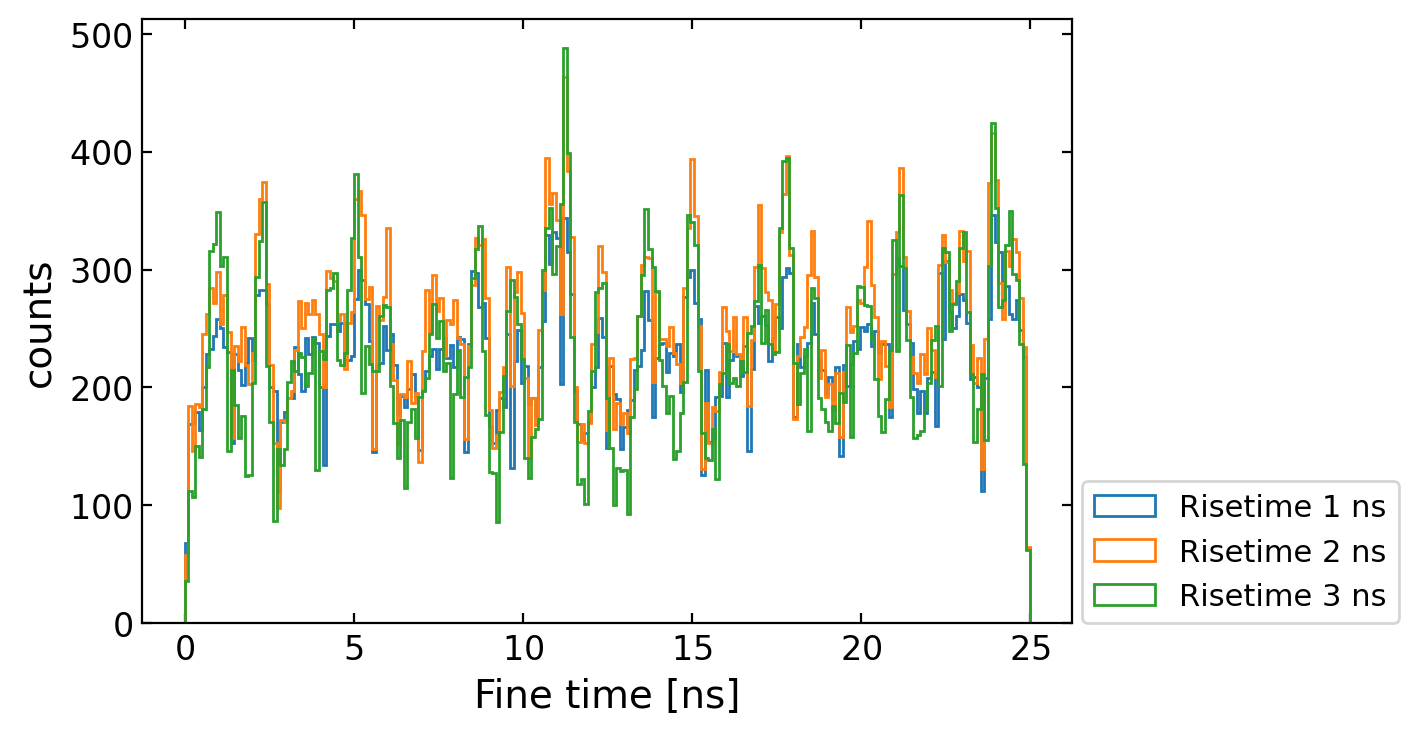

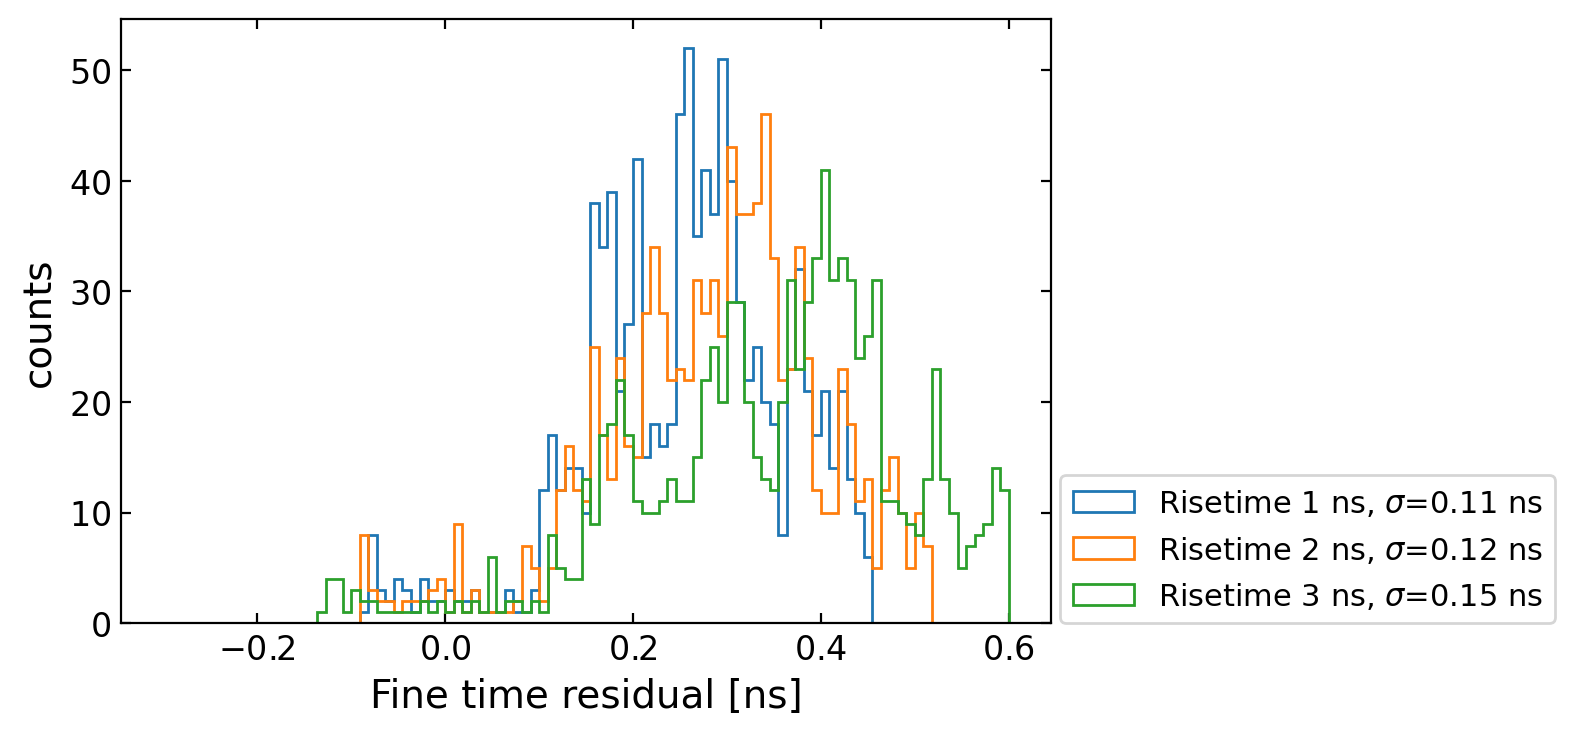

In [32]:
# Amplitude 50 mV
bins=np.linspace(0,25,240)
ch="16"
normed=False
charge_threshold=75

labels = [1,2,3]
data_inds = [134,135,136]


# Load all data
Data = []
for i, idata in enumerate(data_inds):
    data  = load_finetime(f"{DATA_DIR}/{idata}.data", ch =ch, ftime_min=None, ftime_max=None)
    Data.append(data)
    
    
    
# Plot Charge    
for i, idata in enumerate(data_inds):
    data=Data[i]
    n,ibins,_ = hist(data[f"CHARGE_{ch}"], bins=np.linspace(0,1023,200));
xlabel("Charge [ADU]")
ylabel("counts")
legend(fontsize=11,loc=[1.01,0])
# ylim(0,200)
axvline(charge_threshold, color="red", linestyle=":")
show()


# Plot finetime    
for i, idata in enumerate(data_inds):
    data=Data[i]
    mask = data[f"CHARGE_{ch}"]>charge_threshold
    n,ibins,_ = hist(data[f"FINE_calib_{ch}"][mask], bins=bins,label=f"Risetime {labels[i]} ns", density=normed, histtype="step");
xlabel("Fine time [ns]")
ylabel("counts")
legend(fontsize=11,loc=[1.01,0])
# ylim(0,200)
show()



for i, idata in enumerate(data_inds):
    data=Data[i]
    mask = data[f"CHARGE_{ch}"]>charge_threshold
    residuals = process_inl(data[f"FINE_calib_{ch}"][mask])
    residuals_std = np.std(residuals)
    hist(residuals, bins=np.linspace(-0.3,0.6,100), histtype="step",label=f"Risetime {labels[i]} ns, $\sigma$={residuals_std:.2f} ns");

xlabel("Fine time residual [ns]")
ylabel("counts")
legend(fontsize=11,loc=[1.01,0])
show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


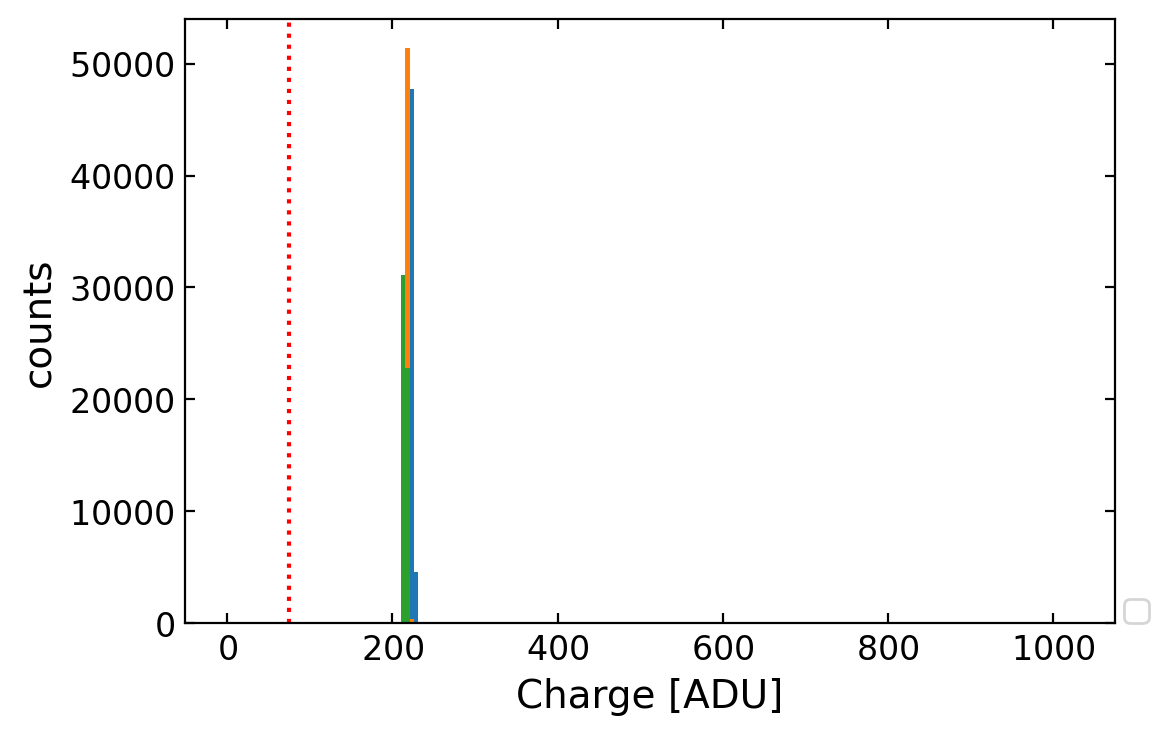

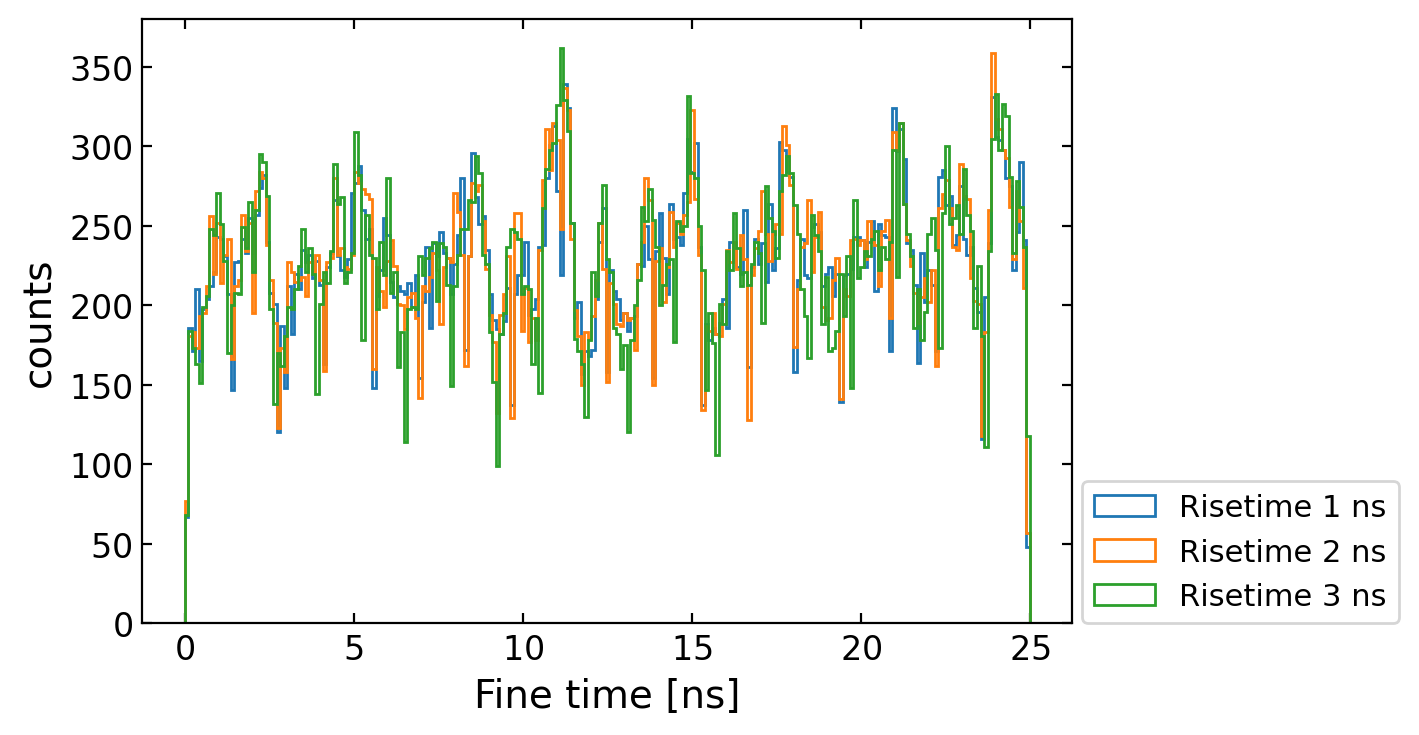

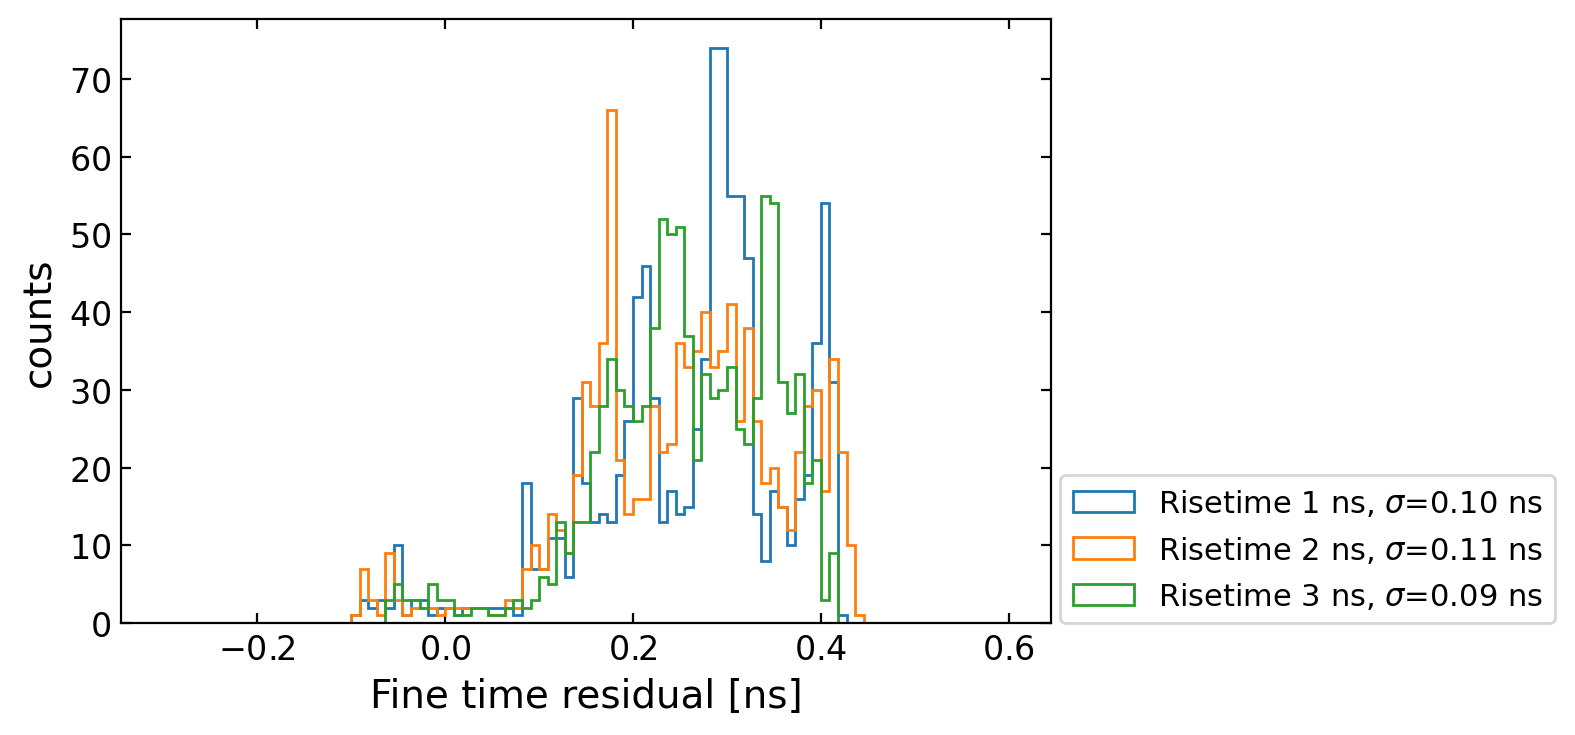

In [33]:
# Amplitude 200 mV
bins=np.linspace(0,25,240)
ch="16"
normed=False
charge_threshold=75

labels = [1,2,3]
data_inds = [137,138,139]


# Load all data
Data = []
for i, idata in enumerate(data_inds):
    data  = load_finetime(f"{DATA_DIR}/{idata}.data", ch =ch, ftime_min=None, ftime_max=None)
    Data.append(data)
    
    
    
# Plot Charge    
for i, idata in enumerate(data_inds):
    data=Data[i]
    n,ibins,_ = hist(data[f"CHARGE_{ch}"], bins=np.linspace(0,1023,200));
xlabel("Charge [ADU]")
ylabel("counts")
legend(fontsize=11,loc=[1.01,0])
# ylim(0,200)
axvline(charge_threshold, color="red", linestyle=":")
show()


# Plot finetime    
for i, idata in enumerate(data_inds):
    data=Data[i]
    mask = data[f"CHARGE_{ch}"]>charge_threshold
    n,ibins,_ = hist(data[f"FINE_calib_{ch}"][mask], bins=bins,label=f"Risetime {labels[i]} ns", density=normed, histtype="step");
xlabel("Fine time [ns]")
ylabel("counts")
legend(fontsize=11,loc=[1.01,0])
# ylim(0,200)
show()



for i, idata in enumerate(data_inds):
    data=Data[i]
    mask = data[f"CHARGE_{ch}"]>charge_threshold
    residuals = process_inl(data[f"FINE_calib_{ch}"][mask])
    residuals_std = np.std(residuals)
    hist(residuals, bins=np.linspace(-0.3,0.6,100), histtype="step",label=f"Risetime {labels[i]} ns, $\sigma$={residuals_std:.2f} ns");

xlabel("Fine time residual [ns]")
ylabel("counts")
legend(fontsize=11,loc=[1.01,0])
show()

# Two coax in series

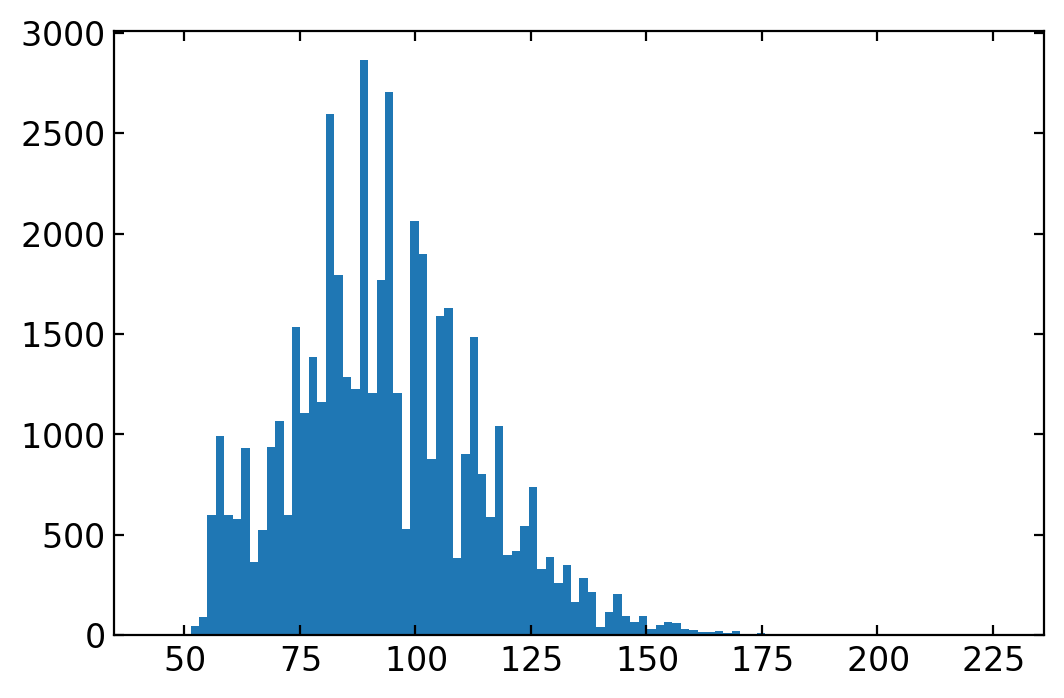

0.5226034241615819 [ns]


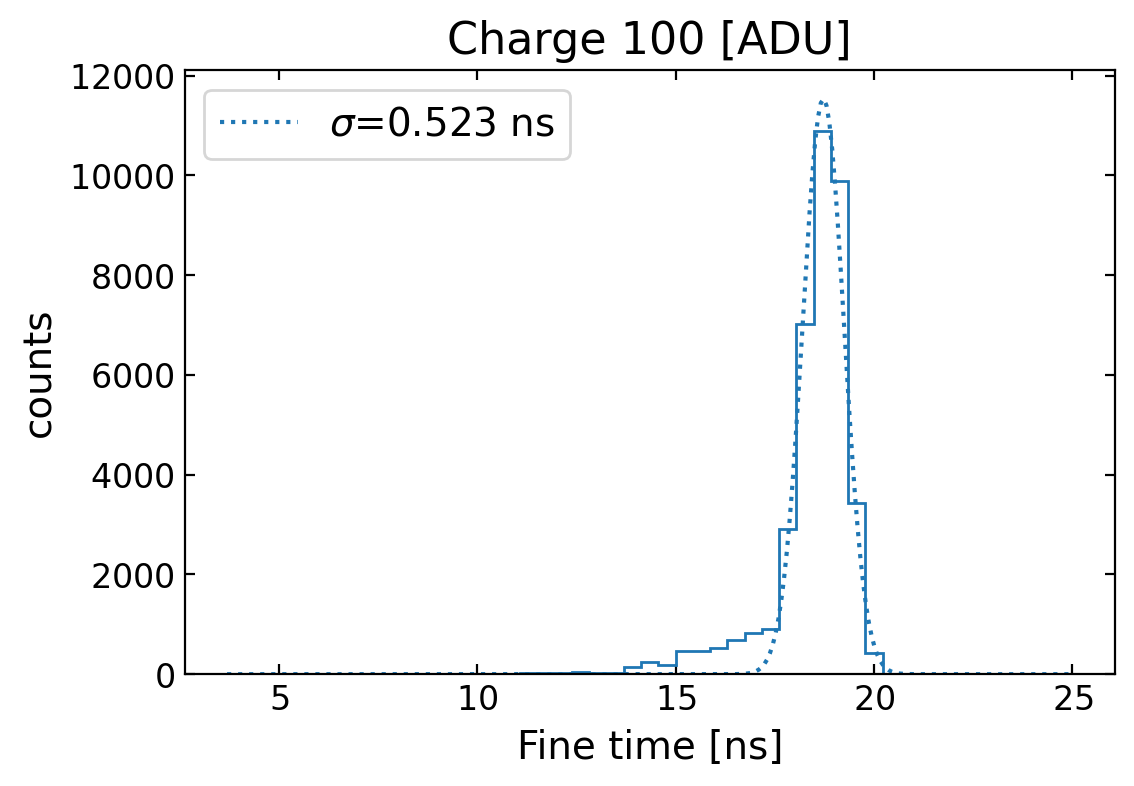

Average charge, 93.50305524379598


In [14]:
labels = [100, 150, 200, 250, 300, 350, 450, 620, 880]
data_inds = [161]

bins=np.linspace(0,25,240)
ch="16"
normed=False
charge_threshold=75

# Load all data
Data = []
for i, idata in enumerate(data_inds):
    data  = load_finetime(f"{DATA_DIR}/{idata}.data", ch =ch, ftime_min=None, ftime_max=None)
    Data.append(data)
    
    
hist(data[f"CHARGE_{ch}"]);
show()
    

for i, idata in enumerate(data_inds[:]):
    data  = Data[i]
    mask = (data[f"CHARGE_{ch}"]>75)#&(data[f"CHARGE_{ch}"]<125)
    # popt, pcov = fit_finetime(data[f"FINE_calib_{ch}"][mask], color=f"C{i}");
    
    
    ft_plot = data[f"FINE_calib_{ch}"][mask]
    color="C0"
    ft_mean = np.median(ft_plot)
    # ft_std = np.std(ft_plot)
    # ft_std = max([0.1,ft_std])
    ft_std = 1
    range_low = np.max([0, ft_mean-15*ft_std])
    range_high = np.min([25, ft_mean+15*ft_std])
    bins=np.linspace(range_low,range_high,50)
    bins_fit=np.linspace(range_low,range_high,300)
    # bins=np.linspace(5,14,60)

    n,ibins,_ = hist(ft_plot, bins=bins,label="", density=0, histtype="step", color=color);
    # n1,ibins,_ = hist(data[f"FINE_calib_{ch}"][data["CHARGE_0"]<threshold], bins=bins,label="Dark current", density=0, histtype="step");
    bincenters=0.5*(ibins[1:]+ibins[:-1])
    yerr=np.sqrt(n);yerr[yerr==0]=1

    popt1,pcov = rt.fit_tg(bincenters,n,yerr=yerr,function="gaus",fit_range=(ft_mean-5*ft_std,ft_mean+5*ft_std))
    perr1 = np.sqrt(np.diag(pcov))
    print(popt1[2],'[ns]')
    plot(bins_fit, util.Utils.Gauss(bins_fit,*popt1),color=color,linestyle=":",label=f"$\sigma$={popt1[2]:.3f} ns" )
    # plot(bincenters, util.Utils.Gauss(bincenters,*popt1),color="C0",label=f"$\sigma$={popt1[2]:.1f}$\pm${perr1[2]:.1f} \n "+r"$\bar{x}$"+f"={popt1[1]:.1f}$\pm${perr1[1]:.1f} "  )

    xlabel("Fine time [ns]")
    ylabel("Normalized counts")
    legend(fontsize=11)


    xlabel("Fine time [ns]")
    ylabel("counts")
    # legend(fontsize=11,loc=[1.01,0])
    legend()
    # ylim(0,200)
    title(f"Charge {labels[i]} [ADU]")
    show()
    
    
    print("Average charge,",np.mean(data[f"CHARGE_{ch}"]))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


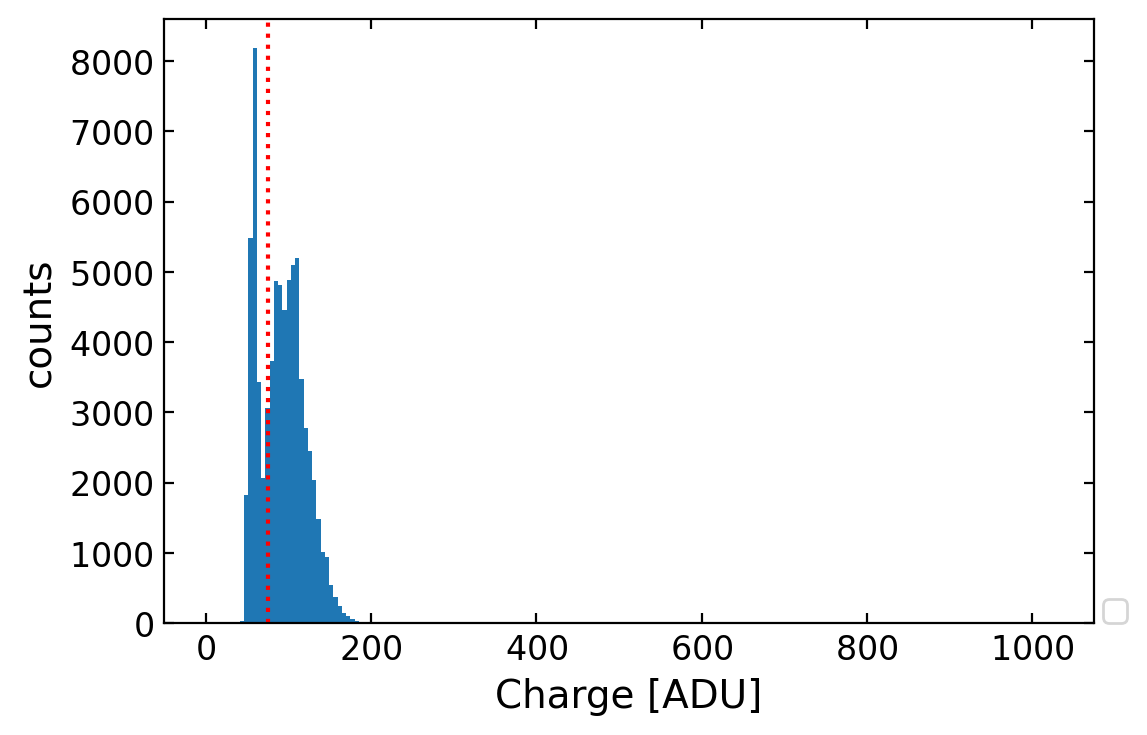

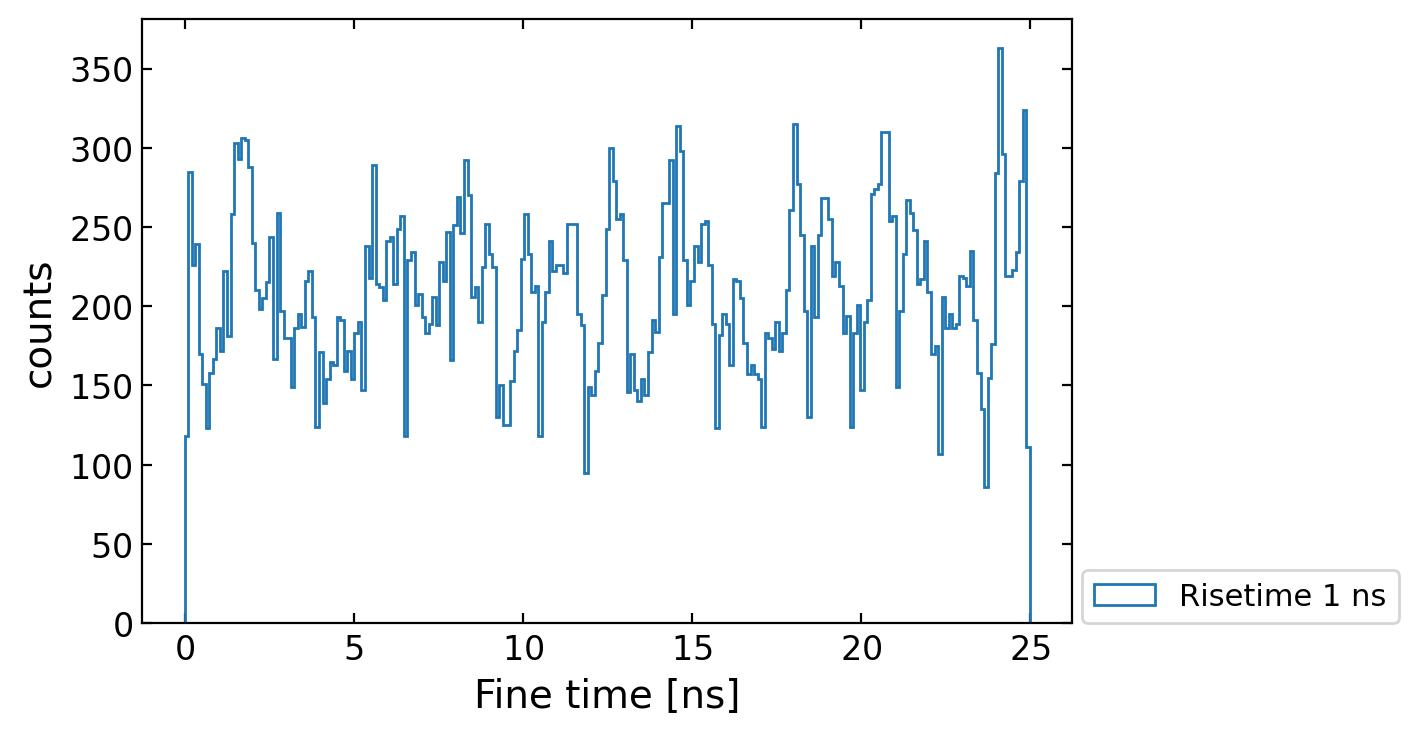

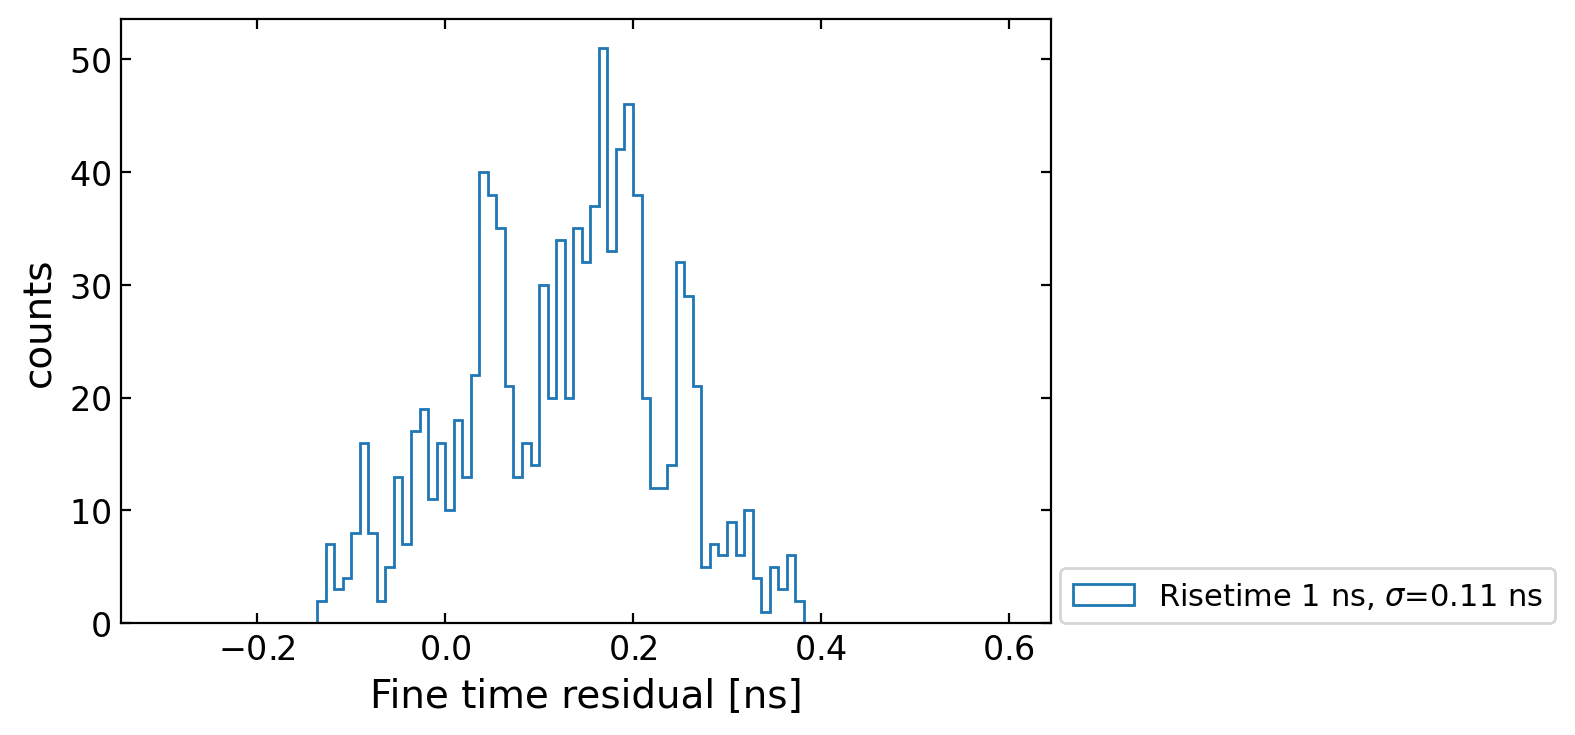

In [34]:
# Amplitude 200 mV
bins=np.linspace(0,25,240)
ch="16"
normed=False
charge_threshold=75

labels = [1,2,3]
data_inds = [140]


# Load all data
Data = []
for i, idata in enumerate(data_inds):
    data  = load_finetime(f"{DATA_DIR}/{idata}.data", ch =ch, ftime_min=None, ftime_max=None)
    Data.append(data)
    
    
    
# Plot Charge    
for i, idata in enumerate(data_inds):
    data=Data[i]
    n,ibins,_ = hist(data[f"CHARGE_{ch}"], bins=np.linspace(0,1023,200));
xlabel("Charge [ADU]")
ylabel("counts")
legend(fontsize=11,loc=[1.01,0])
# ylim(0,200)
axvline(charge_threshold, color="red", linestyle=":")
show()


# Plot finetime    
for i, idata in enumerate(data_inds):
    data=Data[i]
    mask = data[f"CHARGE_{ch}"]>charge_threshold
    n,ibins,_ = hist(data[f"FINE_calib_{ch}"][mask], bins=bins,label=f"Risetime {labels[i]} ns", density=normed, histtype="step");
xlabel("Fine time [ns]")
ylabel("counts")
legend(fontsize=11,loc=[1.01,0])
# ylim(0,200)
show()



for i, idata in enumerate(data_inds):
    data=Data[i]
    mask = data[f"CHARGE_{ch}"]>charge_threshold
    residuals = process_inl(data[f"FINE_calib_{ch}"][mask])
    residuals_std = np.std(residuals)
    hist(residuals, bins=np.linspace(-0.3,0.6,100), histtype="step",label=f"Risetime {labels[i]} ns, $\sigma$={residuals_std:.2f} ns");

xlabel("Fine time residual [ns]")
ylabel("counts")
legend(fontsize=11,loc=[1.01,0])
show()

0.5845211670966874 [ns]


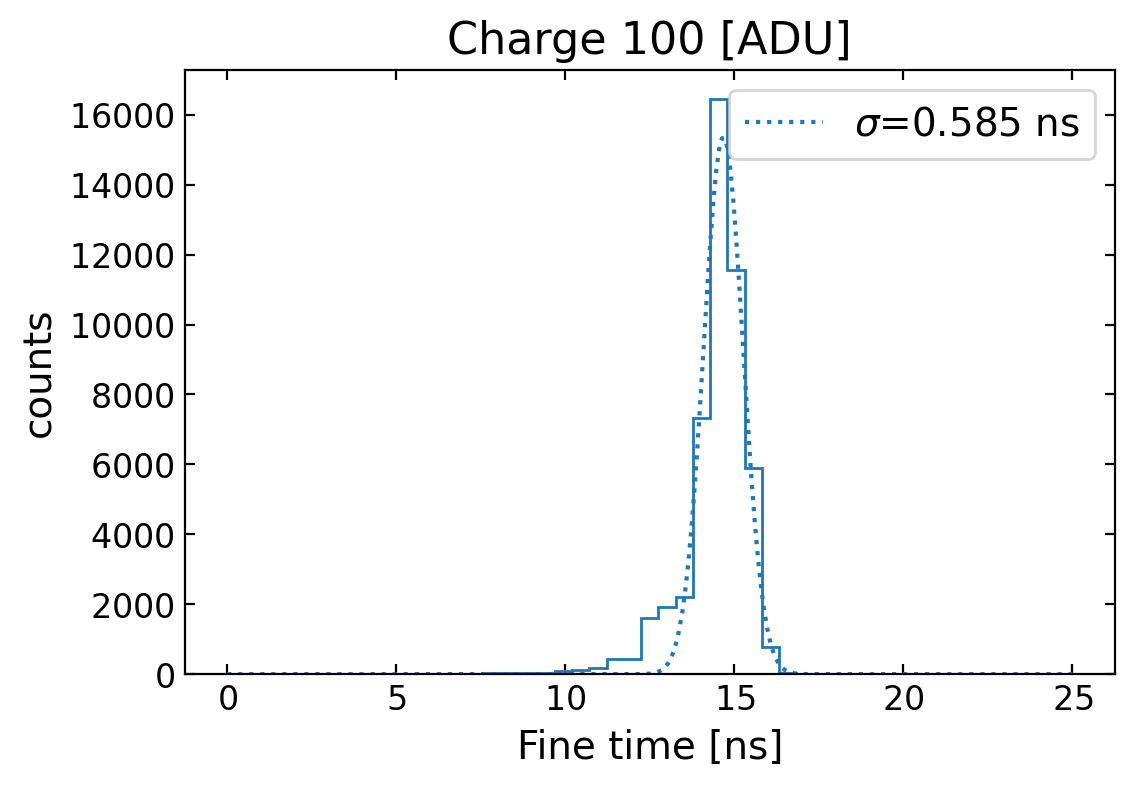

0.528893860383887 [ns]


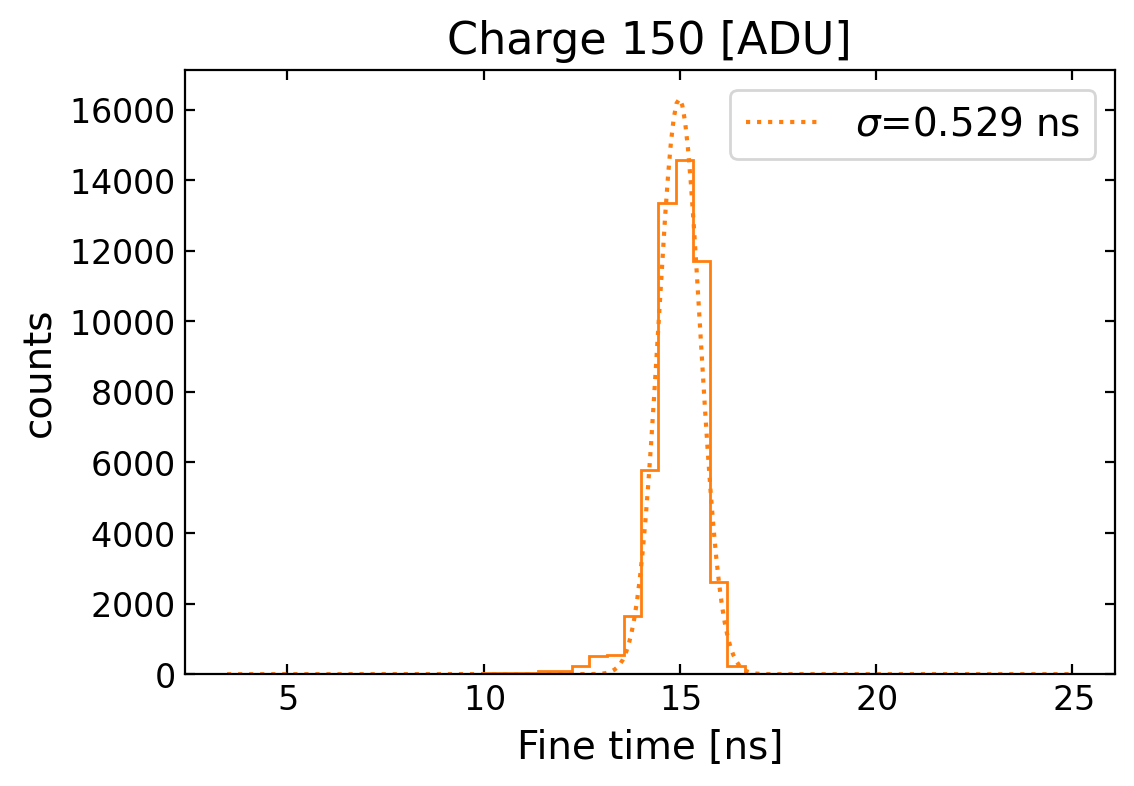

0.4738901953670425 [ns]


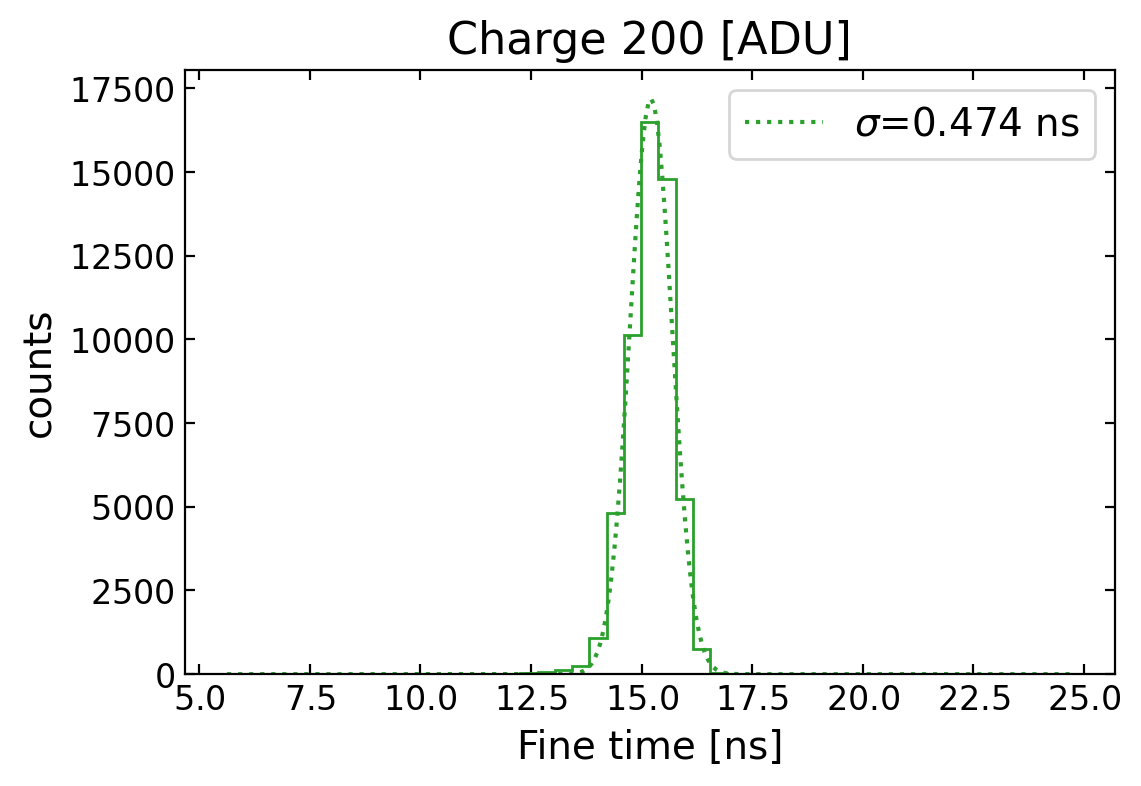

0.4036424030313459 [ns]


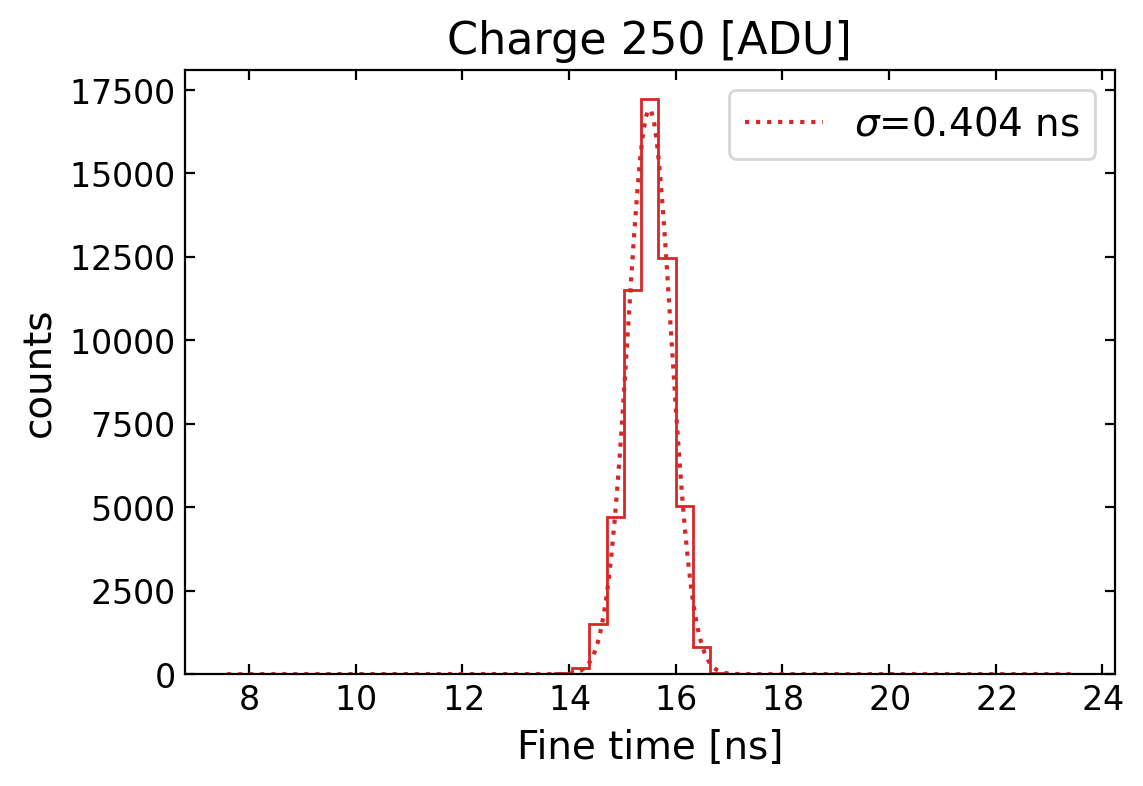

0.3457033037231835 [ns]


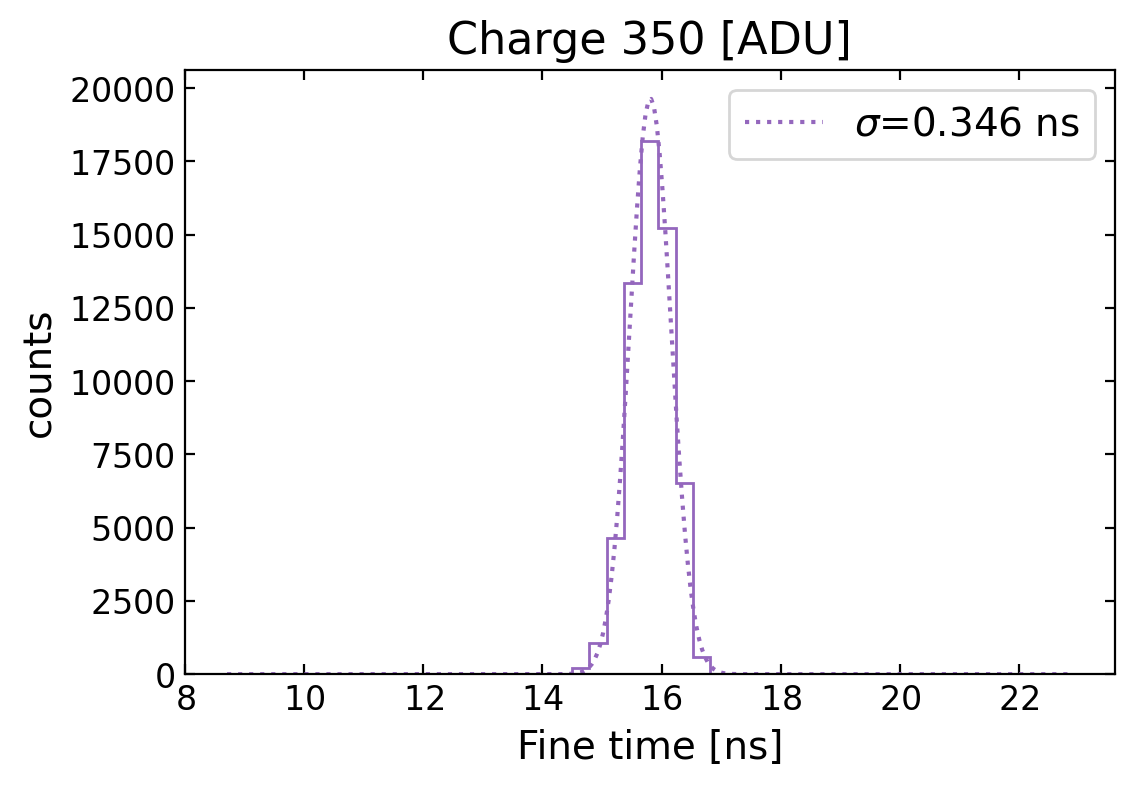

0.3278304030723059 [ns]


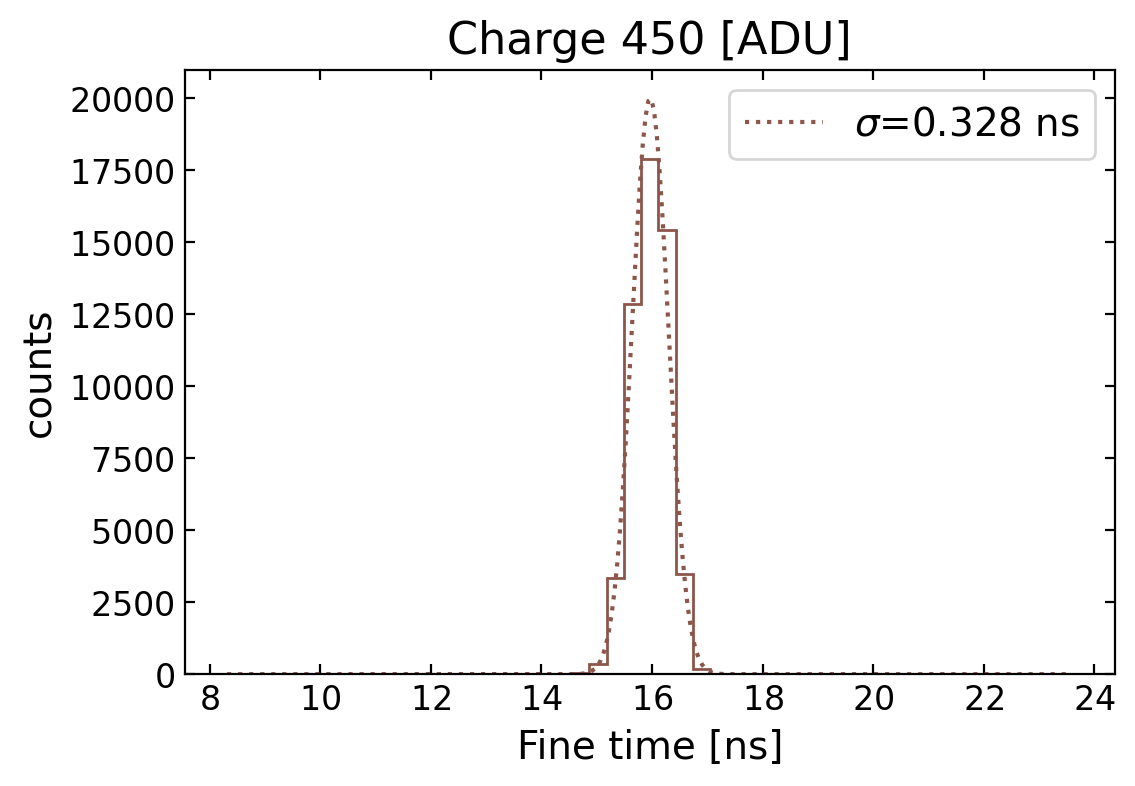

0.24969403383795763 [ns]


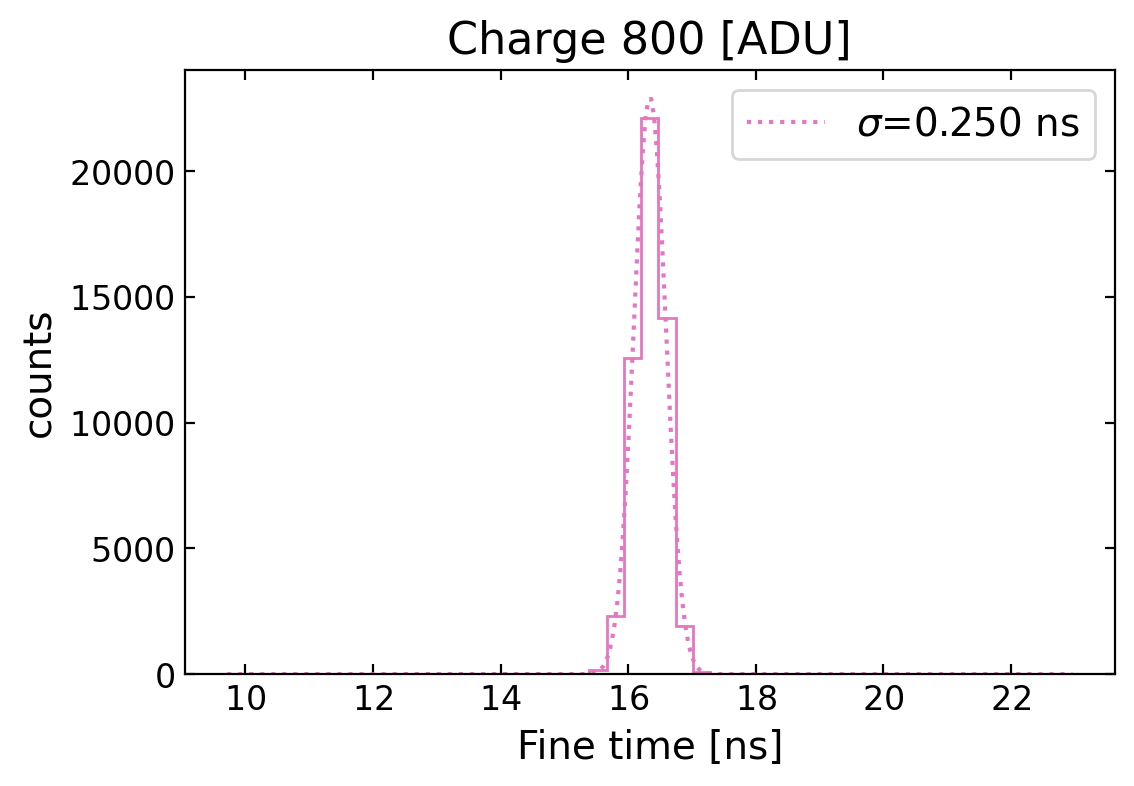

In [35]:
bins=np.linspace(0,25,240)
ch="16"
normed=False
charge_threshold=75

labels = [100, 150, 200, 250, 350, 450, 800]
data_inds = np.arange(141,148)

# Load all data
Data = []
for i, idata in enumerate(data_inds):
    data  = load_finetime(f"{DATA_DIR}/{idata}.data", ch =ch, ftime_min=None, ftime_max=None)
    Data.append(data)
    

resolutions_wls_cable = []
charges_wls_cable = []
for i, idata in enumerate(data_inds[:]):
    data  = Data[i]
    mask = (data[f"CHARGE_{ch}"]>75)#&(data[f"CHARGE_{ch}"]<125)
    popt, pcov = fit_finetime(data[f"FINE_calib_{ch}"][mask], color=f"C{i}");
    resolutions_wls_cable.append(popt[2])
    charges_wls_cable.append(np.mean(data[f"CHARGE_{ch}"][mask]-baseline)/peak_gap)


    xlabel("Fine time [ns]")
    ylabel("counts")
    # legend(fontsize=11,loc=[1.01,0])
    legend()
    # ylim(0,200)
    title(f"Charge {labels[i]} [ADU]")
    show()
    

(0.0, 0.6423572685020988)

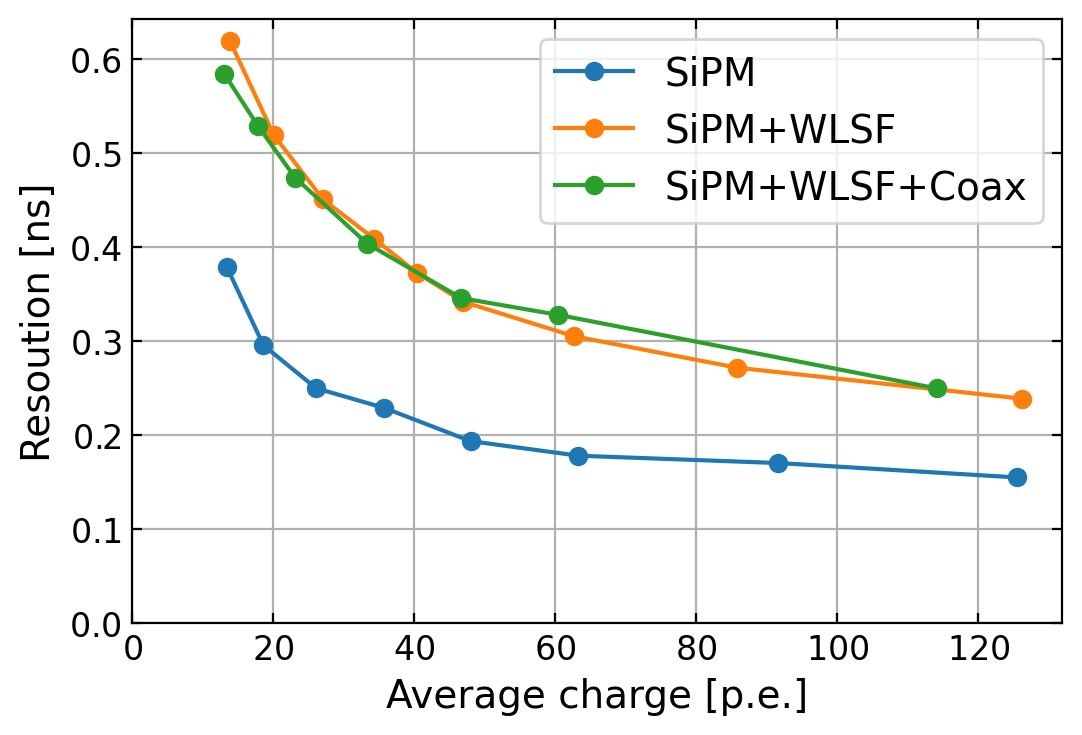

In [39]:
plot(charges_sipm, resolutions_sipm,marker="o",label="SiPM")
plot(charges, resolutions,marker="o",label="SiPM+WLSF")
plot(charges_wls_cable, resolutions_wls_cable,marker="o",label="SiPM+WLSF+Coax")
xlabel("Average charge [p.e.]")
ylabel("Resoution [ns]")
legend()
grid()
xlim(0,)
ylim(0,)

In [40]:
resolution_save = {}
resolution_save["charges_sipm"] = charges_sipm
resolution_save["resolutions_sipm"] = resolutions_sipm
resolution_save["charges_sipm_wls"] = charges
resolution_save["resolutions_sipm_wls"] = resolutions
resolution_save["charges_sipm_wls_cable"] = charges_wls_cable
resolution_save["resolutions_sipm_wls_cable"] = resolutions_wls_cable
joblib.dump(resolution_save, "Resolution.joblib")

['Resolution.joblib']

---
# How to calculate uncertainty induced by decay time?
1. Analytical. 
2. ToyMC

In [18]:
# 1. analytical
t_decay = 2.7 # ns
n_expected = 40 # number of eh expected
n_threshold = 4 # threshold

time_series = np.linspace(0.1,10,100)
prob_series = []
for t in time_series:
    # prob_single = np.exp(-t/t_decay)
    prob_single = scipy.stats.expon.cdf(t/t_decay)
    prob_triggered = np.power(prob_single, n_threshold)* np.power(1-prob_single, n_expected-n_threshold) * math.comb(n_expected,n_threshold)
    prob_series.append(prob_triggered)
prob_series=np.array(prob_series)

0.1444248051117692


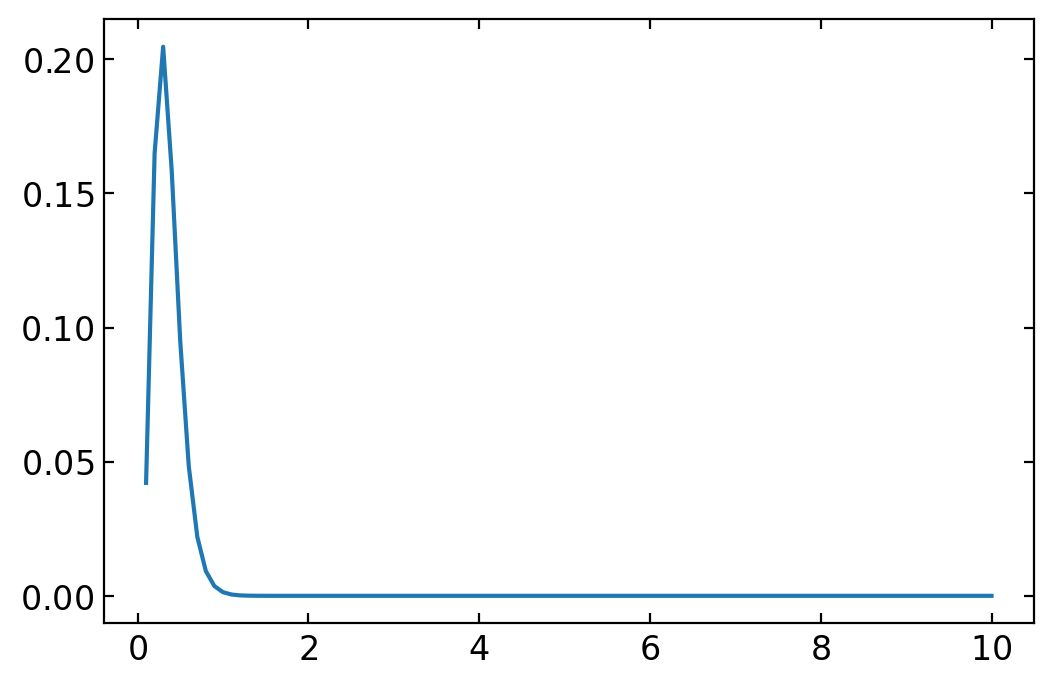

In [19]:
plot(time_series, prob_series)
fwhm = util.Utils.fwhm(time_series,prob_series,)
print((fwhm[1]-fwhm[0])/2.35)

In [44]:
def make_kernel_dummypulse(pre_trig, post_trig,tau1=2,tau2=20,AC_coulpled=False, Fs = 100):
    # Fs: samples per s
    x = np.arange(0,(pre_trig+post_trig))/Fs
    x0 = pre_trig/Fs
    dx=(x-x0)
    dx*=np.heaviside(dx,1)
    kernel = (np.exp(-dx/tau1)-np.exp(-dx/tau2))/(tau1-tau2)*np.heaviside(dx,1)
    # kernel_normed = kernel/(np.dot(kernel,kernel/max(kernel)))
    kernel_normed = kernel/np.max(kernel)

    return kernel_normed


def roll_zeropad(a, shift):
    y = np.roll(a,shift)
    y[:shift]=0
    return y

In [73]:
# 2. Toy MC

# Signal size and trigger
n_expected = 13.5 # number of eh expected
n_threshold = 4.5 # threshold [eh]

# WLS fiber parameter
WLS_t_decay = 2.7 # [ns]
WLS_t_decay = 0.1 # [ns]
# Laser parameter
LASER_time_spread = 0.15 # [ns], sigma, Gaus wavelet


# Run parameters
N_EXPERIMENTS = 10_000
N_PLOTS = 200
SEED = 1
RNG = np.random.default_rng(seed=SEED)

# Pulse parameters
Fs=100 # 100 samples per ns
TR=2 # rise time 2 ns
TF=20 # fall time 20 ns
PULSE_DURATION = 50 #ns




PULSE = make_kernel_dummypulse(0,PULSE_DURATION*Fs,tau1 = TR,tau2 = TF,AC_coulpled = False, Fs=Fs)
TIME_SERIES = np.linspace(0,PULSE_DURATION,PULSE_DURATION*Fs)

results_trigger_time = []
results_pulses = []
for i in tqdm(range(N_EXPERIMENTS)):
    # Get the actual numer of photons by Sampling from poisson
    n_gen = RNG.poisson(lam=n_expected)
    
    if n_gen>0:
        pulse_this = np.zeros_like(PULSE)
        # Get the time of each photon by sampling from Gauss
        time_gen = RNG.normal(loc=LASER_time_spread*7, scale=LASER_time_spread*7, size=n_gen)

        # Get the decay time of each photon by sampling from exponential
        time_decay = time_gen + RNG.exponential(scale=WLS_t_decay, size=n_gen)
            
        for iphoton in range(n_gen):
            if time_decay[iphoton]>0 and time_decay[iphoton]<PULSE_DURATION:
                # Roll and pile one more pulse to the final pulse
                pulse_this+=roll_zeropad(PULSE, int(time_decay[iphoton]*Fs))
                
        results_trigger_time.append(np.argmax(pulse_this>n_threshold))
        
        if i<N_PLOTS:
            results_pulses.append(pulse_this)
            
results_trigger_time=np.array(results_trigger_time)            

100%|██████████| 10000/10000 [00:10<00:00, 956.93it/s]


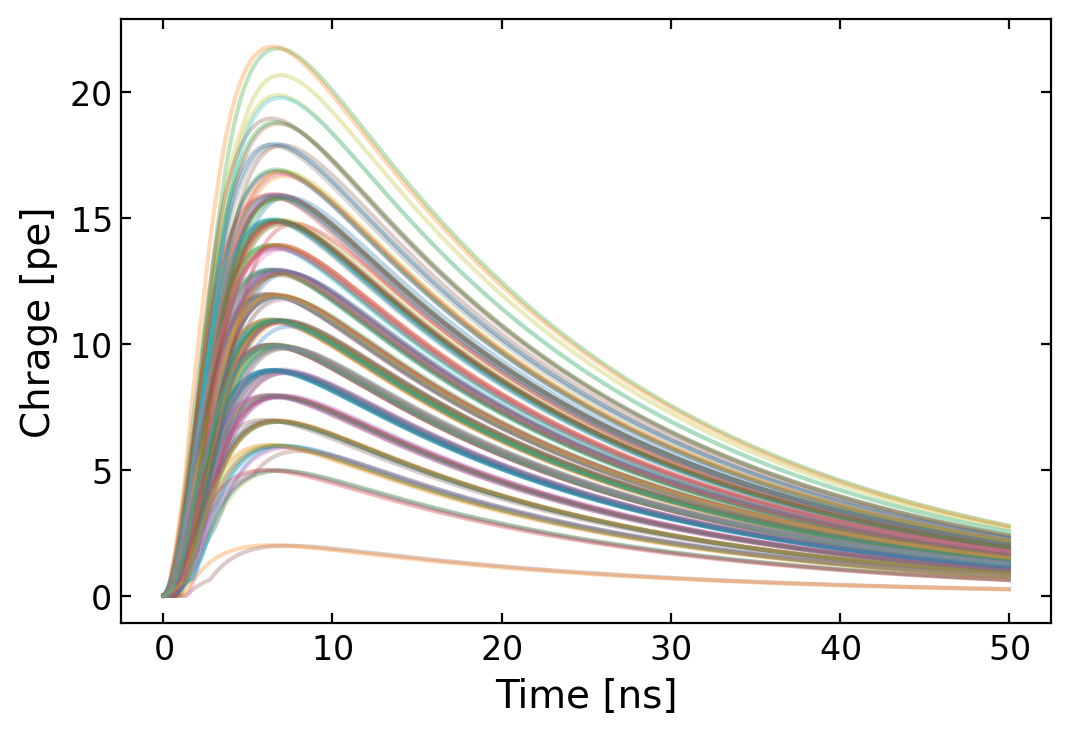

0.4133848648246244


Text(0, 0.5, 'Counts')

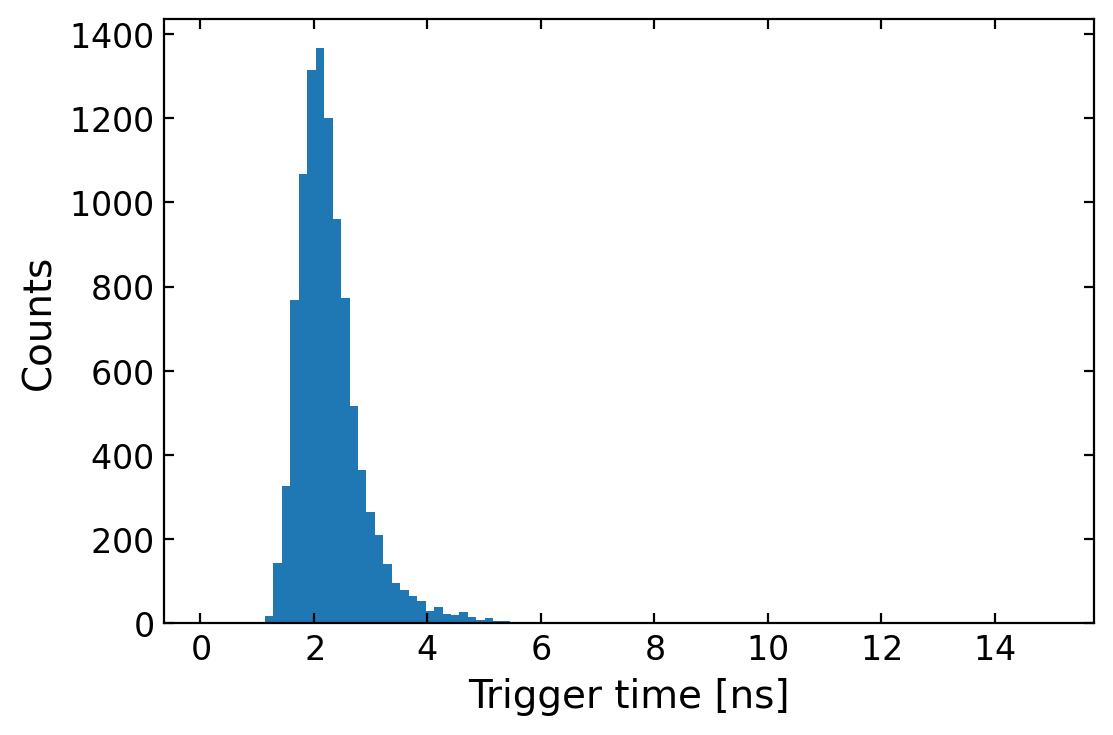

In [74]:
for pulse_this in results_pulses:
    plot(TIME_SERIES, pulse_this, alpha=0.3)  
            
xlabel("Time [ns]")
ylabel("Chrage [pe]")
show()

n,ibins,p=hist(results_trigger_time/Fs, range=(0.1,15));
fwhm = util.Utils.fwhm(ibins[:-1],n)
print((fwhm[1]-fwhm[0])/2.355)
xlabel("Trigger time [ns]")
ylabel("Counts")

---
# Previous Study

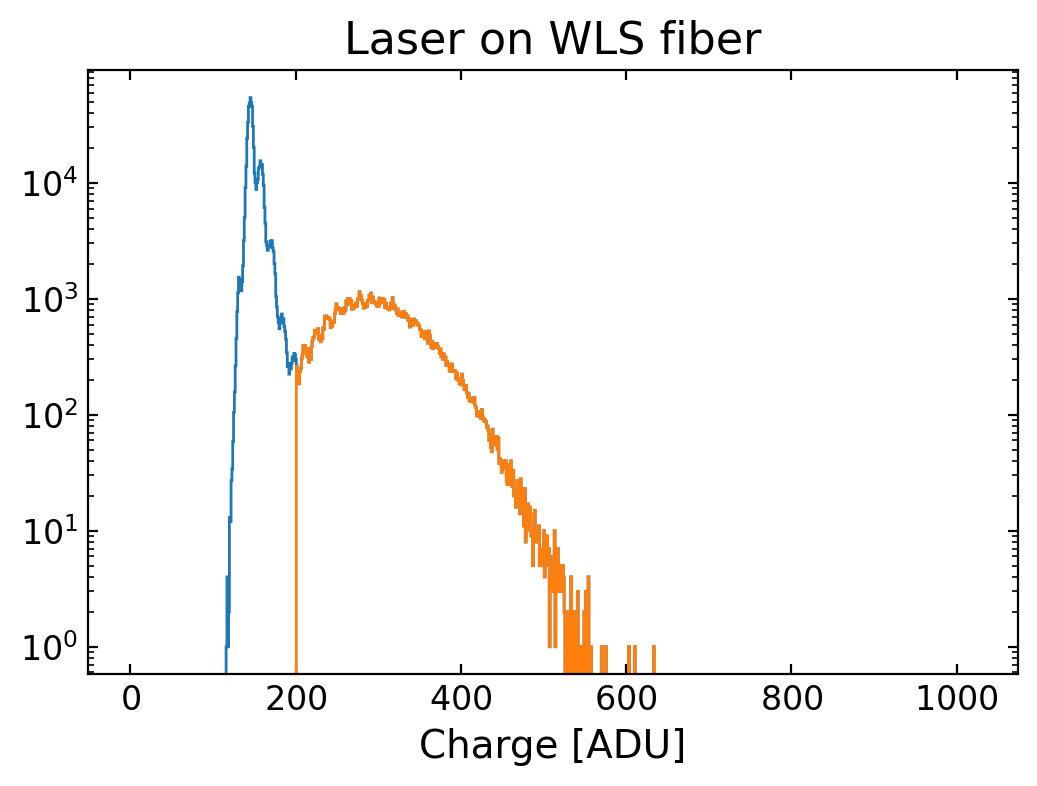

1.512127217071292 [ns]


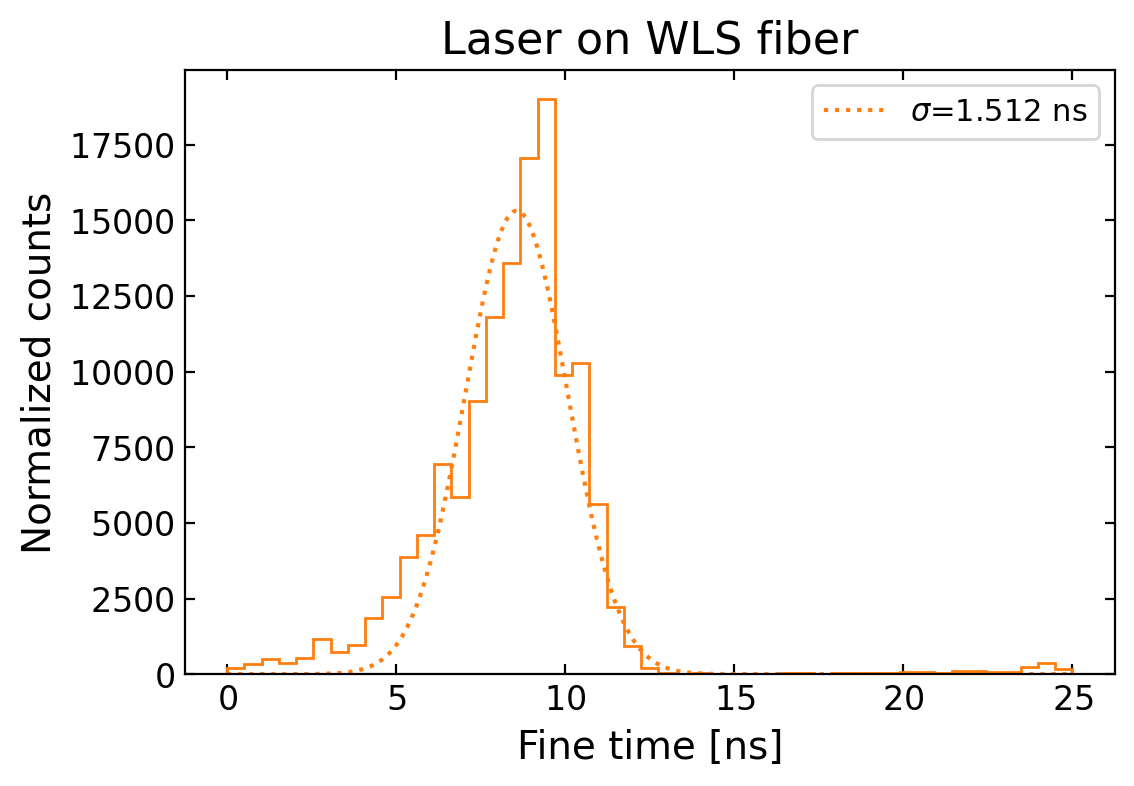

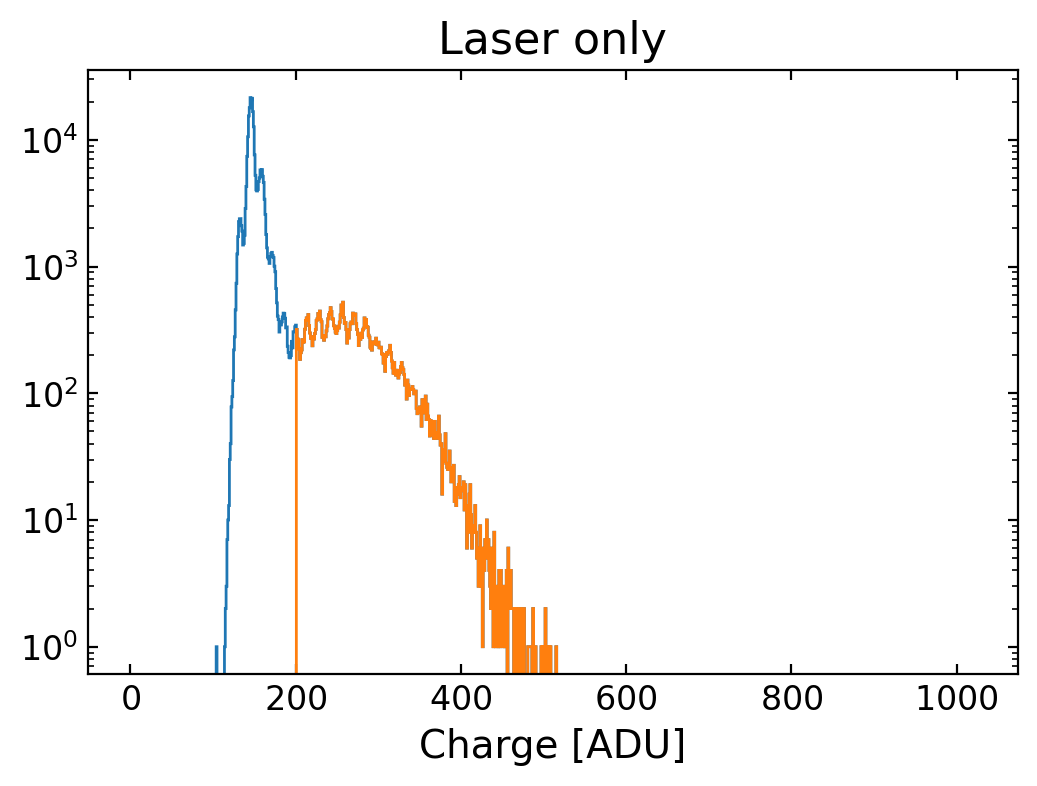

0.7143887334781694 [ns]


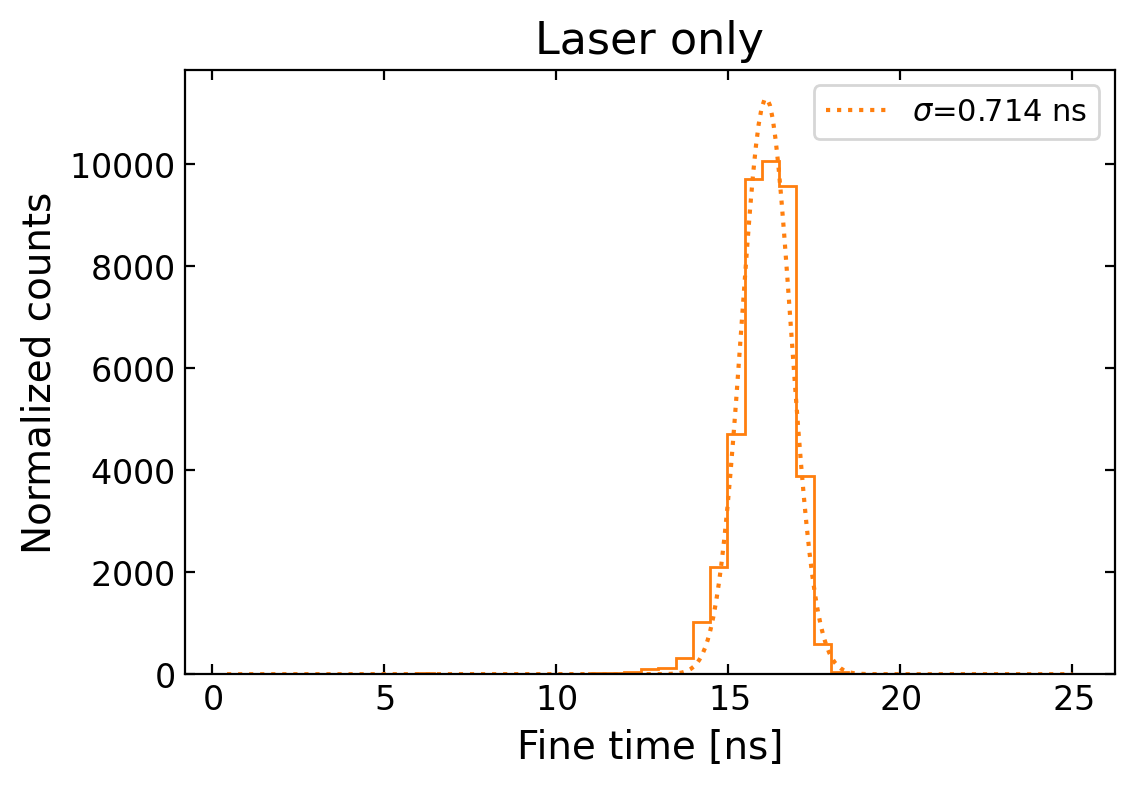

In [19]:
filename = f"{DATA_DIR}/19.data"
title_text= "Laser on WLS fiber"
plot_charge_time(filename, charge_cut_threshold=200, title_text=title_text, finetime_roll=7)

filename = f"{DATA_DIR}/17.data"
title_text= "Laser only"
plot_charge_time(filename, charge_cut_threshold=200, title_text=title_text, finetime_roll=7)

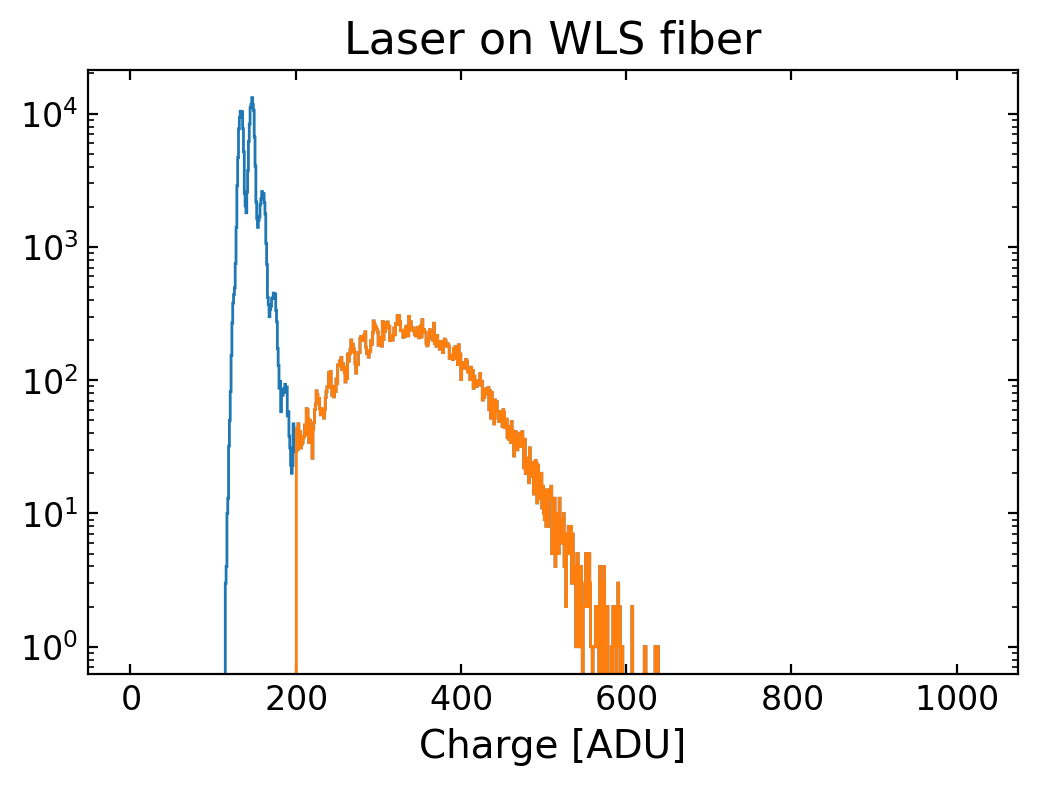

1.2199861962320244 [ns]


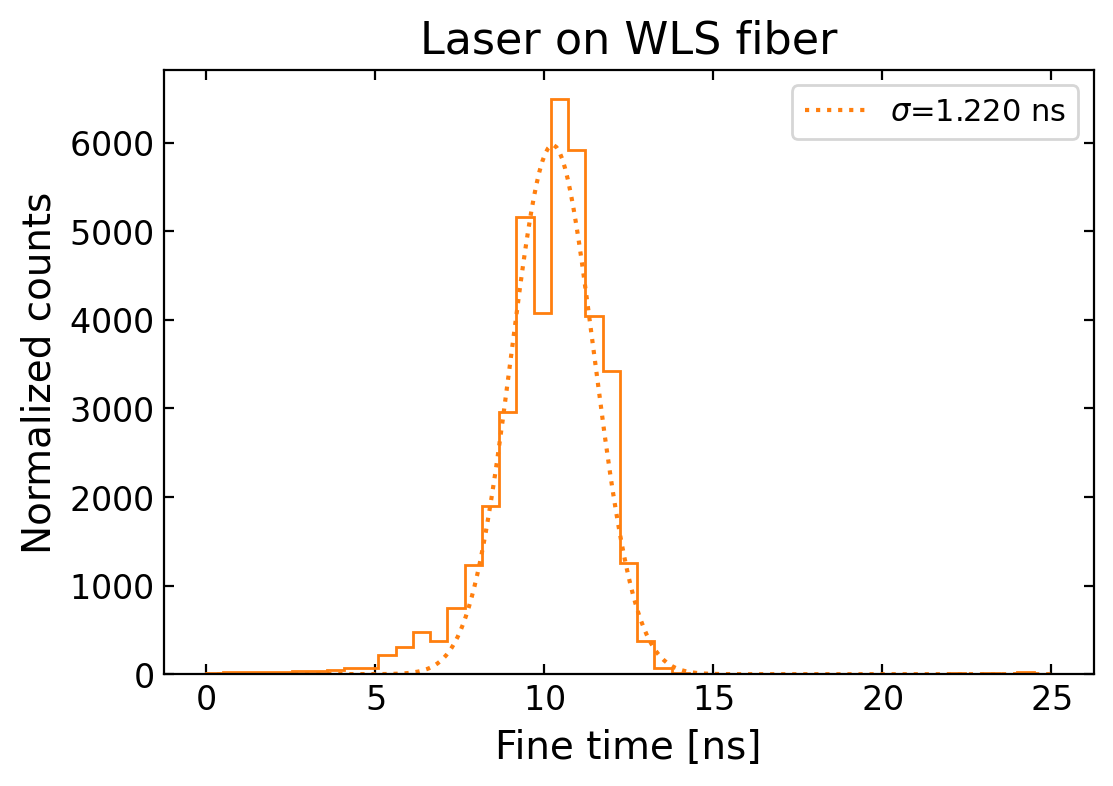

In [20]:
filename = f"{DATA_DIR}/22.data"
title_text= "Laser on WLS fiber"
plot_charge_time(filename, charge_cut_threshold=200, title_text=title_text, finetime_roll=7)

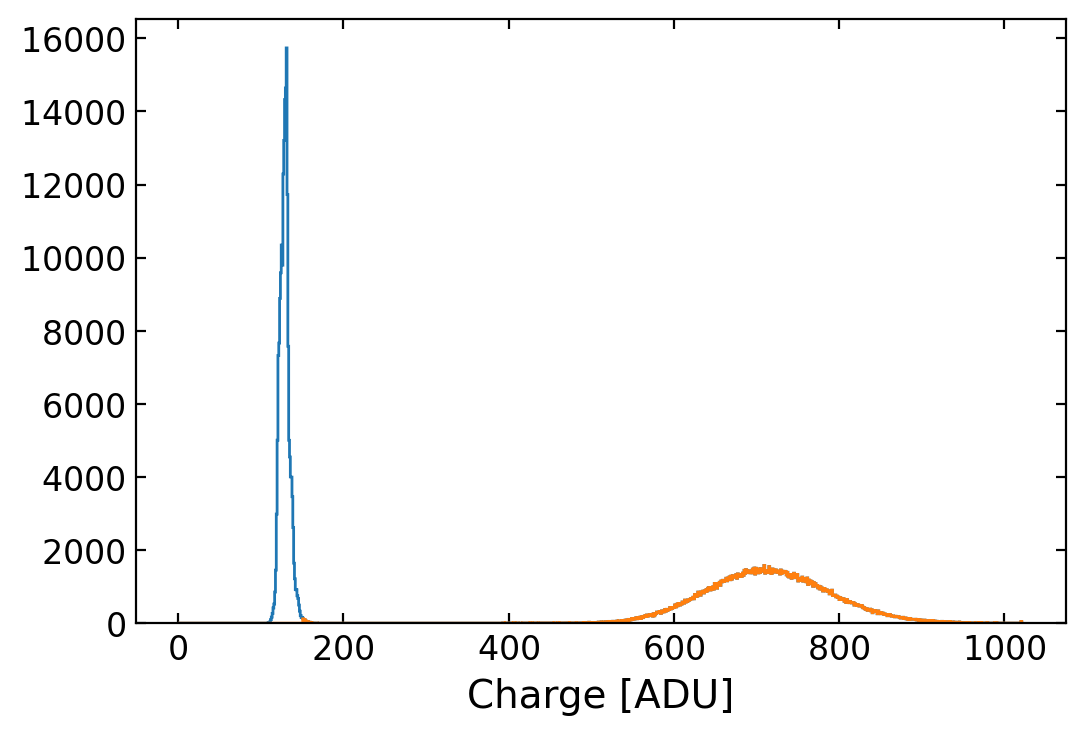

0.16900540192651278 [cm]


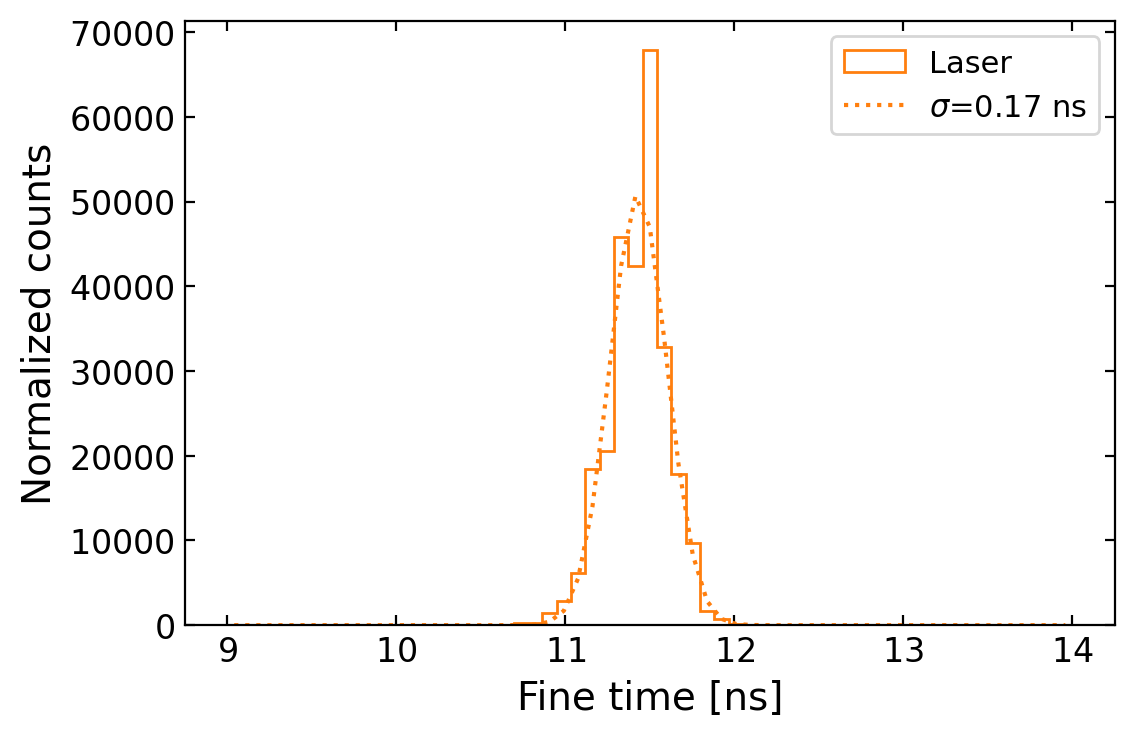

In [40]:
hist(data[f"CHARGE_{ch}"],bins=1023,range=(0,1023),histtype="step");
hist(data[f"CHARGE_{ch}"][data["CHARGE_0"]>150],bins=1023,range=(0,1023),histtype="step");
# yscale("log")
xlabel("Charge [ADU]")
show()

# bins=np.linspace(0,25,240)
bins=np.linspace(9,14,60)

n,ibins,_ = hist(data[f"FINE_calib_{ch}"][data["CHARGE_0"]>150], bins=bins,label="Laser", density=0, histtype="step", color="C1");
# n1,ibins,_ = hist(data[f"FINE_calib_{ch}"][data["CHARGE_0"]<180], bins=bins,label="Dark current", density=1, histtype="step");
bincenters=0.5*(ibins[1:]+ibins[:-1])
yerr=np.sqrt(n);yerr[yerr==0]=1

popt1,pcov = rt.fit_tg(bincenters,n,yerr=yerr,function="gaus",fit_range=(10,13))
perr1 = np.sqrt(np.diag(pcov))
print(popt1[2],'[cm]')
plot(bincenters, util.Utils.Gauss(bincenters,*popt1),color="C1",linestyle=":",label=f"$\sigma$={popt1[2]:.2f} ns" )
# plot(bincenters, util.Utils.Gauss(bincenters,*popt1),color="C0",label=f"$\sigma$={popt1[2]:.1f}$\pm${perr1[2]:.1f} \n "+r"$\bar{x}$"+f"={popt1[1]:.1f}$\pm${perr1[1]:.1f} "  )

xlabel("Fine time [ns]")
ylabel("Normalized counts")
legend(fontsize=11)
# yscale("log")

In [9]:
filename = f"{DATA_DIR}/22.data"
data  = pd.read_csv(filename, sep=';', on_bad_lines  = "skip", usecols=["CHARGE_0", "FINE_0","RUN_EventTimecode_ns"])
ch = "0"
data[f"FINE_calib_{ch}"] = finetime_calib(data[f"FINE_{ch}"])

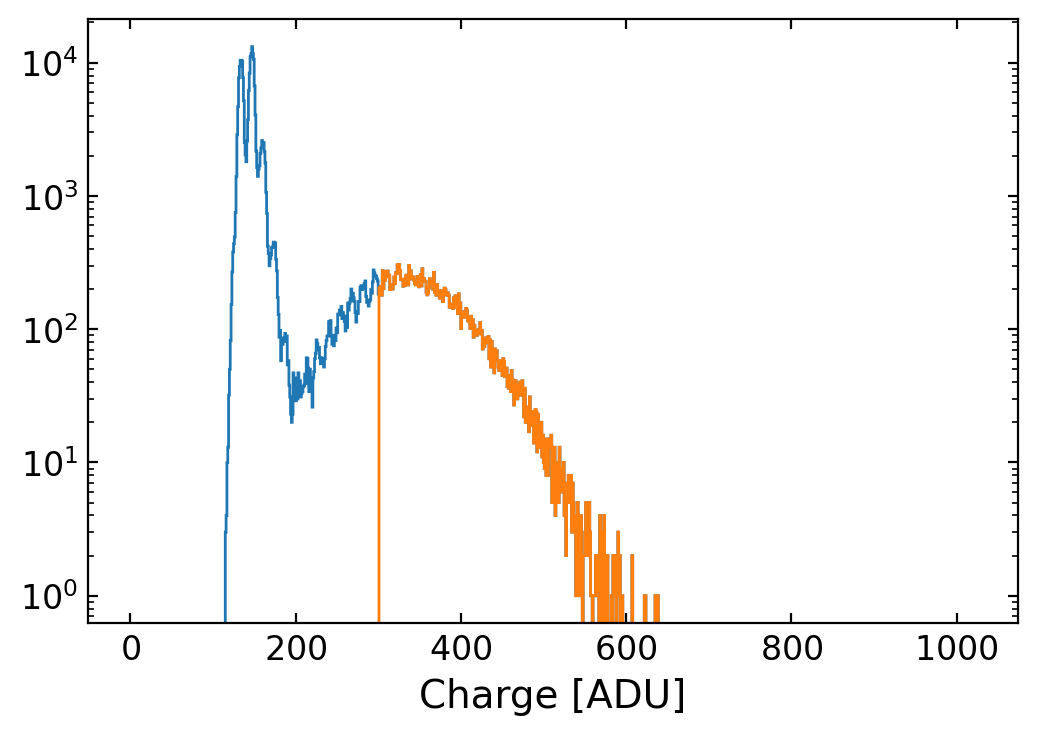

1.0989381395312532 [cm]


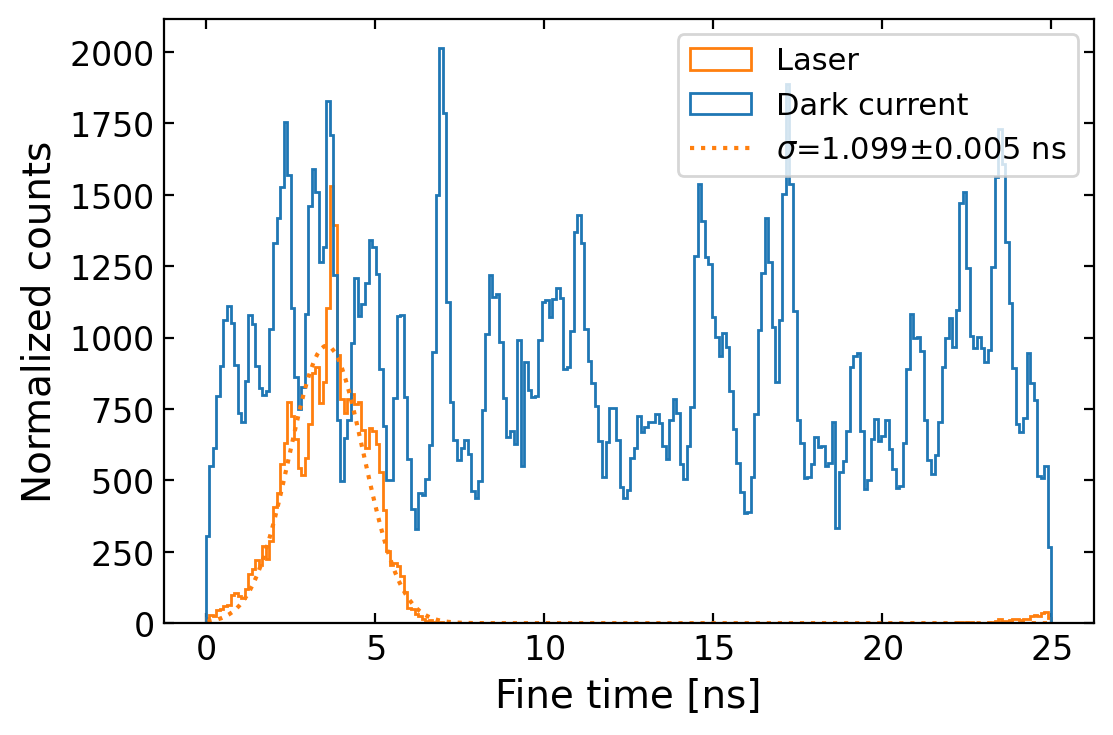

In [13]:
threshold=300

hist(data[f"CHARGE_{ch}"],bins=1023,range=(0,1023),histtype="step");
hist(data[f"CHARGE_{ch}"][data["CHARGE_0"]>threshold],bins=1023,range=(0,1023),histtype="step");
# yscale("log")
xlabel("Charge [ADU]")
yscale("log")
show()

bins=np.linspace(0,25,240)
# bins=np.linspace(5,14,60)

n,ibins,_ = hist(data[f"FINE_calib_{ch}"][data["CHARGE_0"]>threshold], bins=bins,label="Laser", density=0, histtype="step", color="C1");
n1,ibins,_ = hist(data[f"FINE_calib_{ch}"][data["CHARGE_0"]<threshold], bins=bins,label="Dark current", density=0, histtype="step");
bincenters=0.5*(ibins[1:]+ibins[:-1])
yerr=np.sqrt(n);yerr[yerr==0]=1

popt1,pcov = rt.fit_tg(bincenters,n,yerr=yerr,function="gaus",fit_range=(0,15))
perr1 = np.sqrt(np.diag(pcov))
print(popt1[2],'[cm]')
plot(bincenters, util.Utils.Gauss(bincenters,*popt1),color="C1",linestyle=":",label=f"$\sigma$={popt1[2]:.3f}$\pm${perr1[2]:.3f} ns" )
# plot(bincenters, util.Utils.Gauss(bincenters,*popt1),color="C0",label=f"$\sigma$={popt1[2]:.1f}$\pm${perr1[2]:.1f} \n "+r"$\bar{x}$"+f"={popt1[1]:.1f}$\pm${perr1[1]:.1f} "  )

xlabel("Fine time [ns]")
ylabel("Normalized counts")
legend(fontsize=11)
# yscale("log")

In [ ]:
std(data[f"FINE_calib_{ch}"][data["CHARGE_0"]>180])

---

In [9]:
files = ["4.data", "6.data", "11.data", "13.data"]

labels = ["Waveform Generator", "SiPM, Gain 820", "SiPM, Gain 420", "Waveform Generator, new"]

Data = []
ch=0
for filename in files:
    data  = pd.read_csv(f"{DATA_DIR}/{filename}", sep=';', on_bad_lines  = "skip", usecols=[f"CHARGE_{ch}", f"FINE_{ch}","RUN_EventTimecode_ns"])
    data[f"FINE_calib_{ch}"] = finetime_calib(data[f"FINE_{ch}"])
    Data.append(data)
    

(0.0, 1050.0)

findfont: Font family ['san-serif'] not found. Falling back to DejaVu Sans.


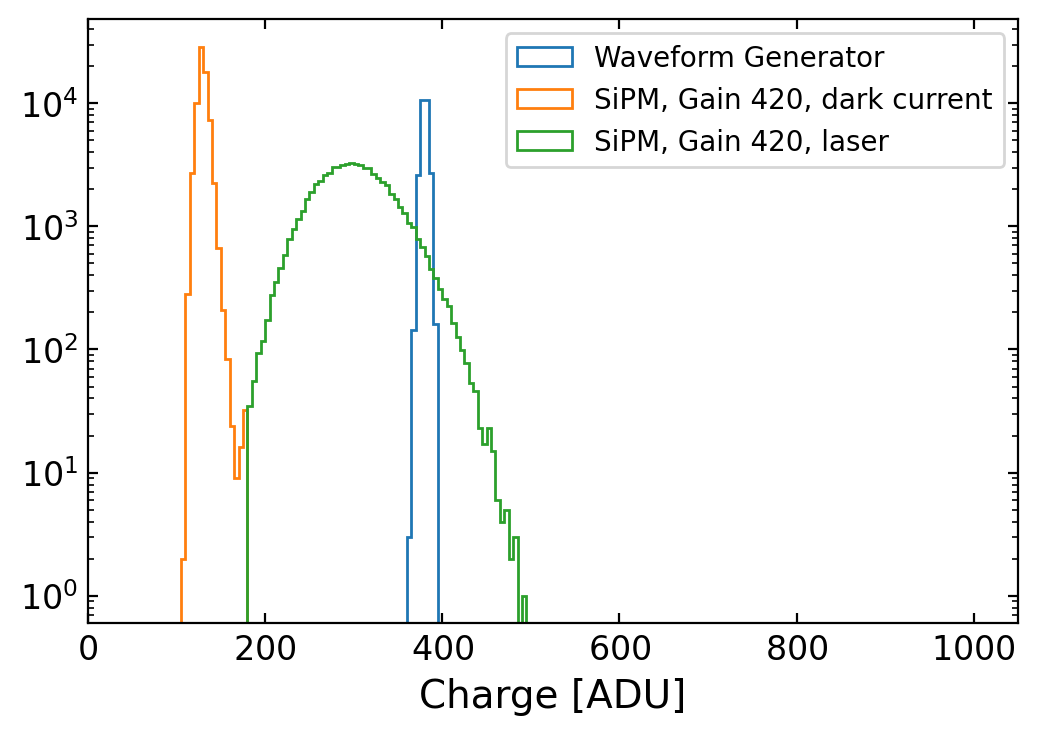

In [11]:
hist(Data[0].CHARGE_0[Data[0]["CHARGE_0"]>300],histtype="step",bins=200,range=(0,1000),label=labels[0]);
# hist(Data[1].CHARGE_0,histtype="step",bins=200,range=(0,1000),label=labels[1]+", dark current");
hist(Data[2].CHARGE_0[Data[2]["CHARGE_0"]<180],histtype="step",bins=200,range=(0,1000),label=labels[2]+", dark current");
hist(Data[2].CHARGE_0[Data[2]["CHARGE_0"]>180],histtype="step",bins=200,range=(0,1000),label=labels[2]+", laser");
# hist(Data[3].CHARGE_0[Data[2]["CHARGE_0"]>180],histtype="step",bins=200,range=(0,1000),label=labels[2]+", laser");
# hist(Data[2].CHARGE_0[data2["CHARGE_0"]>180],bins=100,range=(0,1000));
xlabel("Charge [ADU]")
yscale("log")
legend(fontsize=10)
xlim(0,)

Waveform Generator  std(n)=0.0050
SiPM, Gain 820, dark current  std(n)=499.0695
SiPM, Gain 420, dark current  std(n)=0.0116
SiPM, Gain 420, laser  std(n)=0.0048


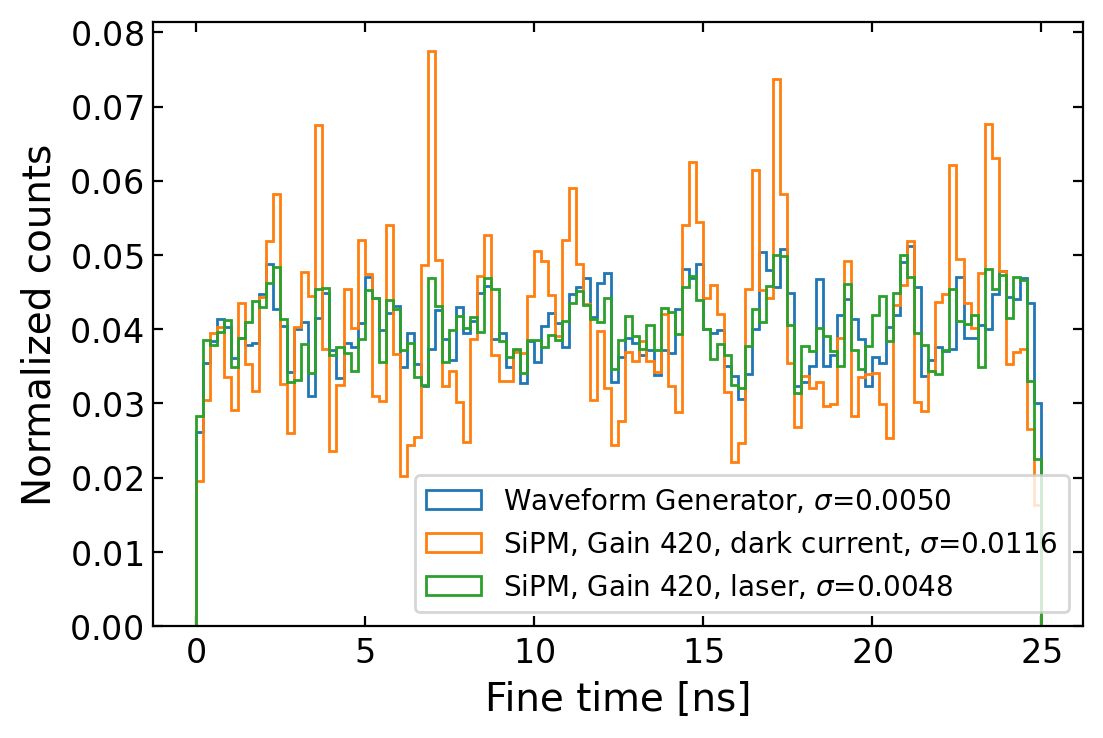

In [34]:
# FINE_21_calib = finetime_calib(data[f"FINE_{ch}"])
bins=np.linspace(0,25,121)

n0,ibins,_ = hist(Data[0][f"FINE_calib_{ch}"][Data[0]["CHARGE_0"]>300], bins=bins,label=labels[0], density=1, histtype="step");
# n1,ibins,_ = hist(Data[1][f"FINE_calib_{ch}"], bins=bins,label=labels[1]+", dark current", density=1, histtype="step");
n2,ibins,_ = hist(Data[2][f"FINE_calib_{ch}"][Data[2]["CHARGE_0"]<180], bins=bins,label=labels[2]+", dark current", density=1, histtype="step");
n3,ibins,_ = hist(Data[2][f"FINE_calib_{ch}"][Data[2]["CHARGE_0"]>180], bins=bins,label=labels[2]+", laser", density=1, histtype="step");
# n4,ibins,_ = hist(Data[3][f"FINE_calib_{ch}"][Data[2]["CHARGE_0"]>180], bins=bins,label=labels[3], density=1, histtype="step");

print(f"{labels[0]:<15}", f" std(n)={std(n0):.4f}")
print(f"{labels[1]}, dark current", f" std(n)={std(n1):.4f}")
print(f"{labels[2]}, dark current", f" std(n)={std(n2):.4f}")
print(f"{labels[2]}, laser", f" std(n)={std(n3):.4f}")
# print(f"{labels[3]}, laser", f" std(n)={std(n4):.4f}")


# bincenters = 0.5*(ibins[1:]+ibins[:-1])
# peak_inds = scipy.signal.find_peaks_cwt(n, [2,3], min_snr=1.2)
# print(peak_inds)
# for ipeak in range(2):
#     i0 = bincenters[peak_inds[ipeak]]
#     for i in range(4):
#         axvline(i0+25/4*i,color=f"C{ipeak+1}",linestyle="--")

        

xlabel("Fine time [ns]")
ylabel("Normalized counts")
handles, labels_this = gca().get_legend_handles_labels()
labels_this[0] = labels_this[0] + f", $\sigma$={std(n0):.4f}"
labels_this[1] = labels_this[1] + f", $\sigma$={std(n2):.4f}"
labels_this[2] = labels_this[2] + f", $\sigma$={std(n3):.4f}"
# labels_this[3] = labels_this[3] + f", $\sigma$={std(n3):.4f}"
legend(handles, labels_this, loc="lower right",fontsize=10)
# grid()

In [11]:
lines

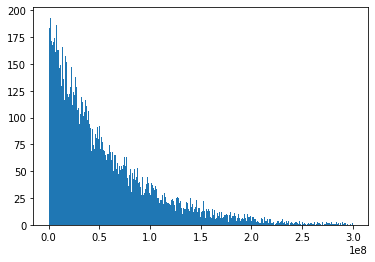

In [10]:
hist(np.diff(data["RUN_EventTimecode_ns"]),bins=300,range=(0,30e7));
# yscale("log")

In [6]:
# for i in range(len(config)):
#     print(f"#{i},", config[i])

In [ ]:
def replace_str_index(text,index=0,replacement=''):
    return '%s%s%s'%(text[:index],replacement,text[index+1:])

5: no fiber
6: with fiber, threshold 900
7: with fiber, threshold 970

In [35]:
filenames = {0: ["5.data", "No fiber"],
            1: ["6.data", "Threshold 900"],
             2: ["7.data", "Threshold 970"],
             3: ["8.data", "LED low, threshold 900"],
             4: ["10.data", "LED high, threshold 970"],
            5:["11.data", "Dark current, threshold 900"],
            6:["12.data", "LED high, threshold 900"]}

Data = {}
for key in filenames:
    filename = filenames[key][0]
    data  = pd.read_csv(filename, sep=';', on_bad_lines  = "skip")
    Data[key] = data

# ch = "21"
ch = "0"

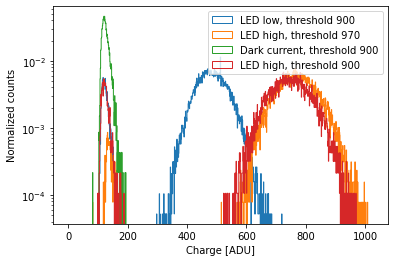

In [36]:
for key in filenames:
    if key<=2:
        continue
    data = Data[key]

    FINE_21_calib = data[f"CHARGE_{ch}"]
    bins=np.linspace(0,1024,1023)
    n,ibins,_ = hist(FINE_21_calib, bins=bins, histtype= "step", label = filenames[key][1], density=1);
    
legend()
xlabel("Charge [ADU]")
ylabel("Normalized counts")
yscale("log")

In [ ]:
for key in [5,3]:
    data = Data[key]

    FINE_21_calib = finetime_calib(data[f"FINE_{ch}"])
    bins=np.linspace(0,25,80)
    n,ibins,_ = hist(FINE_21_calib, bins=bins, color=f"C{key-3}", histtype= "step", label = filenames[key][1], density=1);
    print(filenames[key][1], f", std: {np.std(n)}")
    
legend()
xlabel("Fine time [ns]")
ylabel("Normalized counts")
show()

for key in [3,6,4]:
    data = Data[key]

    FINE_21_calib = finetime_calib(data[f"FINE_{ch}"])
    charge = data[f"CHARGE_{ch}"]
    bins=np.linspace(0,25,80)
    n,ibins,_ = hist(FINE_21_calib[charge>400], bins=bins, color=f"C{key-3}", histtype= "step", label = filenames[key][1], density=1);
    print(filenames[key][1], f", std: {np.std(n)}")
    
legend(loc=(1,0))
xlabel("Fine time [ns]")
ylabel("Normalized counts")

---

In [2]:
import h5py
import matplotlib.ticker as ticker

In [4]:
# DATA_DIR = "/project/rrg-mdiamond/tomren/mudata/MP0100/"
# f = h5py.File(f'{DATA_DIR}/Scope/DT5550_noise_hunting/preamp-out-default.h5', 'r')
# np.array(f["Waveforms"]['Channel 4']['Channel 4Data'][:])
# f.close()

array([-1823, -1296,  -852, ..., -1533, -1867, -1770], dtype=int16)

# ASIC A, preamp out 

In [3]:
DATA_DIR = "/project/rrg-mdiamond/tomren/mudata/MP0100/"

files = ["preamp-out-during-redout.h5",
         "preamp-out-default.h5",
"preamp-out-firmwaremod-2.h5",]

labels = ["During digital readout", "Digital readout stopped", "Clock disabled"]

Data = []
for filename in files:
    f = h5py.File(f'{DATA_DIR}/Scope/DT5550_noise_hunting/{filename}', 'r')    
    Data.append(np.array(f["Waveforms"]['Channel 4']['Channel 4Data'][:]))
    f.close()

In [4]:
Data_fft=[]
for data in Data:
    Data_fft.append(np.fft.rfft(data))
freq = np.fft.rfftfreq(n=len(Data[0]),d=1/3_200_000_000)

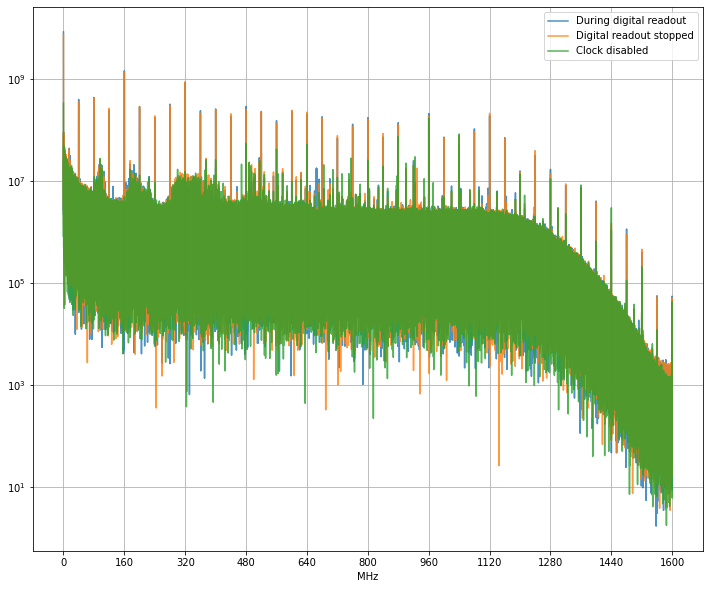

In [5]:
figure(figsize=(12,10))
for i, data_fft in enumerate(Data_fft):
    if i<2:
        plot(freq/1e6, np.abs(data_fft),alpha=0.8, label=labels[i])
    else:
        plot(freq/1e6, np.abs(data_fft)/2,alpha=0.8, label=labels[i])    
    
    
gca().xaxis.set_major_locator(ticker.MultipleLocator(160))    
grid()
xlabel("MHz")
yscale("log")
legend()

# ASIC A vs ASIC C

In [6]:
DATA_DIR = "/project/rrg-mdiamond/tomren/mudata/MP0100/"

files = ["preamp-out-default.h5","preamp-out-default-asic-c.h5",]

labels = ["ASIC A (with pitch adapter)","ASIC C (w/o pitch adapter)"]

Data = []
for filename in files:
    f = h5py.File(f'{DATA_DIR}/Scope/DT5550_noise_hunting/{filename}', 'r')    
    Data.append(np.array(f["Waveforms"]['Channel 4']['Channel 4Data'][:]))
    f.close()

In [7]:
Data_fft=[]
for data in Data:
    Data_fft.append(np.fft.rfft(data))
freq = np.fft.rfftfreq(n=len(Data[0]),d=1/3_200_000_000)

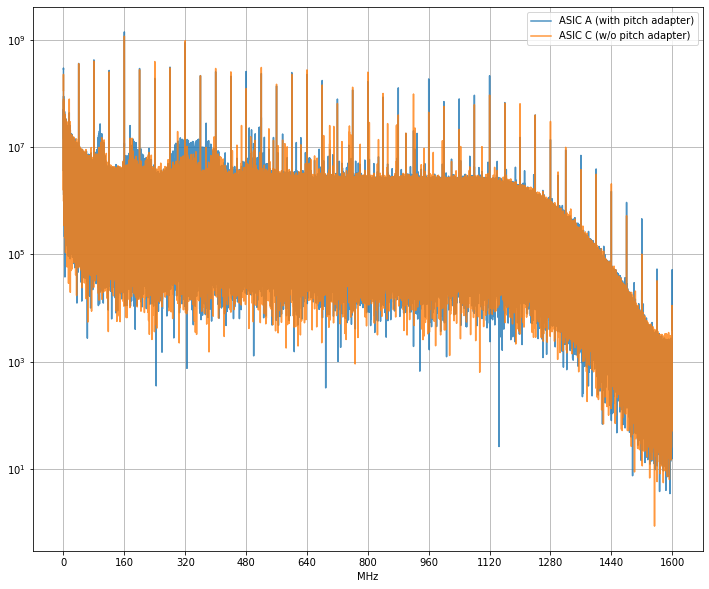

In [12]:
figure(figsize=(12,10))
for i, data_fft in enumerate(Data_fft):
    if i<2:
        plot(freq[1:]/1e6, np.abs(data_fft)[1:],alpha=0.8, label=labels[i])
    else:
        plot(freq[1:]/1e6, np.abs(data_fft)[1:]/2,alpha=0.8, label=labels[i])    
    
    
gca().xaxis.set_major_locator(ticker.MultipleLocator(160))    
grid()
xlabel("MHz")
yscale("log")
legend()
# xscale("log")

In [34]:
DATA_DIR = "/project/rrg-mdiamond/tomren/mudata/MP0100/"

files = ["time-threshold-during-readout.h5",
         "time-threshold-default.h5",
"time-threshold-firmwaremod.h5",]

Data = []
for filename in files:
    f = h5py.File(f'{DATA_DIR}/Scope/DT5550_noise_hunting/{filename}', 'r')    
    Data.append(np.array(f["Waveforms"]['Channel 4']['Channel 4Data'][:]))
    f.close()

In [35]:
Data_fft=[]
for data in Data:
    Data_fft.append(np.fft.rfft(data))
freq = np.fft.rfftfreq(n=len(Data[0]),d=1/3_200_000_000)

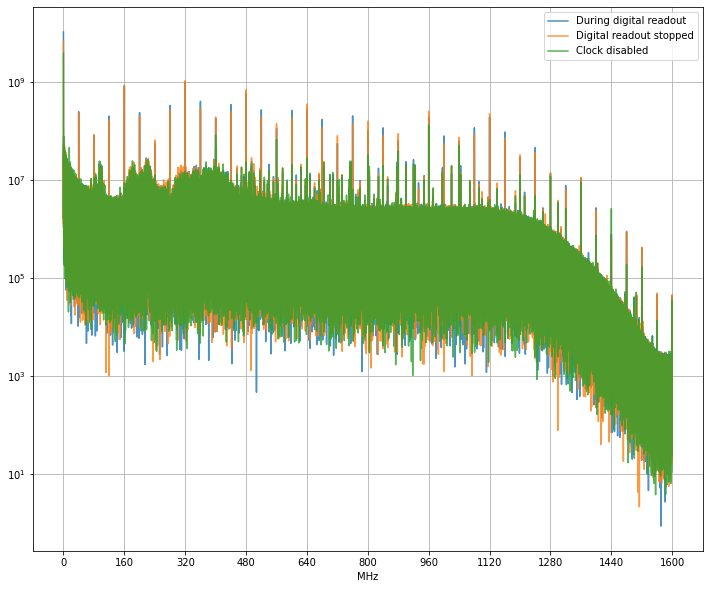

In [36]:
figure(figsize=(12,10))
for i, data_fft in enumerate(Data_fft):
    plot(freq/1e6, np.abs(data_fft),alpha=0.8, label=labels[i])
    
    
gca().xaxis.set_major_locator(ticker.MultipleLocator(160))    
grid()
xlabel("MHz")
yscale("log")
legend()